# Notebook 05 - Modélisation des émotions (GoEmotions)

# 1 - Imports & configuration

In [1]:
import os
import sys

project_root = os.path.abspath("..")
if project_root not in sys.path:
    sys.path.insert(0, project_root)

import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import numpy as np

from src.utils.tree_utils import afficher_arborescence
from src.pipeline_emotions import run_emotion_pipeline

c:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P09\P9_V2\venv_P9_V2\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
W0516 11:33:39.885000 29568 venv_P9_V2\Lib\site-packages\torch\distributed\elastic\multiprocessing\redirects.py:29] NOTE: Redirects are currently not supported in Windows or MacOs.


# 2 - Arborescence du projet

In [2]:
print("📂 Arborescence du projet :")
afficher_arborescence('..', niveau_max = 1)

📂 Arborescence du projet :
├── %USERPROFILE%.git-credentials
├── .coverage
├── .git
│   ├── COMMIT_EDITMSG
│   ├── HEAD
│   ├── config
│   ├── description
│   ├── hooks
│   ├── index
│   ├── info
│   ├── logs
│   ├── objects
│   ├── refs
├── .github
│   ├── workflows
├── .gitignore
├── .history
│   ├── .github
│   ├── .gitignore_20250515103945
│   ├── .gitignore_20250515142538
│   ├── .gitignore_20250515153648
│   ├── app_20250515074448.py
│   ├── app_20250515135249.py
│   ├── app_20250515135349.py
│   ├── app_20250515143110.py
│   ├── requirements_20250515104459.txt
│   ├── requirements_20250515143348.txt
│   ├── results
│   ├── src
│   ├── tests
├── .pytest_cache
│   ├── .gitignore
│   ├── CACHEDIR.TAG
│   ├── README.md
│   ├── v
├── .vscode
│   ├── settings.json
├── Procfile
├── README.md
├── __pycache__
│   ├── arborescence.cpython-310.pyc
├── app.py
├── arborescence.py
├── check_trainer.py
├── clean-P9
│   ├── .git
│   ├── .gitignore
│   ├── README.md
│   ├── notebooks
│   ├── req

# 3 - Chargement du dataset GoEmotions

In [3]:
data_path = os.path.join("..", "data", "raw", "goemotions.csv")
df = pd.read_csv(data_path)

print("✅ Dimensions du dataset :", df.shape)
# df.head()

✅ Dimensions du dataset : (211225, 37)


## 3.1 - Création de la colonne "labels" multi-indexée (0 à 27)

In [4]:
emotion_cols = [
    'admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring',
    'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval',
    'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief',
    'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief',
    'remorse', 'sadness', 'surprise', 'neutral'
]  # colonnes d’émotions (28 colonnes après les métadonnées)
df['labels'] = df[emotion_cols].apply(lambda row: [i for i, v in enumerate(row) if v == 1], axis=1)

In [5]:
print("✅ Dimensions du dataset :", df.shape)
print("📊 Nombre moyen d’émotions par tweet :", df['labels'].apply(len).mean())
df[['text', 'labels']].head()

✅ Dimensions du dataset : (211225, 38)
📊 Nombre moyen d’émotions par tweet : 1.1813421706710854


,text,labels
0,That game hurt.,[25]
1,>sexuality shouldn’t be a grouping category I...,[]
2,"You do right, if you don't care then fuck 'em!",[27]
3,Man I love reddit.,[18]
4,"[NAME] was nowhere near them, he was by the Fa...",[27]


# 4 - Statistiques de base

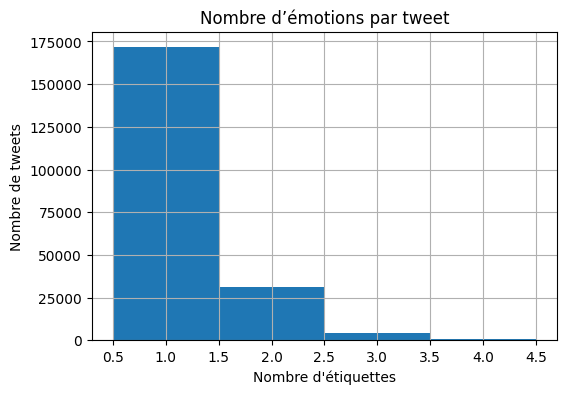

In [6]:
df['n_emotions'] = df['labels'].apply(len)
df['n_emotions'].hist(bins=range(1, 6), align='left', figsize=(6, 4))
plt.title("Nombre d’émotions par tweet")
plt.xlabel("Nombre d'étiquettes")
plt.ylabel("Nombre de tweets")
plt.grid(True)
plt.show()

## 4.1 - Répartition des émotions globales

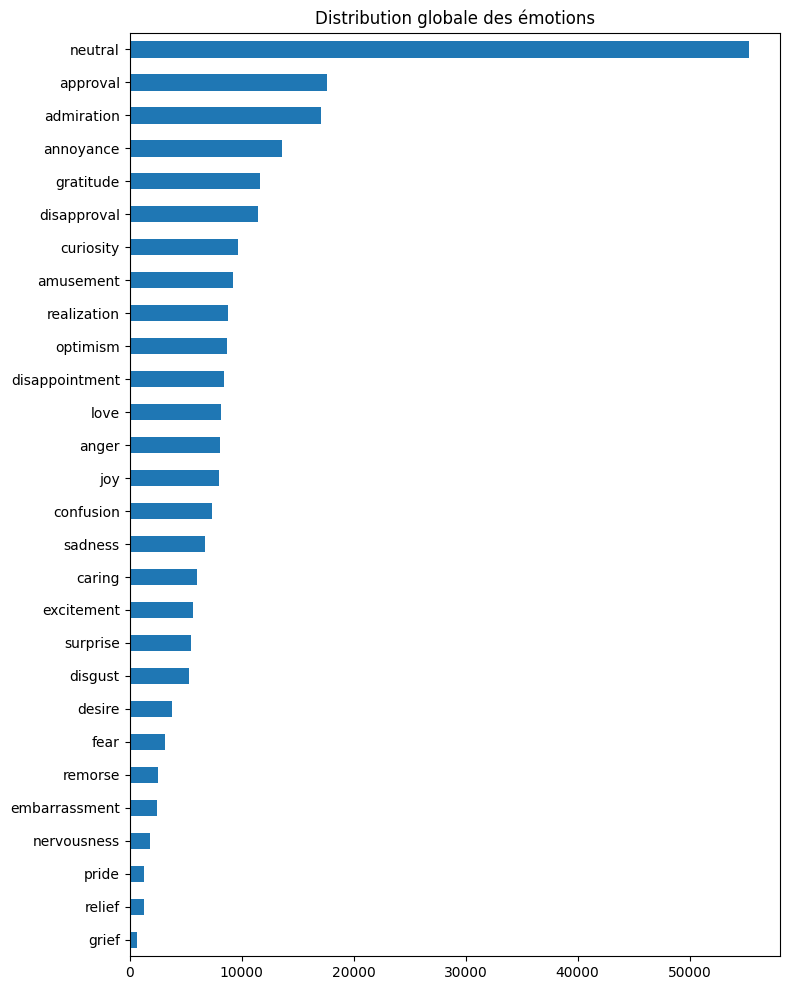

In [7]:
df[emotion_cols].sum().sort_values().plot(kind="barh", figsize=(8, 10))
plt.title("Distribution globale des émotions")
plt.tight_layout()
plt.show()

# 5 - Nuage de mots

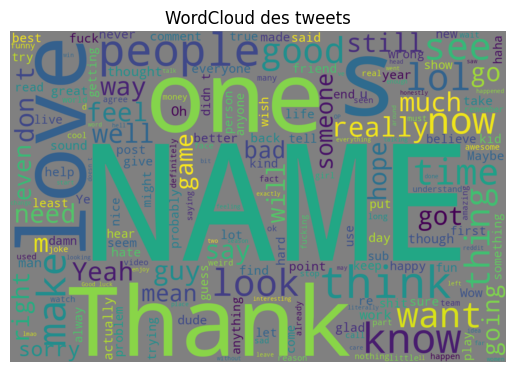

In [8]:
all_text = " ".join(df['text'].tolist())
wordcloud = WordCloud(width = 1200, height = 800, background_color = "grey").generate(all_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("WordCloud des tweets")
plt.show()

# 6 - Entraînement du modèle via pipeline sur GoEmotions (multi-label à 28 classes)

- Entraînement d'un modèle ELECTRA pour la tâche d’analyse fine des émotions à partir du dataset **GoEmotions**, contenant 28 étiquettes émotionnelles (colère, joie, peur, etc.).

    - Contrairement à une tâche de classification binaire, chaque tweet peut ici exprimer **plusieurs émotions simultanément**. Il s'agit donc d'un problème de **classification multi-label**.

---

**Modifications spécifiques apportées au pipeline `run_emotion_pipeline()` :**

- ✅ Chargement du modèle de base `electra-small-discriminator` en local (dossier `models/hf_assets/`)
- ✅ Création dynamique de la colonne `labels` à partir des 28 colonnes d’émotions binaires
- ✅ Initialisation du modèle avec :
  - `num_labels=28` (une sortie par émotion)
  - `problem_type="multi_label_classification"` (Head de classification multi-étiquette)
- ✅ Seuil de prédiction appliqué : `logits > 0 → 1`, sinon `0`
- ✅ Enregistrement automatique :
  - du modèle (`model.save_pretrained(...)`)
  - du tokenizer
  - des métriques (`f1`, `accuracy`) dans `metrics.pkl`
- ✅ Intégration complète à MLflow pour le suivi des runs

---

> Ce modèle est indépendant de celui entraîné pour la classification binaire des sentiments (positif/négatif), et sera enregistré dans `models/emotions/`.

In [9]:
model, tokenizer, metrics = run_emotion_pipeline(force_retrain = False)

Some weights of the model checkpoint at c:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P09\P9_V2\models\hf_assets\electra-small-discriminator were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense.bias', 'discriminator_predictions.dense.weight', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense_prediction.weight']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkp

{'loss': 2.6081, 'learning_rate': 3.247456159341849e-07, 'epoch': 0.01}


  0%|          | 200/92372 [01:27<11:10:05,  2.29it/s]

{'loss': 2.5988, 'learning_rate': 6.494912318683698e-07, 'epoch': 0.02}


  0%|          | 300/92372 [02:11<11:05:56,  2.30it/s]

{'loss': 2.5757, 'learning_rate': 9.742368478025547e-07, 'epoch': 0.02}


  0%|          | 400/92372 [02:54<11:01:42,  2.32it/s]

{'loss': 2.5332, 'learning_rate': 1.2989824637367395e-06, 'epoch': 0.03}


  1%|          | 500/92372 [03:38<11:05:27,  2.30it/s]

{'loss': 2.47, 'learning_rate': 1.6237280796709243e-06, 'epoch': 0.04}


  1%|          | 600/92372 [04:21<11:02:45,  2.31it/s]

{'loss': 2.4038, 'learning_rate': 1.9484736956051094e-06, 'epoch': 0.05}


  1%|          | 700/92372 [05:05<10:59:04,  2.32it/s]

{'loss': 2.3375, 'learning_rate': 2.2732193115392944e-06, 'epoch': 0.05}


  1%|          | 800/92372 [05:48<11:03:18,  2.30it/s]

{'loss': 2.2667, 'learning_rate': 2.597964927473479e-06, 'epoch': 0.06}


  1%|          | 900/92372 [06:32<11:00:18,  2.31it/s]

{'loss': 2.193, 'learning_rate': 2.922710543407664e-06, 'epoch': 0.07}


  1%|          | 1000/92372 [07:15<10:59:10,  2.31it/s]

{'loss': 2.1062, 'learning_rate': 3.2474561593418487e-06, 'epoch': 0.08}


  1%|          | 1100/92372 [07:58<11:06:32,  2.28it/s]

{'loss': 2.0131, 'learning_rate': 3.5722017752760337e-06, 'epoch': 0.08}


  1%|▏         | 1200/92372 [08:42<11:01:33,  2.30it/s]

{'loss': 1.897, 'learning_rate': 3.896947391210219e-06, 'epoch': 0.09}


  1%|▏         | 1300/92372 [09:25<10:59:49,  2.30it/s]

{'loss': 1.7691, 'learning_rate': 4.221693007144404e-06, 'epoch': 0.1}


  2%|▏         | 1400/92372 [10:09<10:55:48,  2.31it/s]

{'loss': 1.6186, 'learning_rate': 4.546438623078589e-06, 'epoch': 0.11}


  2%|▏         | 1500/92372 [10:52<10:56:56,  2.31it/s]

{'loss': 1.4591, 'learning_rate': 4.871184239012773e-06, 'epoch': 0.11}


  2%|▏         | 1600/92372 [11:36<10:53:44,  2.31it/s]

{'loss': 1.2921, 'learning_rate': 5.195929854946958e-06, 'epoch': 0.12}


  2%|▏         | 1700/92372 [12:19<10:59:08,  2.29it/s]

{'loss': 1.1234, 'learning_rate': 5.5206754708811435e-06, 'epoch': 0.13}


  2%|▏         | 1800/92372 [13:02<10:52:07,  2.31it/s]

{'loss': 0.9614, 'learning_rate': 5.845421086815328e-06, 'epoch': 0.14}


  2%|▏         | 1900/92372 [13:46<10:58:17,  2.29it/s]

{'loss': 0.8187, 'learning_rate': 6.170166702749513e-06, 'epoch': 0.14}


  2%|▏         | 2000/92372 [14:29<10:52:43,  2.31it/s]

{'loss': 0.7061, 'learning_rate': 6.494912318683697e-06, 'epoch': 0.15}


  2%|▏         | 2100/92372 [15:13<10:48:53,  2.32it/s]

{'loss': 0.6248, 'learning_rate': 6.819657934617883e-06, 'epoch': 0.16}


  2%|▏         | 2200/92372 [15:56<10:57:01,  2.29it/s]

{'loss': 0.5778, 'learning_rate': 7.144403550552067e-06, 'epoch': 0.17}


  2%|▏         | 2300/92372 [16:39<10:49:29,  2.31it/s]

{'loss': 0.5433, 'learning_rate': 7.469149166486252e-06, 'epoch': 0.17}


  3%|▎         | 2400/92372 [17:23<10:49:27,  2.31it/s]

{'loss': 0.5312, 'learning_rate': 7.793894782420437e-06, 'epoch': 0.18}


  3%|▎         | 2500/92372 [18:06<10:48:22,  2.31it/s]

{'loss': 0.5218, 'learning_rate': 8.118640398354623e-06, 'epoch': 0.19}


  3%|▎         | 2600/92372 [18:50<10:46:58,  2.31it/s]

{'loss': 0.5265, 'learning_rate': 8.443386014288808e-06, 'epoch': 0.2}


  3%|▎         | 2700/92372 [19:33<10:47:43,  2.31it/s]

{'loss': 0.5215, 'learning_rate': 8.768131630222992e-06, 'epoch': 0.2}


  3%|▎         | 2800/92372 [20:17<10:46:20,  2.31it/s]

{'loss': 0.5079, 'learning_rate': 9.092877246157178e-06, 'epoch': 0.21}


  3%|▎         | 2900/92372 [21:00<10:46:53,  2.31it/s]

{'loss': 0.5137, 'learning_rate': 9.417622862091361e-06, 'epoch': 0.22}


  3%|▎         | 3000/92372 [21:43<10:44:12,  2.31it/s]

{'loss': 0.5128, 'learning_rate': 9.742368478025547e-06, 'epoch': 0.23}


  3%|▎         | 3100/92372 [22:27<10:45:18,  2.31it/s]

{'loss': 0.51, 'learning_rate': 1.0067114093959732e-05, 'epoch': 0.23}


  3%|▎         | 3200/92372 [23:10<10:48:50,  2.29it/s]

{'loss': 0.513, 'learning_rate': 1.0391859709893916e-05, 'epoch': 0.24}


  4%|▎         | 3300/92372 [23:54<10:45:19,  2.30it/s]

{'loss': 0.5235, 'learning_rate': 1.0716605325828102e-05, 'epoch': 0.25}


  4%|▎         | 3400/92372 [24:37<10:43:02,  2.31it/s]

{'loss': 0.5158, 'learning_rate': 1.1041350941762287e-05, 'epoch': 0.26}


  4%|▍         | 3500/92372 [25:21<10:47:12,  2.29it/s]

{'loss': 0.5184, 'learning_rate': 1.136609655769647e-05, 'epoch': 0.27}


  4%|▍         | 3600/92372 [26:04<10:39:55,  2.31it/s]

{'loss': 0.5181, 'learning_rate': 1.1690842173630656e-05, 'epoch': 0.27}


  4%|▍         | 3700/92372 [26:48<10:38:43,  2.31it/s]

{'loss': 0.5075, 'learning_rate': 1.2015587789564842e-05, 'epoch': 0.28}


  4%|▍         | 3800/92372 [27:31<10:44:23,  2.29it/s]

{'loss': 0.5199, 'learning_rate': 1.2340333405499025e-05, 'epoch': 0.29}


  4%|▍         | 3900/92372 [28:15<10:39:43,  2.30it/s]

{'loss': 0.5144, 'learning_rate': 1.2665079021433211e-05, 'epoch': 0.3}


  4%|▍         | 4000/92372 [28:58<10:39:08,  2.30it/s]

{'loss': 0.5117, 'learning_rate': 1.2989824637367395e-05, 'epoch': 0.3}


  4%|▍         | 4100/92372 [29:41<10:36:45,  2.31it/s]

{'loss': 0.4998, 'learning_rate': 1.331457025330158e-05, 'epoch': 0.31}


  5%|▍         | 4200/92372 [30:25<10:39:41,  2.30it/s]

{'loss': 0.5048, 'learning_rate': 1.3639315869235766e-05, 'epoch': 0.32}


  5%|▍         | 4300/92372 [31:08<10:41:15,  2.29it/s]

{'loss': 0.4983, 'learning_rate': 1.396406148516995e-05, 'epoch': 0.33}


  5%|▍         | 4400/92372 [31:52<10:34:38,  2.31it/s]

{'loss': 0.5091, 'learning_rate': 1.4288807101104135e-05, 'epoch': 0.33}


  5%|▍         | 4500/92372 [32:35<10:33:15,  2.31it/s]

{'loss': 0.5055, 'learning_rate': 1.461355271703832e-05, 'epoch': 0.34}


  5%|▍         | 4600/92372 [33:19<10:35:40,  2.30it/s]

{'loss': 0.4952, 'learning_rate': 1.4938298332972504e-05, 'epoch': 0.35}


  5%|▌         | 4700/92372 [34:02<10:31:58,  2.31it/s]

{'loss': 0.5119, 'learning_rate': 1.5263043948906688e-05, 'epoch': 0.36}


  5%|▌         | 4800/92372 [34:45<10:32:57,  2.31it/s]

{'loss': 0.5135, 'learning_rate': 1.5587789564840875e-05, 'epoch': 0.36}


  5%|▌         | 4900/92372 [35:29<10:38:10,  2.28it/s]

{'loss': 0.4868, 'learning_rate': 1.591253518077506e-05, 'epoch': 0.37}


  5%|▌         | 5000/92372 [36:12<10:31:20,  2.31it/s]

{'loss': 0.4845, 'learning_rate': 1.6237280796709246e-05, 'epoch': 0.38}


  6%|▌         | 5100/92372 [36:56<10:27:54,  2.32it/s]

{'loss': 0.4902, 'learning_rate': 1.656202641264343e-05, 'epoch': 0.39}


  6%|▌         | 5200/92372 [37:39<10:27:54,  2.31it/s]

{'loss': 0.5002, 'learning_rate': 1.6886772028577617e-05, 'epoch': 0.39}


  6%|▌         | 5300/92372 [38:23<10:29:51,  2.30it/s]

{'loss': 0.4977, 'learning_rate': 1.7211517644511797e-05, 'epoch': 0.4}


  6%|▌         | 5400/92372 [39:06<10:30:01,  2.30it/s]

{'loss': 0.4872, 'learning_rate': 1.7536263260445984e-05, 'epoch': 0.41}


  6%|▌         | 5500/92372 [39:49<10:26:37,  2.31it/s]

{'loss': 0.4653, 'learning_rate': 1.7861008876380168e-05, 'epoch': 0.42}


  6%|▌         | 5600/92372 [40:33<10:30:16,  2.29it/s]

{'loss': 0.4807, 'learning_rate': 1.8185754492314355e-05, 'epoch': 0.42}


  6%|▌         | 5700/92372 [41:17<10:31:48,  2.29it/s]

{'loss': 0.4771, 'learning_rate': 1.851050010824854e-05, 'epoch': 0.43}


  6%|▋         | 5800/92372 [42:00<10:28:58,  2.29it/s]

{'loss': 0.4934, 'learning_rate': 1.8835245724182723e-05, 'epoch': 0.44}


  6%|▋         | 5900/92372 [42:43<10:25:01,  2.31it/s]

{'loss': 0.4685, 'learning_rate': 1.9159991340116907e-05, 'epoch': 0.45}


  6%|▋         | 6000/92372 [43:27<10:26:17,  2.30it/s]

{'loss': 0.4785, 'learning_rate': 1.9484736956051094e-05, 'epoch': 0.45}


  7%|▋         | 6100/92372 [44:10<10:23:02,  2.31it/s]

{'loss': 0.4729, 'learning_rate': 1.9809482571985277e-05, 'epoch': 0.46}


  7%|▋         | 6200/92372 [44:54<10:23:54,  2.30it/s]

{'loss': 0.4667, 'learning_rate': 2.0134228187919465e-05, 'epoch': 0.47}


  7%|▋         | 6300/92372 [45:37<10:19:31,  2.32it/s]

{'loss': 0.4777, 'learning_rate': 2.045897380385365e-05, 'epoch': 0.48}


  7%|▋         | 6400/92372 [46:21<10:23:00,  2.30it/s]

{'loss': 0.4481, 'learning_rate': 2.0783719419787832e-05, 'epoch': 0.48}


  7%|▋         | 6500/92372 [47:04<10:19:28,  2.31it/s]

{'loss': 0.4576, 'learning_rate': 2.110846503572202e-05, 'epoch': 0.49}


  7%|▋         | 6600/92372 [47:48<10:17:20,  2.32it/s]

{'loss': 0.4546, 'learning_rate': 2.1433210651656203e-05, 'epoch': 0.5}


  7%|▋         | 6700/92372 [48:31<10:20:41,  2.30it/s]

{'loss': 0.4511, 'learning_rate': 2.175795626759039e-05, 'epoch': 0.51}


  7%|▋         | 6800/92372 [49:14<10:17:08,  2.31it/s]

{'loss': 0.4583, 'learning_rate': 2.2082701883524574e-05, 'epoch': 0.52}


  7%|▋         | 6900/92372 [49:58<10:22:27,  2.29it/s]

{'loss': 0.4603, 'learning_rate': 2.2407447499458758e-05, 'epoch': 0.52}


  8%|▊         | 7000/92372 [50:41<10:18:07,  2.30it/s]

{'loss': 0.4561, 'learning_rate': 2.273219311539294e-05, 'epoch': 0.53}


  8%|▊         | 7100/92372 [51:25<10:18:26,  2.30it/s]

{'loss': 0.4483, 'learning_rate': 2.305693873132713e-05, 'epoch': 0.54}


  8%|▊         | 7200/92372 [52:08<10:16:37,  2.30it/s]

{'loss': 0.4356, 'learning_rate': 2.3381684347261312e-05, 'epoch': 0.55}


  8%|▊         | 7300/92372 [52:52<10:13:16,  2.31it/s]

{'loss': 0.4411, 'learning_rate': 2.37064299631955e-05, 'epoch': 0.55}


  8%|▊         | 7400/92372 [53:35<10:12:11,  2.31it/s]

{'loss': 0.4413, 'learning_rate': 2.4031175579129683e-05, 'epoch': 0.56}


  8%|▊         | 7500/92372 [54:19<10:12:38,  2.31it/s]

{'loss': 0.4387, 'learning_rate': 2.4355921195063867e-05, 'epoch': 0.57}


  8%|▊         | 7600/92372 [55:02<10:13:17,  2.30it/s]

{'loss': 0.4372, 'learning_rate': 2.468066681099805e-05, 'epoch': 0.58}


  8%|▊         | 7700/92372 [55:46<10:15:20,  2.29it/s]

{'loss': 0.4323, 'learning_rate': 2.5005412426932238e-05, 'epoch': 0.58}


  8%|▊         | 7800/92372 [56:29<10:11:57,  2.30it/s]

{'loss': 0.4362, 'learning_rate': 2.5330158042866422e-05, 'epoch': 0.59}


  9%|▊         | 7900/92372 [57:13<10:12:30,  2.30it/s]

{'loss': 0.4328, 'learning_rate': 2.565490365880061e-05, 'epoch': 0.6}


  9%|▊         | 8000/92372 [57:56<10:08:22,  2.31it/s]

{'loss': 0.4271, 'learning_rate': 2.597964927473479e-05, 'epoch': 0.61}


  9%|▉         | 8100/92372 [58:39<10:08:16,  2.31it/s]

{'loss': 0.4195, 'learning_rate': 2.6304394890668976e-05, 'epoch': 0.61}


  9%|▉         | 8200/92372 [59:23<10:11:25,  2.29it/s]

{'loss': 0.4203, 'learning_rate': 2.662914050660316e-05, 'epoch': 0.62}


  9%|▉         | 8300/92372 [1:00:06<10:10:50,  2.29it/s]

{'loss': 0.4342, 'learning_rate': 2.6953886122537347e-05, 'epoch': 0.63}


  9%|▉         | 8400/92372 [1:00:50<10:03:49,  2.32it/s]

{'loss': 0.4111, 'learning_rate': 2.727863173847153e-05, 'epoch': 0.64}


  9%|▉         | 8500/92372 [1:01:33<10:05:16,  2.31it/s]

{'loss': 0.429, 'learning_rate': 2.7603377354405718e-05, 'epoch': 0.64}


  9%|▉         | 8600/92372 [1:02:17<10:07:11,  2.30it/s]

{'loss': 0.4022, 'learning_rate': 2.79281229703399e-05, 'epoch': 0.65}


  9%|▉         | 8700/92372 [1:03:00<10:07:46,  2.29it/s]

{'loss': 0.4181, 'learning_rate': 2.8252868586274086e-05, 'epoch': 0.66}


 10%|▉         | 8800/92372 [1:03:44<10:02:08,  2.31it/s]

{'loss': 0.4145, 'learning_rate': 2.857761420220827e-05, 'epoch': 0.67}


 10%|▉         | 8900/92372 [1:04:27<10:04:21,  2.30it/s]

{'loss': 0.4262, 'learning_rate': 2.8902359818142457e-05, 'epoch': 0.67}


 10%|▉         | 9000/92372 [1:05:10<9:59:01,  2.32it/s] 

{'loss': 0.4153, 'learning_rate': 2.922710543407664e-05, 'epoch': 0.68}


 10%|▉         | 9100/92372 [1:05:54<9:58:10,  2.32it/s] 

{'loss': 0.4051, 'learning_rate': 2.9551851050010824e-05, 'epoch': 0.69}


 10%|▉         | 9200/92372 [1:06:37<10:00:25,  2.31it/s]

{'loss': 0.4152, 'learning_rate': 2.9876596665945008e-05, 'epoch': 0.7}


 10%|█         | 9300/92372 [1:07:20<10:01:46,  2.30it/s]

{'loss': 0.4054, 'learning_rate': 2.9999958829434258e-05, 'epoch': 0.7}


 10%|█         | 9400/92372 [1:08:04<9:59:30,  2.31it/s] 

{'loss': 0.4026, 'learning_rate': 2.9999718918458085e-05, 'epoch': 0.71}


 10%|█         | 9500/92372 [1:08:47<9:58:06,  2.31it/s] 

{'loss': 0.417, 'learning_rate': 2.999926480475509e-05, 'epoch': 0.72}


 10%|█         | 9600/92372 [1:09:30<9:57:56,  2.31it/s] 

{'loss': 0.4049, 'learning_rate': 2.9998596494810217e-05, 'epoch': 0.73}


 11%|█         | 9700/92372 [1:10:14<10:03:12,  2.28it/s]

{'loss': 0.4139, 'learning_rate': 2.999771399816723e-05, 'epoch': 0.74}


 11%|█         | 9800/92372 [1:10:57<9:53:09,  2.32it/s] 

{'loss': 0.3988, 'learning_rate': 2.9996617327428585e-05, 'epoch': 0.74}


 11%|█         | 9900/92372 [1:11:40<9:53:43,  2.32it/s] 

{'loss': 0.4185, 'learning_rate': 2.9995306498255222e-05, 'epoch': 0.75}


 11%|█         | 10000/92372 [1:12:24<9:56:36,  2.30it/s]

{'loss': 0.3972, 'learning_rate': 2.9993781529366385e-05, 'epoch': 0.76}


 11%|█         | 10100/92372 [1:13:07<9:55:48,  2.30it/s] 

{'loss': 0.4141, 'learning_rate': 2.99920424425393e-05, 'epoch': 0.77}


 11%|█         | 10200/92372 [1:13:51<9:59:13,  2.29it/s] 

{'loss': 0.4055, 'learning_rate': 2.999008926260892e-05, 'epoch': 0.77}


 11%|█         | 10300/92372 [1:14:34<10:05:37,  2.26it/s]

{'loss': 0.4218, 'learning_rate': 2.9987922017467525e-05, 'epoch': 0.78}


 11%|█▏        | 10400/92372 [1:15:18<10:07:51,  2.25it/s]

{'loss': 0.3883, 'learning_rate': 2.9985540738064353e-05, 'epoch': 0.79}


 11%|█▏        | 10500/92372 [1:16:01<9:45:00,  2.33it/s] 

{'loss': 0.3999, 'learning_rate': 2.998294545840514e-05, 'epoch': 0.8}


 11%|█▏        | 10600/92372 [1:16:43<9:31:38,  2.38it/s]

{'loss': 0.4104, 'learning_rate': 2.9980136215551653e-05, 'epoch': 0.8}


 12%|█▏        | 10700/92372 [1:17:25<9:34:59,  2.37it/s]

{'loss': 0.4098, 'learning_rate': 2.9977113049621142e-05, 'epoch': 0.81}


 12%|█▏        | 10800/92372 [1:18:07<9:29:20,  2.39it/s]

{'loss': 0.399, 'learning_rate': 2.997387600378577e-05, 'epoch': 0.82}


 12%|█▏        | 10900/92372 [1:18:49<9:30:13,  2.38it/s]

{'loss': 0.4152, 'learning_rate': 2.9970425124272004e-05, 'epoch': 0.83}


 12%|█▏        | 11000/92372 [1:19:31<9:41:43,  2.33it/s]

{'loss': 0.3965, 'learning_rate': 2.9966760460359954e-05, 'epoch': 0.83}


 12%|█▏        | 11100/92372 [1:20:13<9:27:22,  2.39it/s]

{'loss': 0.4043, 'learning_rate': 2.996288206438268e-05, 'epoch': 0.84}


 12%|█▏        | 11200/92372 [1:20:55<9:25:28,  2.39it/s]

{'loss': 0.401, 'learning_rate': 2.9958789991725407e-05, 'epoch': 0.85}


 12%|█▏        | 11300/92372 [1:21:37<9:25:24,  2.39it/s]

{'loss': 0.3961, 'learning_rate': 2.9954484300824777e-05, 'epoch': 0.86}


 12%|█▏        | 11400/92372 [1:22:19<9:24:28,  2.39it/s]

{'loss': 0.4088, 'learning_rate': 2.9949965053167984e-05, 'epoch': 0.86}


 12%|█▏        | 11500/92372 [1:23:01<9:23:58,  2.39it/s]

{'loss': 0.4036, 'learning_rate': 2.9945232313291927e-05, 'epoch': 0.87}


 13%|█▎        | 11600/92372 [1:23:42<9:08:47,  2.45it/s]

{'loss': 0.4016, 'learning_rate': 2.994028614878225e-05, 'epoch': 0.88}


 13%|█▎        | 11700/92372 [1:24:23<9:27:37,  2.37it/s]

{'loss': 0.3859, 'learning_rate': 2.9935126630272407e-05, 'epoch': 0.89}


 13%|█▎        | 11800/92372 [1:25:05<9:10:06,  2.44it/s]

{'loss': 0.3917, 'learning_rate': 2.992975383144264e-05, 'epoch': 0.89}


 13%|█▎        | 11900/92372 [1:25:46<9:17:57,  2.40it/s]

{'loss': 0.3845, 'learning_rate': 2.9924167829018932e-05, 'epoch': 0.9}


 13%|█▎        | 12000/92372 [1:26:27<9:08:53,  2.44it/s]

{'loss': 0.3966, 'learning_rate': 2.9918368702771907e-05, 'epoch': 0.91}


 13%|█▎        | 12100/92372 [1:27:08<9:09:06,  2.44it/s]

{'loss': 0.4025, 'learning_rate': 2.9912356535515695e-05, 'epoch': 0.92}


 13%|█▎        | 12200/92372 [1:27:49<9:08:00,  2.44it/s]

{'loss': 0.4049, 'learning_rate': 2.9906131413106747e-05, 'epoch': 0.92}


 13%|█▎        | 12300/92372 [1:28:30<9:13:29,  2.41it/s]

{'loss': 0.3974, 'learning_rate': 2.9899693424442604e-05, 'epoch': 0.93}


 13%|█▎        | 12400/92372 [1:29:12<9:05:38,  2.44it/s]

{'loss': 0.3925, 'learning_rate': 2.9893042661460644e-05, 'epoch': 0.94}


 14%|█▎        | 12500/92372 [1:29:53<9:15:34,  2.40it/s]

{'loss': 0.4076, 'learning_rate': 2.9886179219136745e-05, 'epoch': 0.95}


 14%|█▎        | 12600/92372 [1:30:34<9:06:44,  2.43it/s]

{'loss': 0.3862, 'learning_rate': 2.9879103195483954e-05, 'epoch': 0.95}


 14%|█▎        | 12700/92372 [1:31:16<9:02:20,  2.45it/s]

{'loss': 0.3867, 'learning_rate': 2.9871814691551057e-05, 'epoch': 0.96}


 14%|█▍        | 12800/92372 [1:31:56<9:01:21,  2.45it/s]

{'loss': 0.3917, 'learning_rate': 2.986431381142118e-05, 'epoch': 0.97}


 14%|█▍        | 12900/92372 [1:32:38<9:16:37,  2.38it/s]

{'loss': 0.3967, 'learning_rate': 2.9856600662210255e-05, 'epoch': 0.98}


 14%|█▍        | 13000/92372 [1:33:20<9:14:05,  2.39it/s]

{'loss': 0.3837, 'learning_rate': 2.9848675354065514e-05, 'epoch': 0.99}


 14%|█▍        | 13100/92372 [1:34:01<9:14:38,  2.38it/s]

{'loss': 0.397, 'learning_rate': 2.9840538000163932e-05, 'epoch': 0.99}


                                                         
 14%|█▍        | 13196/92372 [1:34:42<7:23:28,  2.98it/s]

{'eval_loss': 0.38660871982574463, 'eval_f1': 0.2837837837837838, 'eval_accuracy': 0.19, 'eval_runtime': 0.8132, 'eval_samples_per_second': 122.973, 'eval_steps_per_second': 4.919, 'epoch': 1.0}


 14%|█▍        | 13200/92372 [1:34:43<11:13:16,  1.96it/s]

{'loss': 0.3996, 'learning_rate': 2.9832188716710565e-05, 'epoch': 1.0}


 14%|█▍        | 13300/92372 [1:35:24<8:57:21,  2.45it/s] 

{'loss': 0.4013, 'learning_rate': 2.982362762293694e-05, 'epoch': 1.01}


 15%|█▍        | 13400/92372 [1:36:05<8:57:27,  2.45it/s]

{'loss': 0.394, 'learning_rate': 2.9814854841099328e-05, 'epoch': 1.02}


 15%|█▍        | 13500/92372 [1:36:47<9:10:45,  2.39it/s]

{'loss': 0.3982, 'learning_rate': 2.9805870496476988e-05, 'epoch': 1.02}


 15%|█▍        | 13600/92372 [1:37:28<9:09:59,  2.39it/s]

{'loss': 0.3891, 'learning_rate': 2.97966747173704e-05, 'epoch': 1.03}


 15%|█▍        | 13700/92372 [1:38:10<9:09:32,  2.39it/s]

{'loss': 0.3889, 'learning_rate': 2.9787267635099427e-05, 'epoch': 1.04}


 15%|█▍        | 13800/92372 [1:38:52<9:14:08,  2.36it/s]

{'loss': 0.3905, 'learning_rate': 2.9777649384001423e-05, 'epoch': 1.05}


 15%|█▌        | 13900/92372 [1:39:34<9:07:34,  2.39it/s]

{'loss': 0.3867, 'learning_rate': 2.9767820101429344e-05, 'epoch': 1.05}


 15%|█▌        | 14000/92372 [1:40:15<8:54:26,  2.44it/s]

{'loss': 0.3892, 'learning_rate': 2.9757779927749757e-05, 'epoch': 1.06}


 15%|█▌        | 14100/92372 [1:40:56<8:51:48,  2.45it/s]

{'loss': 0.3772, 'learning_rate': 2.9747529006340857e-05, 'epoch': 1.07}


 15%|█▌        | 14200/92372 [1:41:37<8:52:07,  2.45it/s]

{'loss': 0.3912, 'learning_rate': 2.973706748359041e-05, 'epoch': 1.08}


 15%|█▌        | 14300/92372 [1:42:18<8:51:47,  2.45it/s]

{'loss': 0.382, 'learning_rate': 2.9726395508893658e-05, 'epoch': 1.08}


 16%|█▌        | 14400/92372 [1:42:59<9:08:30,  2.37it/s]

{'loss': 0.39, 'learning_rate': 2.9715513234651195e-05, 'epoch': 1.09}


 16%|█▌        | 14500/92372 [1:43:41<9:04:59,  2.38it/s]

{'loss': 0.3782, 'learning_rate': 2.9704420816266794e-05, 'epoch': 1.1}


 16%|█▌        | 14600/92372 [1:44:23<9:02:44,  2.39it/s]

{'loss': 0.3833, 'learning_rate': 2.9693118412145163e-05, 'epoch': 1.11}


 16%|█▌        | 14700/92372 [1:45:05<9:09:31,  2.36it/s]

{'loss': 0.3678, 'learning_rate': 2.9681606183689727e-05, 'epoch': 1.11}


 16%|█▌        | 14800/92372 [1:45:47<9:01:21,  2.39it/s]

{'loss': 0.3935, 'learning_rate': 2.9669884295300268e-05, 'epoch': 1.12}


 16%|█▌        | 14900/92372 [1:46:29<9:01:40,  2.38it/s]

{'loss': 0.3809, 'learning_rate': 2.9657952914370625e-05, 'epoch': 1.13}


 16%|█▌        | 15000/92372 [1:47:11<9:00:16,  2.39it/s]

{'loss': 0.3845, 'learning_rate': 2.9645812211286283e-05, 'epoch': 1.14}


 16%|█▋        | 15100/92372 [1:47:53<8:59:27,  2.39it/s]

{'loss': 0.3926, 'learning_rate': 2.9633462359421937e-05, 'epoch': 1.14}


 16%|█▋        | 15200/92372 [1:48:35<8:58:17,  2.39it/s]

{'loss': 0.3781, 'learning_rate': 2.9620903535139015e-05, 'epoch': 1.15}


 17%|█▋        | 15300/92372 [1:49:16<8:58:22,  2.39it/s]

{'loss': 0.3864, 'learning_rate': 2.9608135917783178e-05, 'epoch': 1.16}


 17%|█▋        | 15400/92372 [1:49:58<9:01:08,  2.37it/s]

{'loss': 0.3831, 'learning_rate': 2.9595159689681736e-05, 'epoch': 1.17}


 17%|█▋        | 15500/92372 [1:50:40<8:56:08,  2.39it/s]

{'loss': 0.3941, 'learning_rate': 2.958197503614106e-05, 'epoch': 1.17}


 17%|█▋        | 15600/92372 [1:51:22<8:49:56,  2.41it/s]

{'loss': 0.3869, 'learning_rate': 2.9568582145443933e-05, 'epoch': 1.18}


 17%|█▋        | 15700/92372 [1:52:04<8:54:42,  2.39it/s]

{'loss': 0.3912, 'learning_rate': 2.9554981208846838e-05, 'epoch': 1.19}


 17%|█▋        | 15800/92372 [1:52:46<8:54:30,  2.39it/s]

{'loss': 0.3768, 'learning_rate': 2.9541172420577274e-05, 'epoch': 1.2}


 17%|█▋        | 15900/92372 [1:53:28<8:55:32,  2.38it/s]

{'loss': 0.3716, 'learning_rate': 2.9527155977830936e-05, 'epoch': 1.2}


 17%|█▋        | 16000/92372 [1:54:10<8:52:21,  2.39it/s]

{'loss': 0.3932, 'learning_rate': 2.951293208076893e-05, 'epoch': 1.21}


 17%|█▋        | 16100/92372 [1:54:51<8:52:01,  2.39it/s]

{'loss': 0.3931, 'learning_rate': 2.9498500932514895e-05, 'epoch': 1.22}


 18%|█▊        | 16200/92372 [1:55:33<8:51:47,  2.39it/s]

{'loss': 0.3826, 'learning_rate': 2.9483862739152117e-05, 'epoch': 1.23}


 18%|█▊        | 16300/92372 [1:56:15<8:50:47,  2.39it/s]

{'loss': 0.3817, 'learning_rate': 2.946901770972057e-05, 'epoch': 1.24}


 18%|█▊        | 16400/92372 [1:56:57<8:49:37,  2.39it/s]

{'loss': 0.3925, 'learning_rate': 2.9453966056213948e-05, 'epoch': 1.24}


 18%|█▊        | 16500/92372 [1:57:39<8:49:31,  2.39it/s]

{'loss': 0.3814, 'learning_rate': 2.9438707993576632e-05, 'epoch': 1.25}


 18%|█▊        | 16600/92372 [1:58:21<8:48:53,  2.39it/s]

{'loss': 0.3804, 'learning_rate': 2.9423243739700602e-05, 'epoch': 1.26}


 18%|█▊        | 16700/92372 [1:59:03<8:48:13,  2.39it/s]

{'loss': 0.3948, 'learning_rate': 2.9407573515422366e-05, 'epoch': 1.27}


 18%|█▊        | 16800/92372 [1:59:45<8:45:47,  2.40it/s]

{'loss': 0.3856, 'learning_rate': 2.939169754451976e-05, 'epoch': 1.27}


 18%|█▊        | 16900/92372 [2:00:27<8:46:45,  2.39it/s]

{'loss': 0.3832, 'learning_rate': 2.937561605370878e-05, 'epoch': 1.28}


 18%|█▊        | 17000/92372 [2:01:09<8:45:24,  2.39it/s]

{'loss': 0.3973, 'learning_rate': 2.9359329272640354e-05, 'epoch': 1.29}


 19%|█▊        | 17100/92372 [2:01:51<8:47:00,  2.38it/s]

{'loss': 0.3811, 'learning_rate': 2.9342837433897026e-05, 'epoch': 1.3}


 19%|█▊        | 17200/92372 [2:02:33<8:47:19,  2.38it/s]

{'loss': 0.3775, 'learning_rate': 2.9326140772989667e-05, 'epoch': 1.3}


 19%|█▊        | 17300/92372 [2:03:15<8:33:16,  2.44it/s]

{'loss': 0.3768, 'learning_rate': 2.9309239528354094e-05, 'epoch': 1.31}


 19%|█▉        | 17400/92372 [2:03:56<8:29:05,  2.45it/s]

{'loss': 0.3778, 'learning_rate': 2.9292133941347678e-05, 'epoch': 1.32}


 19%|█▉        | 17500/92372 [2:04:36<8:28:33,  2.45it/s]

{'loss': 0.3746, 'learning_rate': 2.927482425624589e-05, 'epoch': 1.33}


 19%|█▉        | 17600/92372 [2:05:17<8:28:49,  2.45it/s]

{'loss': 0.3867, 'learning_rate': 2.925731072023881e-05, 'epoch': 1.33}


 19%|█▉        | 17700/92372 [2:05:58<8:27:11,  2.45it/s]

{'loss': 0.3824, 'learning_rate': 2.92395935834276e-05, 'epoch': 1.34}


 19%|█▉        | 17800/92372 [2:06:39<8:27:12,  2.45it/s]

{'loss': 0.3769, 'learning_rate': 2.9221673098820947e-05, 'epoch': 1.35}


 19%|█▉        | 17900/92372 [2:07:20<8:27:07,  2.45it/s]

{'loss': 0.3814, 'learning_rate': 2.9203549522331415e-05, 'epoch': 1.36}


 19%|█▉        | 18000/92372 [2:08:01<8:31:09,  2.42it/s]

{'loss': 0.3789, 'learning_rate': 2.9185223112771814e-05, 'epoch': 1.36}


 20%|█▉        | 18100/92372 [2:08:42<8:25:12,  2.45it/s]

{'loss': 0.3764, 'learning_rate': 2.9166694131851524e-05, 'epoch': 1.37}


 20%|█▉        | 18200/92372 [2:09:23<8:24:20,  2.45it/s]

{'loss': 0.3689, 'learning_rate': 2.914796284417271e-05, 'epoch': 1.38}


 20%|█▉        | 18300/92372 [2:10:03<8:23:29,  2.45it/s]

{'loss': 0.3829, 'learning_rate': 2.912902951722658e-05, 'epoch': 1.39}


 20%|█▉        | 18400/92372 [2:10:44<8:23:20,  2.45it/s]

{'loss': 0.3935, 'learning_rate': 2.9109894421389544e-05, 'epoch': 1.39}


 20%|██        | 18500/92372 [2:11:25<8:22:45,  2.45it/s]

{'loss': 0.3779, 'learning_rate': 2.9090557829919383e-05, 'epoch': 1.4}


 20%|██        | 18600/92372 [2:12:06<8:22:47,  2.45it/s]

{'loss': 0.3837, 'learning_rate': 2.9071020018951303e-05, 'epoch': 1.41}


 20%|██        | 18700/92372 [2:12:47<8:22:27,  2.44it/s]

{'loss': 0.3819, 'learning_rate': 2.9051281267494027e-05, 'epoch': 1.42}


 20%|██        | 18800/92372 [2:13:28<8:21:15,  2.45it/s]

{'loss': 0.3819, 'learning_rate': 2.9031341857425794e-05, 'epoch': 1.42}


 20%|██        | 18900/92372 [2:14:09<8:19:59,  2.45it/s]

{'loss': 0.3958, 'learning_rate': 2.901120207349035e-05, 'epoch': 1.43}


 21%|██        | 19000/92372 [2:14:49<8:19:01,  2.45it/s]

{'loss': 0.37, 'learning_rate': 2.8990862203292847e-05, 'epoch': 1.44}


 21%|██        | 19100/92372 [2:15:30<8:18:14,  2.45it/s]

{'loss': 0.3876, 'learning_rate': 2.897032253729578e-05, 'epoch': 1.45}


 21%|██        | 19200/92372 [2:16:12<8:30:21,  2.39it/s]

{'loss': 0.377, 'learning_rate': 2.8949583368814806e-05, 'epoch': 1.45}


 21%|██        | 19300/92372 [2:16:54<8:29:32,  2.39it/s]

{'loss': 0.3815, 'learning_rate': 2.8928644994014573e-05, 'epoch': 1.46}


 21%|██        | 19400/92372 [2:17:36<8:28:14,  2.39it/s]

{'loss': 0.3774, 'learning_rate': 2.8907507711904483e-05, 'epoch': 1.47}


 21%|██        | 19500/92372 [2:18:18<8:32:00,  2.37it/s]

{'loss': 0.381, 'learning_rate': 2.888617182433442e-05, 'epoch': 1.48}


 21%|██        | 19600/92372 [2:18:59<8:27:19,  2.39it/s]

{'loss': 0.3789, 'learning_rate': 2.886463763599045e-05, 'epoch': 1.49}


 21%|██▏       | 19700/92372 [2:19:41<8:27:39,  2.39it/s]

{'loss': 0.3717, 'learning_rate': 2.884290545439046e-05, 'epoch': 1.49}


 21%|██▏       | 19800/92372 [2:20:23<8:28:26,  2.38it/s]

{'loss': 0.3746, 'learning_rate': 2.8820975589879764e-05, 'epoch': 1.5}


 22%|██▏       | 19900/92372 [2:21:05<8:26:31,  2.38it/s]

{'loss': 0.3895, 'learning_rate': 2.879884835562669e-05, 'epoch': 1.51}


 22%|██▏       | 20000/92372 [2:21:47<8:24:30,  2.39it/s]

{'loss': 0.3672, 'learning_rate': 2.8776524067618078e-05, 'epoch': 1.52}


 22%|██▏       | 20100/92372 [2:22:29<8:24:23,  2.39it/s]

{'loss': 0.3801, 'learning_rate': 2.87540030446548e-05, 'epoch': 1.52}


 22%|██▏       | 20200/92372 [2:23:11<8:44:37,  2.29it/s]

{'loss': 0.3838, 'learning_rate': 2.8731285608347187e-05, 'epoch': 1.53}


 22%|██▏       | 20300/92372 [2:23:54<8:36:54,  2.32it/s]

{'loss': 0.3723, 'learning_rate': 2.8708372083110427e-05, 'epoch': 1.54}


 22%|██▏       | 20400/92372 [2:24:36<8:22:59,  2.38it/s]

{'loss': 0.3808, 'learning_rate': 2.8685262796159966e-05, 'epoch': 1.55}


 22%|██▏       | 20500/92372 [2:25:19<8:24:51,  2.37it/s]

{'loss': 0.3767, 'learning_rate': 2.8661958077506804e-05, 'epoch': 1.55}


 22%|██▏       | 20600/92372 [2:26:01<8:24:34,  2.37it/s]

{'loss': 0.3714, 'learning_rate': 2.86384582599528e-05, 'epoch': 1.56}


 22%|██▏       | 20700/92372 [2:26:43<8:27:05,  2.36it/s]

{'loss': 0.3769, 'learning_rate': 2.8614763679085905e-05, 'epoch': 1.57}


 23%|██▎       | 20800/92372 [2:27:25<8:19:56,  2.39it/s]

{'loss': 0.376, 'learning_rate': 2.8590874673275383e-05, 'epoch': 1.58}


 23%|██▎       | 20900/92372 [2:28:07<8:20:36,  2.38it/s]

{'loss': 0.3774, 'learning_rate': 2.8566791583666973e-05, 'epoch': 1.58}


 23%|██▎       | 21000/92372 [2:28:50<8:19:37,  2.38it/s]

{'loss': 0.3783, 'learning_rate': 2.854251475417802e-05, 'epoch': 1.59}


 23%|██▎       | 21100/92372 [2:29:32<8:29:04,  2.33it/s]

{'loss': 0.3784, 'learning_rate': 2.851804453149255e-05, 'epoch': 1.6}


 23%|██▎       | 21200/92372 [2:30:15<8:19:22,  2.38it/s]

{'loss': 0.3771, 'learning_rate': 2.8493381265056347e-05, 'epoch': 1.61}


 23%|██▎       | 21300/92372 [2:30:57<8:23:18,  2.35it/s]

{'loss': 0.3807, 'learning_rate': 2.8468525307071936e-05, 'epoch': 1.61}


 23%|██▎       | 21400/92372 [2:31:39<8:17:50,  2.38it/s]

{'loss': 0.3833, 'learning_rate': 2.8443477012493563e-05, 'epoch': 1.62}


 23%|██▎       | 21500/92372 [2:32:21<8:15:22,  2.38it/s]

{'loss': 0.3766, 'learning_rate': 2.8418236739022142e-05, 'epoch': 1.63}


 23%|██▎       | 21600/92372 [2:33:03<8:14:45,  2.38it/s]

{'loss': 0.3642, 'learning_rate': 2.8392804847100118e-05, 'epoch': 1.64}


 23%|██▎       | 21700/92372 [2:33:45<8:13:06,  2.39it/s]

{'loss': 0.3859, 'learning_rate': 2.8367181699906326e-05, 'epoch': 1.64}


 24%|██▎       | 21800/92372 [2:34:27<8:11:53,  2.39it/s]

{'loss': 0.3833, 'learning_rate': 2.8341367663350833e-05, 'epoch': 1.65}


 24%|██▎       | 21900/92372 [2:35:09<8:11:39,  2.39it/s]

{'loss': 0.3886, 'learning_rate': 2.831536310606968e-05, 'epoch': 1.66}


 24%|██▍       | 22000/92372 [2:35:51<8:12:00,  2.38it/s]

{'loss': 0.3884, 'learning_rate': 2.8289168399419626e-05, 'epoch': 1.67}


 24%|██▍       | 22100/92372 [2:36:33<8:10:18,  2.39it/s]

{'loss': 0.3687, 'learning_rate': 2.8262783917472854e-05, 'epoch': 1.67}


 24%|██▍       | 22200/92372 [2:37:15<8:19:31,  2.34it/s]

{'loss': 0.3675, 'learning_rate': 2.8236210037011633e-05, 'epoch': 1.68}


 24%|██▍       | 22300/92372 [2:37:58<8:10:11,  2.38it/s]

{'loss': 0.377, 'learning_rate': 2.8209447137522904e-05, 'epoch': 1.69}


 24%|██▍       | 22400/92372 [2:38:40<8:11:47,  2.37it/s]

{'loss': 0.3797, 'learning_rate': 2.8182495601192906e-05, 'epoch': 1.7}


 24%|██▍       | 22500/92372 [2:39:22<8:10:45,  2.37it/s]

{'loss': 0.3726, 'learning_rate': 2.8155355812901692e-05, 'epoch': 1.71}


 24%|██▍       | 22600/92372 [2:40:04<8:09:34,  2.38it/s]

{'loss': 0.387, 'learning_rate': 2.8128028160217633e-05, 'epoch': 1.71}


 25%|██▍       | 22700/92372 [2:40:46<8:06:40,  2.39it/s]

{'loss': 0.3806, 'learning_rate': 2.8100513033391884e-05, 'epoch': 1.72}


 25%|██▍       | 22800/92372 [2:41:28<8:07:41,  2.38it/s]

{'loss': 0.3878, 'learning_rate': 2.8072810825352825e-05, 'epoch': 1.73}


 25%|██▍       | 22900/92372 [2:42:10<8:04:07,  2.39it/s]

{'loss': 0.3749, 'learning_rate': 2.804492193170044e-05, 'epoch': 1.74}


 25%|██▍       | 23000/92372 [2:42:52<8:04:57,  2.38it/s]

{'loss': 0.3632, 'learning_rate': 2.801684675070066e-05, 'epoch': 1.74}


 25%|██▌       | 23100/92372 [2:43:34<8:05:04,  2.38it/s]

{'loss': 0.3736, 'learning_rate': 2.7988585683279683e-05, 'epoch': 1.75}


 25%|██▌       | 23200/92372 [2:44:16<8:05:01,  2.38it/s]

{'loss': 0.3761, 'learning_rate': 2.7960139133018258e-05, 'epoch': 1.76}


 25%|██▌       | 23300/92372 [2:44:58<8:06:59,  2.36it/s]

{'loss': 0.3744, 'learning_rate': 2.7931507506145904e-05, 'epoch': 1.77}


 25%|██▌       | 23400/92372 [2:45:41<8:13:26,  2.33it/s]

{'loss': 0.3694, 'learning_rate': 2.7902691211535117e-05, 'epoch': 1.77}


 25%|██▌       | 23500/92372 [2:46:22<7:59:15,  2.40it/s]

{'loss': 0.374, 'learning_rate': 2.7873690660695538e-05, 'epoch': 1.78}


 26%|██▌       | 23600/92372 [2:47:04<7:57:51,  2.40it/s]

{'loss': 0.3808, 'learning_rate': 2.784450626776806e-05, 'epoch': 1.79}


 26%|██▌       | 23700/92372 [2:47:46<7:58:10,  2.39it/s]

{'loss': 0.3731, 'learning_rate': 2.781513844951893e-05, 'epoch': 1.8}


 26%|██▌       | 23800/92372 [2:48:27<7:54:36,  2.41it/s]

{'loss': 0.3834, 'learning_rate': 2.7785587625333798e-05, 'epoch': 1.8}


 26%|██▌       | 23900/92372 [2:49:09<7:53:55,  2.41it/s]

{'loss': 0.3839, 'learning_rate': 2.77558542172117e-05, 'epoch': 1.81}


 26%|██▌       | 24000/92372 [2:49:51<7:54:02,  2.40it/s]

{'loss': 0.3677, 'learning_rate': 2.7725938649759078e-05, 'epoch': 1.82}


 26%|██▌       | 24100/92372 [2:50:32<7:55:00,  2.40it/s]

{'loss': 0.3755, 'learning_rate': 2.769584135018367e-05, 'epoch': 1.83}


 26%|██▌       | 24200/92372 [2:51:14<7:54:46,  2.39it/s]

{'loss': 0.3731, 'learning_rate': 2.766556274828844e-05, 'epoch': 1.83}


 26%|██▋       | 24300/92372 [2:51:56<7:52:02,  2.40it/s]

{'loss': 0.3663, 'learning_rate': 2.7635103276465442e-05, 'epoch': 1.84}


 26%|██▋       | 24400/92372 [2:52:37<7:50:56,  2.41it/s]

{'loss': 0.3882, 'learning_rate': 2.7604463369689602e-05, 'epoch': 1.85}


 27%|██▋       | 24500/92372 [2:53:19<7:49:19,  2.41it/s]

{'loss': 0.3748, 'learning_rate': 2.7573643465512578e-05, 'epoch': 1.86}


 27%|██▋       | 24600/92372 [2:54:01<7:48:48,  2.41it/s]

{'loss': 0.3761, 'learning_rate': 2.7542644004056437e-05, 'epoch': 1.86}


 27%|██▋       | 24700/92372 [2:54:43<7:51:22,  2.39it/s]

{'loss': 0.3817, 'learning_rate': 2.7511465428007425e-05, 'epoch': 1.87}


 27%|██▋       | 24800/92372 [2:55:24<7:48:38,  2.40it/s]

{'loss': 0.3748, 'learning_rate': 2.748010818260962e-05, 'epoch': 1.88}


 27%|██▋       | 24900/92372 [2:56:06<7:47:32,  2.41it/s]

{'loss': 0.3695, 'learning_rate': 2.7448572715658578e-05, 'epoch': 1.89}


 27%|██▋       | 25000/92372 [2:56:48<7:50:31,  2.39it/s]

{'loss': 0.3685, 'learning_rate': 2.7416859477494932e-05, 'epoch': 1.89}


 27%|██▋       | 25100/92372 [2:57:29<7:48:45,  2.39it/s]

{'loss': 0.3742, 'learning_rate': 2.7384968920997984e-05, 'epoch': 1.9}


 27%|██▋       | 25200/92372 [2:58:11<7:49:19,  2.39it/s]

{'loss': 0.3852, 'learning_rate': 2.7352901501579206e-05, 'epoch': 1.91}


 27%|██▋       | 25300/92372 [2:58:53<7:44:47,  2.41it/s]

{'loss': 0.3744, 'learning_rate': 2.7320657677175756e-05, 'epoch': 1.92}


 27%|██▋       | 25400/92372 [2:59:35<7:44:01,  2.41it/s]

{'loss': 0.3856, 'learning_rate': 2.7288237908243944e-05, 'epoch': 1.92}


 28%|██▊       | 25500/92372 [3:00:17<7:54:08,  2.35it/s]

{'loss': 0.3783, 'learning_rate': 2.7255642657752632e-05, 'epoch': 1.93}


 28%|██▊       | 25600/92372 [3:00:59<7:58:04,  2.33it/s]

{'loss': 0.3666, 'learning_rate': 2.722287239117665e-05, 'epoch': 1.94}


 28%|██▊       | 25700/92372 [3:01:41<7:53:26,  2.35it/s]

{'loss': 0.3568, 'learning_rate': 2.7189927576490135e-05, 'epoch': 1.95}


 28%|██▊       | 25800/92372 [3:02:24<7:51:44,  2.35it/s]

{'loss': 0.3813, 'learning_rate': 2.715680868415983e-05, 'epoch': 1.96}


 28%|██▊       | 25900/92372 [3:03:06<7:44:13,  2.39it/s]

{'loss': 0.3682, 'learning_rate': 2.7123516187138417e-05, 'epoch': 1.96}


 28%|██▊       | 26000/92372 [3:03:48<7:44:52,  2.38it/s]

{'loss': 0.3731, 'learning_rate': 2.709005056085771e-05, 'epoch': 1.97}


 28%|██▊       | 26100/92372 [3:04:30<7:43:48,  2.38it/s]

{'loss': 0.372, 'learning_rate': 2.7056412283221885e-05, 'epoch': 1.98}


 28%|██▊       | 26200/92372 [3:05:13<7:42:11,  2.39it/s]

{'loss': 0.3691, 'learning_rate': 2.7022601834600672e-05, 'epoch': 1.99}


 28%|██▊       | 26300/92372 [3:05:55<7:45:51,  2.36it/s]

{'loss': 0.3514, 'learning_rate': 2.6988619697822462e-05, 'epoch': 1.99}


                                                         
 29%|██▊       | 26392/92372 [3:06:34<6:26:32,  2.84it/s]

{'eval_loss': 0.3580363392829895, 'eval_f1': 0.27586206896551724, 'eval_accuracy': 0.17, 'eval_runtime': 0.8496, 'eval_samples_per_second': 117.707, 'eval_steps_per_second': 4.708, 'epoch': 2.0}


 29%|██▊       | 26400/92372 [3:06:38<8:31:07,  2.15it/s] 

{'loss': 0.3775, 'learning_rate': 2.6954466358167446e-05, 'epoch': 2.0}


 29%|██▊       | 26500/92372 [3:07:21<7:59:16,  2.29it/s]

{'loss': 0.3661, 'learning_rate': 2.692014230336066e-05, 'epoch': 2.01}


 29%|██▉       | 26600/92372 [3:08:03<7:45:00,  2.36it/s]

{'loss': 0.3596, 'learning_rate': 2.688564802356504e-05, 'epoch': 2.02}


 29%|██▉       | 26700/92372 [3:08:46<7:44:25,  2.36it/s]

{'loss': 0.3625, 'learning_rate': 2.6850984011374386e-05, 'epoch': 2.02}


 29%|██▉       | 26800/92372 [3:09:27<7:28:02,  2.44it/s]

{'loss': 0.3665, 'learning_rate': 2.6816150761806382e-05, 'epoch': 2.03}


 29%|██▉       | 26900/92372 [3:10:08<7:26:34,  2.44it/s]

{'loss': 0.373, 'learning_rate': 2.6781148772295478e-05, 'epoch': 2.04}


 29%|██▉       | 27000/92372 [3:10:49<7:24:58,  2.45it/s]

{'loss': 0.3617, 'learning_rate': 2.674597854268582e-05, 'epoch': 2.05}


 29%|██▉       | 27100/92372 [3:11:30<7:23:42,  2.45it/s]

{'loss': 0.3651, 'learning_rate': 2.6710640575224094e-05, 'epoch': 2.05}


 29%|██▉       | 27200/92372 [3:12:12<7:32:39,  2.40it/s]

{'loss': 0.3534, 'learning_rate': 2.667513537455235e-05, 'epoch': 2.06}


 30%|██▉       | 27300/92372 [3:12:53<7:30:24,  2.41it/s]

{'loss': 0.3629, 'learning_rate': 2.6639463447700803e-05, 'epoch': 2.07}


 30%|██▉       | 27400/92372 [3:13:35<7:32:53,  2.39it/s]

{'loss': 0.3602, 'learning_rate': 2.660362530408061e-05, 'epoch': 2.08}


 30%|██▉       | 27500/92372 [3:14:17<7:33:26,  2.38it/s]

{'loss': 0.3604, 'learning_rate': 2.6567621455476565e-05, 'epoch': 2.08}


 30%|██▉       | 27600/92372 [3:14:58<7:27:51,  2.41it/s]

{'loss': 0.3681, 'learning_rate': 2.6531452416039806e-05, 'epoch': 2.09}


 30%|██▉       | 27700/92372 [3:15:40<7:29:29,  2.40it/s]

{'loss': 0.3666, 'learning_rate': 2.6495118702280464e-05, 'epoch': 2.1}


 30%|███       | 27800/92372 [3:16:22<7:27:50,  2.40it/s]

{'loss': 0.3697, 'learning_rate': 2.6458620833060304e-05, 'epoch': 2.11}


 30%|███       | 27900/92372 [3:17:04<7:26:56,  2.40it/s]

{'loss': 0.3517, 'learning_rate': 2.64219593295853e-05, 'epoch': 2.11}


 30%|███       | 28000/92372 [3:17:45<7:26:24,  2.40it/s]

{'loss': 0.3599, 'learning_rate': 2.6385134715398195e-05, 'epoch': 2.12}


 30%|███       | 28100/92372 [3:18:27<7:45:34,  2.30it/s]

{'loss': 0.3711, 'learning_rate': 2.6348147516371032e-05, 'epoch': 2.13}


 31%|███       | 28200/92372 [3:19:11<7:38:57,  2.33it/s]

{'loss': 0.3694, 'learning_rate': 2.6310998260697633e-05, 'epoch': 2.14}


 31%|███       | 28300/92372 [3:19:54<7:43:16,  2.31it/s]

{'loss': 0.3642, 'learning_rate': 2.627368747888606e-05, 'epoch': 2.14}


 31%|███       | 28400/92372 [3:20:37<8:00:26,  2.22it/s]

{'loss': 0.36, 'learning_rate': 2.6236215703751045e-05, 'epoch': 2.15}


 31%|███       | 28500/92372 [3:21:19<7:30:51,  2.36it/s]

{'loss': 0.371, 'learning_rate': 2.619858347040638e-05, 'epoch': 2.16}


 31%|███       | 28600/92372 [3:22:01<7:26:58,  2.38it/s]

{'loss': 0.3563, 'learning_rate': 2.6160791316257268e-05, 'epoch': 2.17}


 31%|███       | 28700/92372 [3:22:43<7:22:33,  2.40it/s]

{'loss': 0.3666, 'learning_rate': 2.612283978099265e-05, 'epoch': 2.17}


 31%|███       | 28800/92372 [3:23:25<7:23:02,  2.39it/s]

{'loss': 0.3688, 'learning_rate': 2.6084729406577506e-05, 'epoch': 2.18}


 31%|███▏      | 28900/92372 [3:24:07<7:23:26,  2.39it/s]

{'loss': 0.3587, 'learning_rate': 2.6046460737245113e-05, 'epoch': 2.19}


 31%|███▏      | 29000/92372 [3:24:49<7:22:40,  2.39it/s]

{'loss': 0.3703, 'learning_rate': 2.600803431948926e-05, 'epoch': 2.2}


 32%|███▏      | 29100/92372 [3:25:31<7:20:26,  2.39it/s]

{'loss': 0.3487, 'learning_rate': 2.596945070205646e-05, 'epoch': 2.21}


 32%|███▏      | 29200/92372 [3:26:12<7:21:02,  2.39it/s]

{'loss': 0.3736, 'learning_rate': 2.593071043593812e-05, 'epoch': 2.21}


 32%|███▏      | 29300/92372 [3:26:54<7:20:05,  2.39it/s]

{'loss': 0.3589, 'learning_rate': 2.589181407436264e-05, 'epoch': 2.22}


 32%|███▏      | 29400/92372 [3:27:36<7:18:23,  2.39it/s]

{'loss': 0.3808, 'learning_rate': 2.5852762172787542e-05, 'epoch': 2.23}


 32%|███▏      | 29500/92372 [3:28:18<7:23:52,  2.36it/s]

{'loss': 0.3573, 'learning_rate': 2.5813555288891537e-05, 'epoch': 2.24}


 32%|███▏      | 29600/92372 [3:29:00<7:17:37,  2.39it/s]

{'loss': 0.3502, 'learning_rate': 2.5774193982566535e-05, 'epoch': 2.24}


 32%|███▏      | 29700/92372 [3:29:42<7:16:04,  2.40it/s]

{'loss': 0.3709, 'learning_rate': 2.5734678815909693e-05, 'epoch': 2.25}


 32%|███▏      | 29800/92372 [3:30:24<7:15:29,  2.39it/s]

{'loss': 0.3622, 'learning_rate': 2.5695010353215335e-05, 'epoch': 2.26}


 32%|███▏      | 29900/92372 [3:31:06<7:15:37,  2.39it/s]

{'loss': 0.3662, 'learning_rate': 2.5655189160966947e-05, 'epoch': 2.27}


 32%|███▏      | 30000/92372 [3:31:48<7:14:52,  2.39it/s]

{'loss': 0.3677, 'learning_rate': 2.5615215807829036e-05, 'epoch': 2.27}


 33%|███▎      | 30100/92372 [3:32:29<7:14:00,  2.39it/s]

{'loss': 0.3665, 'learning_rate': 2.5575090864639064e-05, 'epoch': 2.28}


 33%|███▎      | 30200/92372 [3:33:11<7:23:47,  2.33it/s]

{'loss': 0.354, 'learning_rate': 2.553481490439924e-05, 'epoch': 2.29}


 33%|███▎      | 30300/92372 [3:33:55<7:23:43,  2.33it/s]

{'loss': 0.3531, 'learning_rate': 2.5494388502268374e-05, 'epoch': 2.3}


 33%|███▎      | 30400/92372 [3:34:37<7:23:45,  2.33it/s]

{'loss': 0.3615, 'learning_rate': 2.545381223555367e-05, 'epoch': 2.3}


 33%|███▎      | 30500/92372 [3:35:21<7:27:30,  2.30it/s]

{'loss': 0.3739, 'learning_rate': 2.5413086683702427e-05, 'epoch': 2.31}


 33%|███▎      | 30600/92372 [3:36:04<7:20:54,  2.33it/s]

{'loss': 0.3652, 'learning_rate': 2.537221242829385e-05, 'epoch': 2.32}


 33%|███▎      | 30700/92372 [3:36:47<7:22:06,  2.32it/s]

{'loss': 0.3533, 'learning_rate': 2.5331190053030668e-05, 'epoch': 2.33}


 33%|███▎      | 30800/92372 [3:37:29<7:19:24,  2.34it/s]

{'loss': 0.374, 'learning_rate': 2.529002014373083e-05, 'epoch': 2.33}


 33%|███▎      | 30900/92372 [3:38:12<7:18:38,  2.34it/s]

{'loss': 0.3561, 'learning_rate': 2.5248703288319142e-05, 'epoch': 2.34}


 34%|███▎      | 31000/92372 [3:38:55<7:18:02,  2.34it/s]

{'loss': 0.3644, 'learning_rate': 2.520724007681887e-05, 'epoch': 2.35}


 34%|███▎      | 31100/92372 [3:39:38<7:17:03,  2.34it/s]

{'loss': 0.3596, 'learning_rate': 2.5165631101343308e-05, 'epoch': 2.36}


 34%|███▍      | 31200/92372 [3:40:21<7:21:16,  2.31it/s]

{'loss': 0.3488, 'learning_rate': 2.5123876956087324e-05, 'epoch': 2.36}


 34%|███▍      | 31300/92372 [3:41:04<7:19:22,  2.32it/s]

{'loss': 0.3632, 'learning_rate': 2.508197823731887e-05, 'epoch': 2.37}


 34%|███▍      | 31400/92372 [3:41:47<7:14:35,  2.34it/s]

{'loss': 0.3708, 'learning_rate': 2.5039935543370483e-05, 'epoch': 2.38}


 34%|███▍      | 31500/92372 [3:42:30<7:13:39,  2.34it/s]

{'loss': 0.3626, 'learning_rate': 2.4997749474630728e-05, 'epoch': 2.39}


 34%|███▍      | 31600/92372 [3:43:13<7:13:52,  2.33it/s]

{'loss': 0.3654, 'learning_rate': 2.4955420633535623e-05, 'epoch': 2.39}


 34%|███▍      | 31700/92372 [3:43:56<7:13:21,  2.33it/s]

{'loss': 0.3631, 'learning_rate': 2.4912949624560042e-05, 'epoch': 2.4}


 34%|███▍      | 31800/92372 [3:44:39<7:11:28,  2.34it/s]

{'loss': 0.3544, 'learning_rate': 2.487033705420907e-05, 'epoch': 2.41}


 35%|███▍      | 31900/92372 [3:45:22<7:11:42,  2.33it/s]

{'loss': 0.3734, 'learning_rate': 2.4827583531009376e-05, 'epoch': 2.42}


 35%|███▍      | 32000/92372 [3:46:05<7:16:00,  2.31it/s]

{'loss': 0.3579, 'learning_rate': 2.4784689665500478e-05, 'epoch': 2.42}


 35%|███▍      | 32100/92372 [3:46:47<7:13:06,  2.32it/s]

{'loss': 0.3611, 'learning_rate': 2.4741656070226045e-05, 'epoch': 2.43}


 35%|███▍      | 32200/92372 [3:47:30<7:11:42,  2.32it/s]

{'loss': 0.366, 'learning_rate': 2.4698483359725163e-05, 'epoch': 2.44}


 35%|███▍      | 32300/92372 [3:48:13<7:09:51,  2.33it/s]

{'loss': 0.3581, 'learning_rate': 2.465517215052354e-05, 'epoch': 2.45}


 35%|███▌      | 32400/92372 [3:48:56<7:07:36,  2.34it/s]

{'loss': 0.3629, 'learning_rate': 2.4611723061124703e-05, 'epoch': 2.46}


 35%|███▌      | 32500/92372 [3:49:39<7:07:40,  2.33it/s]

{'loss': 0.3537, 'learning_rate': 2.4568136712001172e-05, 'epoch': 2.46}


 35%|███▌      | 32600/92372 [3:50:22<7:07:50,  2.33it/s]

{'loss': 0.3537, 'learning_rate': 2.4524413725585608e-05, 'epoch': 2.47}


 35%|███▌      | 32700/92372 [3:51:05<7:05:18,  2.34it/s]

{'loss': 0.3339, 'learning_rate': 2.44805547262619e-05, 'epoch': 2.48}


 36%|███▌      | 32800/92372 [3:51:48<7:08:36,  2.32it/s]

{'loss': 0.3706, 'learning_rate': 2.443656034035627e-05, 'epoch': 2.49}


 36%|███▌      | 32900/92372 [3:52:31<7:09:11,  2.31it/s]

{'loss': 0.3614, 'learning_rate': 2.4392431196128312e-05, 'epoch': 2.49}


 36%|███▌      | 33000/92372 [3:53:14<7:05:01,  2.33it/s]

{'loss': 0.3598, 'learning_rate': 2.4348167923762045e-05, 'epoch': 2.5}


 36%|███▌      | 33100/92372 [3:53:57<7:03:09,  2.33it/s]

{'loss': 0.3625, 'learning_rate': 2.4303771155356888e-05, 'epoch': 2.51}


 36%|███▌      | 33200/92372 [3:54:40<7:02:50,  2.33it/s]

{'loss': 0.3675, 'learning_rate': 2.4259241524918645e-05, 'epoch': 2.52}


 36%|███▌      | 33300/92372 [3:55:23<7:06:46,  2.31it/s]

{'loss': 0.3606, 'learning_rate': 2.4214579668350445e-05, 'epoch': 2.52}


 36%|███▌      | 33400/92372 [3:56:06<7:01:15,  2.33it/s]

{'loss': 0.3584, 'learning_rate': 2.416978622344368e-05, 'epoch': 2.53}


 36%|███▋      | 33500/92372 [3:56:49<7:00:47,  2.33it/s]

{'loss': 0.3666, 'learning_rate': 2.4124861829868865e-05, 'epoch': 2.54}


 36%|███▋      | 33600/92372 [3:57:32<7:01:24,  2.32it/s]

{'loss': 0.3736, 'learning_rate': 2.407980712916653e-05, 'epoch': 2.55}


 36%|███▋      | 33700/92372 [3:58:15<7:01:16,  2.32it/s]

{'loss': 0.3677, 'learning_rate': 2.4034622764738044e-05, 'epoch': 2.55}


 37%|███▋      | 33800/92372 [3:58:58<6:59:32,  2.33it/s]

{'loss': 0.3612, 'learning_rate': 2.3989309381836448e-05, 'epoch': 2.56}


 37%|███▋      | 33900/92372 [3:59:41<6:57:10,  2.34it/s]

{'loss': 0.3572, 'learning_rate': 2.3943867627557203e-05, 'epoch': 2.57}


 37%|███▋      | 34000/92372 [4:00:24<6:56:36,  2.34it/s]

{'loss': 0.3663, 'learning_rate': 2.3898298150828984e-05, 'epoch': 2.58}


 37%|███▋      | 34100/92372 [4:01:07<6:56:44,  2.33it/s]

{'loss': 0.3563, 'learning_rate': 2.38526016024044e-05, 'epoch': 2.58}


 37%|███▋      | 34200/92372 [4:01:50<6:59:51,  2.31it/s]

{'loss': 0.3585, 'learning_rate': 2.380677863485069e-05, 'epoch': 2.59}


 37%|███▋      | 34300/92372 [4:02:33<6:57:47,  2.32it/s]

{'loss': 0.3489, 'learning_rate': 2.376082990254043e-05, 'epoch': 2.6}


 37%|███▋      | 34400/92372 [4:03:16<6:54:38,  2.33it/s]

{'loss': 0.3696, 'learning_rate': 2.3714756061642164e-05, 'epoch': 2.61}


 37%|███▋      | 34500/92372 [4:03:58<6:54:40,  2.33it/s]

{'loss': 0.3584, 'learning_rate': 2.3668557770111044e-05, 'epoch': 2.61}


 37%|███▋      | 34600/92372 [4:04:41<6:53:01,  2.33it/s]

{'loss': 0.377, 'learning_rate': 2.3622235687679437e-05, 'epoch': 2.62}


 38%|███▊      | 34700/92372 [4:05:24<6:50:34,  2.34it/s]

{'loss': 0.3583, 'learning_rate': 2.3575790475847492e-05, 'epoch': 2.63}


 38%|███▊      | 34800/92372 [4:06:07<6:50:55,  2.34it/s]

{'loss': 0.3554, 'learning_rate': 2.3529222797873708e-05, 'epoch': 2.64}


 38%|███▊      | 34900/92372 [4:06:50<6:50:19,  2.33it/s]

{'loss': 0.3607, 'learning_rate': 2.3482533318765455e-05, 'epoch': 2.64}


 38%|███▊      | 35000/92372 [4:07:33<6:49:19,  2.34it/s]

{'loss': 0.3693, 'learning_rate': 2.3435722705269478e-05, 'epoch': 2.65}


 38%|███▊      | 35100/92372 [4:08:16<6:49:21,  2.33it/s]

{'loss': 0.3737, 'learning_rate': 2.3388791625862366e-05, 'epoch': 2.66}


 38%|███▊      | 35200/92372 [4:08:58<6:41:22,  2.37it/s]

{'loss': 0.3567, 'learning_rate': 2.334174075074103e-05, 'epoch': 2.67}


 38%|███▊      | 35300/92372 [4:09:41<6:46:17,  2.34it/s]

{'loss': 0.3652, 'learning_rate': 2.3294570751813105e-05, 'epoch': 2.68}


 38%|███▊      | 35400/92372 [4:10:24<6:45:55,  2.34it/s]

{'loss': 0.3717, 'learning_rate': 2.324728230268738e-05, 'epoch': 2.68}


 38%|███▊      | 35500/92372 [4:11:07<6:45:35,  2.34it/s]

{'loss': 0.3532, 'learning_rate': 2.319987607866416e-05, 'epoch': 2.69}


 39%|███▊      | 35600/92372 [4:11:50<6:46:25,  2.33it/s]

{'loss': 0.3567, 'learning_rate': 2.3152352756725616e-05, 'epoch': 2.7}


 39%|███▊      | 35700/92372 [4:12:33<6:44:23,  2.34it/s]

{'loss': 0.3568, 'learning_rate': 2.3104713015526153e-05, 'epoch': 2.71}


 39%|███▉      | 35800/92372 [4:13:16<6:44:19,  2.33it/s]

{'loss': 0.3607, 'learning_rate': 2.3056957535382684e-05, 'epoch': 2.71}


 39%|███▉      | 35900/92372 [4:13:58<6:36:53,  2.37it/s]

{'loss': 0.351, 'learning_rate': 2.3009086998264918e-05, 'epoch': 2.72}


 39%|███▉      | 36000/92372 [4:14:40<6:33:56,  2.38it/s]

{'loss': 0.3686, 'learning_rate': 2.2961102087785642e-05, 'epoch': 2.73}


 39%|███▉      | 36100/92372 [4:15:22<6:32:42,  2.39it/s]

{'loss': 0.3573, 'learning_rate': 2.291300348919094e-05, 'epoch': 2.74}


 39%|███▉      | 36200/92372 [4:16:04<6:42:24,  2.33it/s]

{'loss': 0.3456, 'learning_rate': 2.286479188935042e-05, 'epoch': 2.74}


 39%|███▉      | 36300/92372 [4:16:47<6:41:44,  2.33it/s]

{'loss': 0.3852, 'learning_rate': 2.281646797674739e-05, 'epoch': 2.75}


 39%|███▉      | 36400/92372 [4:17:30<6:39:41,  2.33it/s]

{'loss': 0.3498, 'learning_rate': 2.2768032441469036e-05, 'epoch': 2.76}


 40%|███▉      | 36500/92372 [4:18:13<6:38:01,  2.34it/s]

{'loss': 0.3602, 'learning_rate': 2.2719485975196568e-05, 'epoch': 2.77}


 40%|███▉      | 36600/92372 [4:18:56<6:37:59,  2.34it/s]

{'loss': 0.3614, 'learning_rate': 2.267082927119534e-05, 'epoch': 2.77}


 40%|███▉      | 36700/92372 [4:19:39<6:36:48,  2.34it/s]

{'loss': 0.3696, 'learning_rate': 2.2622063024304964e-05, 'epoch': 2.78}


 40%|███▉      | 36800/92372 [4:20:22<6:40:59,  2.31it/s]

{'loss': 0.369, 'learning_rate': 2.257318793092934e-05, 'epoch': 2.79}


 40%|███▉      | 36900/92372 [4:21:05<6:36:12,  2.33it/s]

{'loss': 0.3553, 'learning_rate': 2.2524204689026775e-05, 'epoch': 2.8}


 40%|████      | 37000/92372 [4:21:48<6:34:11,  2.34it/s]

{'loss': 0.3501, 'learning_rate': 2.2475113998099976e-05, 'epoch': 2.8}


 40%|████      | 37100/92372 [4:22:31<6:35:25,  2.33it/s]

{'loss': 0.3676, 'learning_rate': 2.242591655918607e-05, 'epoch': 2.81}


 40%|████      | 37200/92372 [4:23:13<6:33:27,  2.34it/s]

{'loss': 0.3711, 'learning_rate': 2.2376613074846593e-05, 'epoch': 2.82}


 40%|████      | 37300/92372 [4:23:56<6:32:32,  2.34it/s]

{'loss': 0.3696, 'learning_rate': 2.232720424915746e-05, 'epoch': 2.83}


 40%|████      | 37400/92372 [4:24:39<6:32:32,  2.33it/s]

{'loss': 0.3623, 'learning_rate': 2.22776907876989e-05, 'epoch': 2.83}


 41%|████      | 37500/92372 [4:25:22<6:33:45,  2.32it/s]

{'loss': 0.3639, 'learning_rate': 2.2228073397545398e-05, 'epoch': 2.84}


 41%|████      | 37600/92372 [4:26:05<6:30:42,  2.34it/s]

{'loss': 0.3681, 'learning_rate': 2.2178352787255582e-05, 'epoch': 2.85}


 41%|████      | 37700/92372 [4:26:48<6:31:16,  2.33it/s]

{'loss': 0.3543, 'learning_rate': 2.2128529666862113e-05, 'epoch': 2.86}


 41%|████      | 37800/92372 [4:27:31<6:29:22,  2.34it/s]

{'loss': 0.3742, 'learning_rate': 2.2078604747861527e-05, 'epoch': 2.86}


 41%|████      | 37900/92372 [4:28:14<6:29:29,  2.33it/s]

{'loss': 0.3596, 'learning_rate': 2.202857874320412e-05, 'epoch': 2.87}


 41%|████      | 38000/92372 [4:28:57<6:28:02,  2.34it/s]

{'loss': 0.3591, 'learning_rate': 2.197845236728371e-05, 'epoch': 2.88}


 41%|████      | 38100/92372 [4:29:40<6:28:42,  2.33it/s]

{'loss': 0.3701, 'learning_rate': 2.1928226335927476e-05, 'epoch': 2.89}


 41%|████▏     | 38200/92372 [4:30:23<6:27:28,  2.33it/s]

{'loss': 0.3609, 'learning_rate': 2.1877901366385713e-05, 'epoch': 2.89}


 41%|████▏     | 38300/92372 [4:31:06<6:26:05,  2.33it/s]

{'loss': 0.3539, 'learning_rate': 2.1827478177321605e-05, 'epoch': 2.9}


 42%|████▏     | 38400/92372 [4:31:49<6:25:00,  2.34it/s]

{'loss': 0.3609, 'learning_rate': 2.1776957488800942e-05, 'epoch': 2.91}


 42%|████▏     | 38500/92372 [4:32:32<6:25:33,  2.33it/s]

{'loss': 0.339, 'learning_rate': 2.1726340022281878e-05, 'epoch': 2.92}


 42%|████▏     | 38600/92372 [4:33:15<6:25:09,  2.33it/s]

{'loss': 0.3578, 'learning_rate': 2.167562650060456e-05, 'epoch': 2.93}


 42%|████▏     | 38700/92372 [4:33:57<6:13:44,  2.39it/s]

{'loss': 0.3642, 'learning_rate': 2.162481764798088e-05, 'epoch': 2.93}


 42%|████▏     | 38800/92372 [4:34:39<6:13:43,  2.39it/s]

{'loss': 0.3662, 'learning_rate': 2.1573914189984085e-05, 'epoch': 2.94}


 42%|████▏     | 38900/92372 [4:35:20<6:12:02,  2.40it/s]

{'loss': 0.3677, 'learning_rate': 2.152291685353843e-05, 'epoch': 2.95}


 42%|████▏     | 39000/92372 [4:36:02<6:14:06,  2.38it/s]

{'loss': 0.3677, 'learning_rate': 2.1471826366908792e-05, 'epoch': 2.96}


 42%|████▏     | 39100/92372 [4:36:44<6:10:53,  2.39it/s]

{'loss': 0.3729, 'learning_rate': 2.1420643459690287e-05, 'epoch': 2.96}


 42%|████▏     | 39200/92372 [4:37:27<6:24:02,  2.31it/s]

{'loss': 0.3612, 'learning_rate': 2.1369368862797824e-05, 'epoch': 2.97}


 43%|████▎     | 39300/92372 [4:38:10<6:21:29,  2.32it/s]

{'loss': 0.3649, 'learning_rate': 2.13180033084557e-05, 'epoch': 2.98}


 43%|████▎     | 39400/92372 [4:38:53<6:21:17,  2.32it/s]

{'loss': 0.356, 'learning_rate': 2.1266547530187103e-05, 'epoch': 2.99}


 43%|████▎     | 39500/92372 [4:39:36<6:16:14,  2.34it/s]

{'loss': 0.3546, 'learning_rate': 2.1215002262803673e-05, 'epoch': 2.99}


                                                         
 43%|████▎     | 39588/92372 [4:40:14<5:10:31,  2.83it/s]

{'eval_loss': 0.3565702438354492, 'eval_f1': 0.32894736842105265, 'eval_accuracy': 0.2, 'eval_runtime': 0.8552, 'eval_samples_per_second': 116.933, 'eval_steps_per_second': 4.677, 'epoch': 3.0}


 43%|████▎     | 39600/92372 [4:40:19<6:31:16,  2.25it/s] 

{'loss': 0.3555, 'learning_rate': 2.1163368242394992e-05, 'epoch': 3.0}


 43%|████▎     | 39700/92372 [4:41:02<6:15:44,  2.34it/s]

{'loss': 0.3611, 'learning_rate': 2.1111646206318075e-05, 'epoch': 3.01}


 43%|████▎     | 39800/92372 [4:41:45<6:16:28,  2.33it/s]

{'loss': 0.3478, 'learning_rate': 2.1059836893186844e-05, 'epoch': 3.02}


 43%|████▎     | 39900/92372 [4:42:28<6:16:34,  2.32it/s]

{'loss': 0.3421, 'learning_rate': 2.1007941042861566e-05, 'epoch': 3.02}


 43%|████▎     | 40000/92372 [4:43:11<6:14:36,  2.33it/s]

{'loss': 0.3494, 'learning_rate': 2.0955959396438316e-05, 'epoch': 3.03}


 43%|████▎     | 40100/92372 [4:43:54<6:13:50,  2.33it/s]

{'loss': 0.3515, 'learning_rate': 2.090389269623835e-05, 'epoch': 3.04}


 44%|████▎     | 40200/92372 [4:44:37<6:13:23,  2.33it/s]

{'loss': 0.3531, 'learning_rate': 2.0851741685797554e-05, 'epoch': 3.05}


 44%|████▎     | 40300/92372 [4:45:20<6:11:12,  2.34it/s]

{'loss': 0.36, 'learning_rate': 2.0799507109855795e-05, 'epoch': 3.05}


 44%|████▎     | 40400/92372 [4:46:03<6:10:46,  2.34it/s]

{'loss': 0.3618, 'learning_rate': 2.0747189714346286e-05, 'epoch': 3.06}


 44%|████▍     | 40500/92372 [4:46:46<6:11:21,  2.33it/s]

{'loss': 0.3442, 'learning_rate': 2.069479024638495e-05, 'epoch': 3.07}


 44%|████▍     | 40600/92372 [4:47:29<6:10:19,  2.33it/s]

{'loss': 0.358, 'learning_rate': 2.064230945425973e-05, 'epoch': 3.08}


 44%|████▍     | 40700/92372 [4:48:12<6:09:47,  2.33it/s]

{'loss': 0.3528, 'learning_rate': 2.0589748087419928e-05, 'epoch': 3.08}


 44%|████▍     | 40800/92372 [4:48:55<6:07:52,  2.34it/s]

{'loss': 0.3461, 'learning_rate': 2.0537106896465482e-05, 'epoch': 3.09}


 44%|████▍     | 40900/92372 [4:49:38<6:11:32,  2.31it/s]

{'loss': 0.35, 'learning_rate': 2.0484386633136252e-05, 'epoch': 3.1}


 44%|████▍     | 41000/92372 [4:50:21<6:07:55,  2.33it/s]

{'loss': 0.347, 'learning_rate': 2.0431588050301292e-05, 'epoch': 3.11}


 44%|████▍     | 41100/92372 [4:51:04<6:06:11,  2.33it/s]

{'loss': 0.35, 'learning_rate': 2.0378711901948094e-05, 'epoch': 3.11}


 45%|████▍     | 41200/92372 [4:51:46<6:08:53,  2.31it/s]

{'loss': 0.3445, 'learning_rate': 2.0325758943171817e-05, 'epoch': 3.12}


 45%|████▍     | 41300/92372 [4:52:29<6:05:32,  2.33it/s]

{'loss': 0.3459, 'learning_rate': 2.0272729930164504e-05, 'epoch': 3.13}


 45%|████▍     | 41400/92372 [4:53:13<6:06:48,  2.32it/s]

{'loss': 0.3517, 'learning_rate': 2.0219625620204294e-05, 'epoch': 3.14}


 45%|████▍     | 41500/92372 [4:53:55<6:04:07,  2.33it/s]

{'loss': 0.3449, 'learning_rate': 2.0166446771644602e-05, 'epoch': 3.14}


 45%|████▌     | 41600/92372 [4:54:38<6:02:19,  2.34it/s]

{'loss': 0.3508, 'learning_rate': 2.011319414390328e-05, 'epoch': 3.15}


 45%|████▌     | 41700/92372 [4:55:21<6:02:47,  2.33it/s]

{'loss': 0.338, 'learning_rate': 2.005986849745178e-05, 'epoch': 3.16}


 45%|████▌     | 41800/92372 [4:56:04<6:05:30,  2.31it/s]

{'loss': 0.3571, 'learning_rate': 2.0006470593804306e-05, 'epoch': 3.17}


 45%|████▌     | 41900/92372 [4:56:47<6:00:40,  2.33it/s]

{'loss': 0.3479, 'learning_rate': 1.9953001195506906e-05, 'epoch': 3.18}


 45%|████▌     | 42000/92372 [4:57:30<6:03:16,  2.31it/s]

{'loss': 0.3416, 'learning_rate': 1.989946106612663e-05, 'epoch': 3.18}


 46%|████▌     | 42100/92372 [4:58:13<6:03:00,  2.31it/s]

{'loss': 0.346, 'learning_rate': 1.9845850970240573e-05, 'epoch': 3.19}


 46%|████▌     | 42200/92372 [4:58:56<6:00:46,  2.32it/s]

{'loss': 0.345, 'learning_rate': 1.9792171673425004e-05, 'epoch': 3.2}


 46%|████▌     | 42300/92372 [4:59:39<5:58:13,  2.33it/s]

{'loss': 0.3552, 'learning_rate': 1.97384239422444e-05, 'epoch': 3.21}


 46%|████▌     | 42400/92372 [5:00:22<5:56:37,  2.34it/s]

{'loss': 0.3534, 'learning_rate': 1.9684608544240522e-05, 'epoch': 3.21}


 46%|████▌     | 42500/92372 [5:01:05<5:48:56,  2.38it/s]

{'loss': 0.3515, 'learning_rate': 1.9630726247921427e-05, 'epoch': 3.22}


 46%|████▌     | 42600/92372 [5:01:47<5:48:43,  2.38it/s]

{'loss': 0.3537, 'learning_rate': 1.9576777822750528e-05, 'epoch': 3.23}


 46%|████▌     | 42700/92372 [5:02:29<5:53:35,  2.34it/s]

{'loss': 0.362, 'learning_rate': 1.952276403913558e-05, 'epoch': 3.24}


 46%|████▋     | 42800/92372 [5:03:12<6:00:51,  2.29it/s]

{'loss': 0.3482, 'learning_rate': 1.946868566841768e-05, 'epoch': 3.24}


 46%|████▋     | 42900/92372 [5:03:55<5:52:43,  2.34it/s]

{'loss': 0.3503, 'learning_rate': 1.9414543482860272e-05, 'epoch': 3.25}


 47%|████▋     | 43000/92372 [5:04:37<5:52:00,  2.34it/s]

{'loss': 0.34, 'learning_rate': 1.9360338255638093e-05, 'epoch': 3.26}


 47%|████▋     | 43100/92372 [5:05:20<5:51:25,  2.34it/s]

{'loss': 0.3532, 'learning_rate': 1.9306070760826148e-05, 'epoch': 3.27}


 47%|████▋     | 43200/92372 [5:06:03<5:50:55,  2.34it/s]

{'loss': 0.3546, 'learning_rate': 1.925174177338865e-05, 'epoch': 3.27}


 47%|████▋     | 43300/92372 [5:06:46<5:50:05,  2.34it/s]

{'loss': 0.356, 'learning_rate': 1.9197352069167947e-05, 'epoch': 3.28}


 47%|████▋     | 43400/92372 [5:07:29<5:49:42,  2.33it/s]

{'loss': 0.3545, 'learning_rate': 1.9142902424873466e-05, 'epoch': 3.29}


 47%|████▋     | 43500/92372 [5:08:12<5:49:30,  2.33it/s]

{'loss': 0.359, 'learning_rate': 1.9088393618070596e-05, 'epoch': 3.3}


 47%|████▋     | 43600/92372 [5:08:55<5:49:18,  2.33it/s]

{'loss': 0.3389, 'learning_rate': 1.903382642716959e-05, 'epoch': 3.3}


 47%|████▋     | 43700/92372 [5:09:38<5:51:24,  2.31it/s]

{'loss': 0.3569, 'learning_rate': 1.8979201631414458e-05, 'epoch': 3.31}


 47%|████▋     | 43800/92372 [5:10:21<5:46:38,  2.34it/s]

{'loss': 0.3571, 'learning_rate': 1.8924520010871827e-05, 'epoch': 3.32}


 48%|████▊     | 43900/92372 [5:11:04<5:50:49,  2.30it/s]

{'loss': 0.3431, 'learning_rate': 1.886978234641982e-05, 'epoch': 3.33}


 48%|████▊     | 44000/92372 [5:11:47<5:43:37,  2.35it/s]

{'loss': 0.3631, 'learning_rate': 1.8814989419736876e-05, 'epoch': 3.33}


 48%|████▊     | 44100/92372 [5:12:30<5:49:59,  2.30it/s]

{'loss': 0.349, 'learning_rate': 1.8760142013290613e-05, 'epoch': 3.34}


 48%|████▊     | 44200/92372 [5:13:14<5:51:36,  2.28it/s]

{'loss': 0.3385, 'learning_rate': 1.8705240910326642e-05, 'epoch': 3.35}


 48%|████▊     | 44300/92372 [5:13:57<5:43:15,  2.33it/s]

{'loss': 0.3578, 'learning_rate': 1.865028689485739e-05, 'epoch': 3.36}


 48%|████▊     | 44400/92372 [5:14:40<5:46:06,  2.31it/s]

{'loss': 0.3646, 'learning_rate': 1.859528075165089e-05, 'epoch': 3.36}


 48%|████▊     | 44500/92372 [5:15:23<5:44:38,  2.32it/s]

{'loss': 0.3419, 'learning_rate': 1.8540223266219584e-05, 'epoch': 3.37}


 48%|████▊     | 44600/92372 [5:16:06<5:43:38,  2.32it/s]

{'loss': 0.3752, 'learning_rate': 1.8485115224809112e-05, 'epoch': 3.38}


 48%|████▊     | 44700/92372 [5:16:49<5:41:52,  2.32it/s]

{'loss': 0.3433, 'learning_rate': 1.8429957414387065e-05, 'epoch': 3.39}


 48%|████▊     | 44800/92372 [5:17:32<5:40:00,  2.33it/s]

{'loss': 0.3606, 'learning_rate': 1.8374750622631763e-05, 'epoch': 3.39}


 49%|████▊     | 44900/92372 [5:18:15<5:41:01,  2.32it/s]

{'loss': 0.3549, 'learning_rate': 1.8319495637921e-05, 'epoch': 3.4}


 49%|████▊     | 45000/92372 [5:18:58<5:37:51,  2.34it/s]

{'loss': 0.3561, 'learning_rate': 1.826419324932079e-05, 'epoch': 3.41}


 49%|████▉     | 45100/92372 [5:19:41<5:36:51,  2.34it/s]

{'loss': 0.3399, 'learning_rate': 1.8208844246574108e-05, 'epoch': 3.42}


 49%|████▉     | 45200/92372 [5:20:23<5:40:31,  2.31it/s]

{'loss': 0.3567, 'learning_rate': 1.8153449420089563e-05, 'epoch': 3.43}


 49%|████▉     | 45300/92372 [5:21:06<5:36:15,  2.33it/s]

{'loss': 0.3471, 'learning_rate': 1.8098009560930185e-05, 'epoch': 3.43}


 49%|████▉     | 45400/92372 [5:21:49<5:35:54,  2.33it/s]

{'loss': 0.3419, 'learning_rate': 1.8042525460802075e-05, 'epoch': 3.44}


 49%|████▉     | 45500/92372 [5:22:32<5:33:46,  2.34it/s]

{'loss': 0.3346, 'learning_rate': 1.7986997912043113e-05, 'epoch': 3.45}


 49%|████▉     | 45600/92372 [5:23:15<5:33:55,  2.33it/s]

{'loss': 0.3612, 'learning_rate': 1.7931427707611652e-05, 'epoch': 3.46}


 49%|████▉     | 45700/92372 [5:23:58<5:29:11,  2.36it/s]

{'loss': 0.3598, 'learning_rate': 1.787581564107518e-05, 'epoch': 3.46}


 50%|████▉     | 45800/92372 [5:24:41<5:26:11,  2.38it/s]

{'loss': 0.3578, 'learning_rate': 1.7820162506599e-05, 'epoch': 3.47}


 50%|████▉     | 45900/92372 [5:25:23<5:24:12,  2.39it/s]

{'loss': 0.3515, 'learning_rate': 1.7764469098934886e-05, 'epoch': 3.48}


 50%|████▉     | 46000/92372 [5:26:05<5:22:54,  2.39it/s]

{'loss': 0.369, 'learning_rate': 1.7708736213409725e-05, 'epoch': 3.49}


 50%|████▉     | 46100/92372 [5:26:47<5:23:36,  2.38it/s]

{'loss': 0.3582, 'learning_rate': 1.7652964645914163e-05, 'epoch': 3.49}


 50%|█████     | 46200/92372 [5:27:29<5:21:55,  2.39it/s]

{'loss': 0.3481, 'learning_rate': 1.7597155192891257e-05, 'epoch': 3.5}


 50%|█████     | 46300/92372 [5:28:10<5:20:44,  2.39it/s]

{'loss': 0.3558, 'learning_rate': 1.754130865132507e-05, 'epoch': 3.51}


 50%|█████     | 46400/92372 [5:28:52<5:19:55,  2.39it/s]

{'loss': 0.3486, 'learning_rate': 1.7485425818729306e-05, 'epoch': 3.52}


 50%|█████     | 46500/92372 [5:29:34<5:22:54,  2.37it/s]

{'loss': 0.3487, 'learning_rate': 1.7429507493135937e-05, 'epoch': 3.52}


 50%|█████     | 46600/92372 [5:30:16<5:19:50,  2.39it/s]

{'loss': 0.354, 'learning_rate': 1.7373554473083785e-05, 'epoch': 3.53}


 51%|█████     | 46700/92372 [5:30:58<5:24:29,  2.35it/s]

{'loss': 0.3596, 'learning_rate': 1.7317567557607107e-05, 'epoch': 3.54}


 51%|█████     | 46800/92372 [5:31:40<5:18:15,  2.39it/s]

{'loss': 0.3431, 'learning_rate': 1.7261547546224225e-05, 'epoch': 3.55}


 51%|█████     | 46900/92372 [5:32:22<5:16:34,  2.39it/s]

{'loss': 0.3561, 'learning_rate': 1.7205495238926073e-05, 'epoch': 3.55}


 51%|█████     | 47000/92372 [5:33:04<5:16:13,  2.39it/s]

{'loss': 0.3679, 'learning_rate': 1.7149411436164795e-05, 'epoch': 3.56}


 51%|█████     | 47100/92372 [5:33:46<5:17:16,  2.38it/s]

{'loss': 0.3571, 'learning_rate': 1.7093296938842283e-05, 'epoch': 3.57}


 51%|█████     | 47200/92372 [5:34:28<5:15:37,  2.39it/s]

{'loss': 0.3589, 'learning_rate': 1.703715254829879e-05, 'epoch': 3.58}


 51%|█████     | 47300/92372 [5:35:11<5:15:07,  2.38it/s]

{'loss': 0.3404, 'learning_rate': 1.698097906630144e-05, 'epoch': 3.58}


 51%|█████▏    | 47400/92372 [5:35:53<5:16:52,  2.37it/s]

{'loss': 0.3568, 'learning_rate': 1.6924777295032802e-05, 'epoch': 3.59}


 51%|█████▏    | 47500/92372 [5:36:36<5:24:44,  2.30it/s]

{'loss': 0.3595, 'learning_rate': 1.6868548037079417e-05, 'epoch': 3.6}


 52%|█████▏    | 47600/92372 [5:37:20<5:34:04,  2.23it/s]

{'loss': 0.3507, 'learning_rate': 1.681229209542036e-05, 'epoch': 3.61}


 52%|█████▏    | 47700/92372 [5:38:02<5:16:04,  2.36it/s]

{'loss': 0.3659, 'learning_rate': 1.675601027341576e-05, 'epoch': 3.61}


 52%|█████▏    | 47800/92372 [5:38:45<5:17:02,  2.34it/s]

{'loss': 0.3415, 'learning_rate': 1.669970337479534e-05, 'epoch': 3.62}


 52%|█████▏    | 47900/92372 [5:39:28<5:20:07,  2.32it/s]

{'loss': 0.3443, 'learning_rate': 1.6643372203646894e-05, 'epoch': 3.63}


 52%|█████▏    | 48000/92372 [5:40:12<5:20:45,  2.31it/s]

{'loss': 0.3587, 'learning_rate': 1.658701756440487e-05, 'epoch': 3.64}


 52%|█████▏    | 48100/92372 [5:40:55<5:19:08,  2.31it/s]

{'loss': 0.3586, 'learning_rate': 1.653064026183885e-05, 'epoch': 3.65}


 52%|█████▏    | 48200/92372 [5:41:39<5:25:08,  2.26it/s]

{'loss': 0.3511, 'learning_rate': 1.6474241101042036e-05, 'epoch': 3.65}


 52%|█████▏    | 48300/92372 [5:42:22<5:16:28,  2.32it/s]

{'loss': 0.3466, 'learning_rate': 1.6417820887419795e-05, 'epoch': 3.66}


 52%|█████▏    | 48400/92372 [5:43:05<5:13:16,  2.34it/s]

{'loss': 0.3481, 'learning_rate': 1.6361380426678133e-05, 'epoch': 3.67}


 53%|█████▎    | 48500/92372 [5:43:48<5:14:50,  2.32it/s]

{'loss': 0.3549, 'learning_rate': 1.6304920524812193e-05, 'epoch': 3.68}


 53%|█████▎    | 48600/92372 [5:44:31<5:17:48,  2.30it/s]

{'loss': 0.3488, 'learning_rate': 1.6248441988094745e-05, 'epoch': 3.68}


 53%|█████▎    | 48700/92372 [5:45:14<5:11:08,  2.34it/s]

{'loss': 0.356, 'learning_rate': 1.6191945623064676e-05, 'epoch': 3.69}


 53%|█████▎    | 48800/92372 [5:45:57<5:03:41,  2.39it/s]

{'loss': 0.3528, 'learning_rate': 1.613543223651546e-05, 'epoch': 3.7}


 53%|█████▎    | 48900/92372 [5:46:40<5:09:21,  2.34it/s]

{'loss': 0.3484, 'learning_rate': 1.6078902635483665e-05, 'epoch': 3.71}


 53%|█████▎    | 49000/92372 [5:47:23<5:11:08,  2.32it/s]

{'loss': 0.3558, 'learning_rate': 1.6022357627237388e-05, 'epoch': 3.71}


 53%|█████▎    | 49100/92372 [5:48:06<5:09:31,  2.33it/s]

{'loss': 0.3388, 'learning_rate': 1.596579801926476e-05, 'epoch': 3.72}


 53%|█████▎    | 49200/92372 [5:48:48<5:03:25,  2.37it/s]

{'loss': 0.3504, 'learning_rate': 1.59092246192624e-05, 'epoch': 3.73}


 53%|█████▎    | 49300/92372 [5:49:30<4:59:42,  2.40it/s]

{'loss': 0.3559, 'learning_rate': 1.5852638235123887e-05, 'epoch': 3.74}


 53%|█████▎    | 49400/92372 [5:50:12<4:59:30,  2.39it/s]

{'loss': 0.3485, 'learning_rate': 1.579603967492821e-05, 'epoch': 3.74}


 54%|█████▎    | 49500/92372 [5:50:54<4:59:05,  2.39it/s]

{'loss': 0.3465, 'learning_rate': 1.573942974692825e-05, 'epoch': 3.75}


 54%|█████▎    | 49600/92372 [5:51:36<4:58:57,  2.38it/s]

{'loss': 0.3601, 'learning_rate': 1.5682809259539206e-05, 'epoch': 3.76}


 54%|█████▍    | 49700/92372 [5:52:18<4:58:13,  2.38it/s]

{'loss': 0.3519, 'learning_rate': 1.5626179021327096e-05, 'epoch': 3.77}


 54%|█████▍    | 49800/92372 [5:53:00<4:56:28,  2.39it/s]

{'loss': 0.3513, 'learning_rate': 1.5569539840997167e-05, 'epoch': 3.77}


 54%|█████▍    | 49900/92372 [5:53:42<4:57:47,  2.38it/s]

{'loss': 0.3365, 'learning_rate': 1.551289252738236e-05, 'epoch': 3.78}


 54%|█████▍    | 50000/92372 [5:54:24<4:55:31,  2.39it/s]

{'loss': 0.3396, 'learning_rate': 1.545623788943178e-05, 'epoch': 3.79}


 54%|█████▍    | 50100/92372 [5:55:06<4:56:30,  2.38it/s]

{'loss': 0.3393, 'learning_rate': 1.5399576736199108e-05, 'epoch': 3.8}


 54%|█████▍    | 50200/92372 [5:55:48<4:53:42,  2.39it/s]

{'loss': 0.3555, 'learning_rate': 1.534290987683108e-05, 'epoch': 3.8}


 54%|█████▍    | 50300/92372 [5:56:30<4:54:10,  2.38it/s]

{'loss': 0.3509, 'learning_rate': 1.5286238120555912e-05, 'epoch': 3.81}


 55%|█████▍    | 50400/92372 [5:57:11<4:51:56,  2.40it/s]

{'loss': 0.3676, 'learning_rate': 1.5229562276671749e-05, 'epoch': 3.82}


 55%|█████▍    | 50500/92372 [5:57:53<4:51:52,  2.39it/s]

{'loss': 0.3506, 'learning_rate': 1.5172883154535117e-05, 'epoch': 3.83}


 55%|█████▍    | 50600/92372 [5:58:35<4:54:06,  2.37it/s]

{'loss': 0.3461, 'learning_rate': 1.5116201563549342e-05, 'epoch': 3.83}


 55%|█████▍    | 50700/92372 [5:59:17<4:51:14,  2.38it/s]

{'loss': 0.3456, 'learning_rate': 1.5059518313153025e-05, 'epoch': 3.84}


 55%|█████▍    | 50800/92372 [5:59:59<4:49:09,  2.40it/s]

{'loss': 0.3426, 'learning_rate': 1.5002834212808449e-05, 'epoch': 3.85}


 55%|█████▌    | 50900/92372 [6:00:41<4:48:39,  2.39it/s]

{'loss': 0.3493, 'learning_rate': 1.4946150071990034e-05, 'epoch': 3.86}


 55%|█████▌    | 51000/92372 [6:01:23<4:50:20,  2.37it/s]

{'loss': 0.3524, 'learning_rate': 1.4889466700172797e-05, 'epoch': 3.86}


 55%|█████▌    | 51100/92372 [6:02:05<4:58:59,  2.30it/s]

{'loss': 0.3573, 'learning_rate': 1.4832784906820755e-05, 'epoch': 3.87}


 55%|█████▌    | 51200/92372 [6:02:48<4:47:17,  2.39it/s]

{'loss': 0.3544, 'learning_rate': 1.4776105501375379e-05, 'epoch': 3.88}


 56%|█████▌    | 51300/92372 [6:03:30<4:49:11,  2.37it/s]

{'loss': 0.3384, 'learning_rate': 1.4719429293244068e-05, 'epoch': 3.89}


 56%|█████▌    | 51400/92372 [6:04:12<4:46:32,  2.38it/s]

{'loss': 0.3398, 'learning_rate': 1.4662757091788529e-05, 'epoch': 3.9}


 56%|█████▌    | 51500/92372 [6:04:54<4:46:39,  2.38it/s]

{'loss': 0.3454, 'learning_rate': 1.4606089706313272e-05, 'epoch': 3.9}


 56%|█████▌    | 51600/92372 [6:05:36<4:51:32,  2.33it/s]

{'loss': 0.3468, 'learning_rate': 1.4549427946054027e-05, 'epoch': 3.91}


 56%|█████▌    | 51700/92372 [6:06:19<4:44:32,  2.38it/s]

{'loss': 0.3451, 'learning_rate': 1.4492772620166192e-05, 'epoch': 3.92}


 56%|█████▌    | 51800/92372 [6:07:01<4:44:01,  2.38it/s]

{'loss': 0.3505, 'learning_rate': 1.4436124537713282e-05, 'epoch': 3.93}


 56%|█████▌    | 51900/92372 [6:07:43<4:41:59,  2.39it/s]

{'loss': 0.3502, 'learning_rate': 1.4379484507655376e-05, 'epoch': 3.93}


 56%|█████▋    | 52000/92372 [6:08:25<4:46:54,  2.35it/s]

{'loss': 0.3505, 'learning_rate': 1.432285333883755e-05, 'epoch': 3.94}


 56%|█████▋    | 52100/92372 [6:09:07<4:43:09,  2.37it/s]

{'loss': 0.3495, 'learning_rate': 1.4266231839978342e-05, 'epoch': 3.95}


 57%|█████▋    | 52200/92372 [6:09:50<4:40:01,  2.39it/s]

{'loss': 0.3557, 'learning_rate': 1.4209620819658213e-05, 'epoch': 3.96}


 57%|█████▋    | 52300/92372 [6:10:32<4:38:53,  2.39it/s]

{'loss': 0.359, 'learning_rate': 1.4153021086307955e-05, 'epoch': 3.96}


 57%|█████▋    | 52400/92372 [6:11:14<4:43:11,  2.35it/s]

{'loss': 0.3448, 'learning_rate': 1.4096433448197211e-05, 'epoch': 3.97}


 57%|█████▋    | 52500/92372 [6:11:56<4:38:08,  2.39it/s]

{'loss': 0.3446, 'learning_rate': 1.4039858713422874e-05, 'epoch': 3.98}


 57%|█████▋    | 52600/92372 [6:12:38<4:39:11,  2.37it/s]

{'loss': 0.3478, 'learning_rate': 1.3983297689897589e-05, 'epoch': 3.99}


 57%|█████▋    | 52700/92372 [6:13:20<4:37:09,  2.39it/s]

{'loss': 0.3673, 'learning_rate': 1.3926751185338183e-05, 'epoch': 3.99}


                                                         
 57%|█████▋    | 52784/92372 [6:13:56<3:46:10,  2.92it/s]

{'eval_loss': 0.35719534754753113, 'eval_f1': 0.3291139240506329, 'eval_accuracy': 0.21, 'eval_runtime': 0.8313, 'eval_samples_per_second': 120.289, 'eval_steps_per_second': 4.812, 'epoch': 4.0}


 57%|█████▋    | 52800/92372 [6:14:03<4:42:17,  2.34it/s]

{'loss': 0.342, 'learning_rate': 1.3870220007254147e-05, 'epoch': 4.0}


 57%|█████▋    | 52900/92372 [6:14:45<4:37:22,  2.37it/s]

{'loss': 0.345, 'learning_rate': 1.3813704962936123e-05, 'epoch': 4.01}


 57%|█████▋    | 53000/92372 [6:15:27<4:38:53,  2.35it/s]

{'loss': 0.3438, 'learning_rate': 1.3757206859444332e-05, 'epoch': 4.02}


 57%|█████▋    | 53100/92372 [6:16:09<4:37:07,  2.36it/s]

{'loss': 0.3393, 'learning_rate': 1.3700726503597078e-05, 'epoch': 4.02}


 58%|█████▊    | 53200/92372 [6:16:52<4:34:44,  2.38it/s]

{'loss': 0.3413, 'learning_rate': 1.3644264701959235e-05, 'epoch': 4.03}


 58%|█████▊    | 53300/92372 [6:17:34<4:33:32,  2.38it/s]

{'loss': 0.3305, 'learning_rate': 1.3587822260830695e-05, 'epoch': 4.04}


 58%|█████▊    | 53400/92372 [6:18:16<4:35:55,  2.35it/s]

{'loss': 0.345, 'learning_rate': 1.353139998623488e-05, 'epoch': 4.05}


 58%|█████▊    | 53500/92372 [6:18:58<4:32:20,  2.38it/s]

{'loss': 0.3429, 'learning_rate': 1.3474998683907234e-05, 'epoch': 4.05}


 58%|█████▊    | 53600/92372 [6:19:40<4:32:28,  2.37it/s]

{'loss': 0.3299, 'learning_rate': 1.3418619159283691e-05, 'epoch': 4.06}


 58%|█████▊    | 53700/92372 [6:20:23<4:29:20,  2.39it/s]

{'loss': 0.3406, 'learning_rate': 1.3362262217489211e-05, 'epoch': 4.07}


 58%|█████▊    | 53800/92372 [6:21:05<4:34:27,  2.34it/s]

{'loss': 0.3302, 'learning_rate': 1.3305928663326243e-05, 'epoch': 4.08}


 58%|█████▊    | 53900/92372 [6:21:48<4:36:32,  2.32it/s]

{'loss': 0.336, 'learning_rate': 1.3249619301263247e-05, 'epoch': 4.08}


 58%|█████▊    | 54000/92372 [6:22:30<4:27:16,  2.39it/s]

{'loss': 0.3463, 'learning_rate': 1.3193334935423235e-05, 'epoch': 4.09}


 59%|█████▊    | 54100/92372 [6:23:12<4:26:39,  2.39it/s]

{'loss': 0.342, 'learning_rate': 1.3137076369572236e-05, 'epoch': 4.1}


 59%|█████▊    | 54200/92372 [6:23:54<4:25:43,  2.39it/s]

{'loss': 0.3367, 'learning_rate': 1.3080844407107845e-05, 'epoch': 4.11}


 59%|█████▉    | 54300/92372 [6:24:36<4:24:49,  2.40it/s]

{'loss': 0.3437, 'learning_rate': 1.3024639851047769e-05, 'epoch': 4.11}


 59%|█████▉    | 54400/92372 [6:25:18<4:26:54,  2.37it/s]

{'loss': 0.3462, 'learning_rate': 1.2968463504018314e-05, 'epoch': 4.12}


 59%|█████▉    | 54500/92372 [6:26:00<4:24:38,  2.39it/s]

{'loss': 0.3235, 'learning_rate': 1.2912316168242972e-05, 'epoch': 4.13}


 59%|█████▉    | 54600/92372 [6:26:42<4:32:35,  2.31it/s]

{'loss': 0.3267, 'learning_rate': 1.2856198645530921e-05, 'epoch': 4.14}


 59%|█████▉    | 54700/92372 [6:27:25<4:30:13,  2.32it/s]

{'loss': 0.3553, 'learning_rate': 1.2800111737265609e-05, 'epoch': 4.15}


 59%|█████▉    | 54800/92372 [6:28:09<4:35:43,  2.27it/s]

{'loss': 0.3389, 'learning_rate': 1.2744056244393286e-05, 'epoch': 4.15}


 59%|█████▉    | 54900/92372 [6:28:54<4:38:47,  2.24it/s]

{'loss': 0.3464, 'learning_rate': 1.268803296741159e-05, 'epoch': 4.16}


 60%|█████▉    | 55000/92372 [6:29:38<4:35:39,  2.26it/s]

{'loss': 0.3498, 'learning_rate': 1.2632042706358076e-05, 'epoch': 4.17}


 60%|█████▉    | 55100/92372 [6:30:23<4:38:26,  2.23it/s]

{'loss': 0.3454, 'learning_rate': 1.257608626079885e-05, 'epoch': 4.18}


 60%|█████▉    | 55200/92372 [6:31:08<4:33:59,  2.26it/s]

{'loss': 0.3413, 'learning_rate': 1.2520164429817093e-05, 'epoch': 4.18}


 60%|█████▉    | 55300/92372 [6:31:52<4:34:56,  2.25it/s]

{'loss': 0.3357, 'learning_rate': 1.246427801200168e-05, 'epoch': 4.19}


 60%|█████▉    | 55400/92372 [6:32:36<4:32:01,  2.27it/s]

{'loss': 0.3416, 'learning_rate': 1.240842780543578e-05, 'epoch': 4.2}


 60%|██████    | 55500/92372 [6:33:20<4:25:00,  2.32it/s]

{'loss': 0.3417, 'learning_rate': 1.2352614607685427e-05, 'epoch': 4.21}


 60%|██████    | 55600/92372 [6:34:03<4:25:16,  2.31it/s]

{'loss': 0.3381, 'learning_rate': 1.2296839215788183e-05, 'epoch': 4.21}


 60%|██████    | 55700/92372 [6:34:46<4:21:34,  2.34it/s]

{'loss': 0.3404, 'learning_rate': 1.2241102426241701e-05, 'epoch': 4.22}


 60%|██████    | 55800/92372 [6:35:29<4:24:39,  2.30it/s]

{'loss': 0.3381, 'learning_rate': 1.2185405034992377e-05, 'epoch': 4.23}


 61%|██████    | 55900/92372 [6:36:12<4:22:39,  2.31it/s]

{'loss': 0.3464, 'learning_rate': 1.2129747837424001e-05, 'epoch': 4.24}


 61%|██████    | 56000/92372 [6:36:55<4:19:17,  2.34it/s]

{'loss': 0.3479, 'learning_rate': 1.2074131628346359e-05, 'epoch': 4.24}


 61%|██████    | 56100/92372 [6:37:38<4:23:28,  2.29it/s]

{'loss': 0.354, 'learning_rate': 1.2018557201983901e-05, 'epoch': 4.25}


 61%|██████    | 56200/92372 [6:38:21<4:19:06,  2.33it/s]

{'loss': 0.3352, 'learning_rate': 1.1963025351964426e-05, 'epoch': 4.26}


 61%|██████    | 56300/92372 [6:39:05<4:26:32,  2.26it/s]

{'loss': 0.3444, 'learning_rate': 1.1907536871307694e-05, 'epoch': 4.27}


 61%|██████    | 56400/92372 [6:39:49<4:22:34,  2.28it/s]

{'loss': 0.3498, 'learning_rate': 1.1852092552414159e-05, 'epoch': 4.27}


 61%|██████    | 56500/92372 [6:40:33<4:23:18,  2.27it/s]

{'loss': 0.3397, 'learning_rate': 1.1796693187053599e-05, 'epoch': 4.28}


 61%|██████▏   | 56600/92372 [6:41:17<4:22:38,  2.27it/s]

{'loss': 0.3442, 'learning_rate': 1.1741339566353844e-05, 'epoch': 4.29}


 61%|██████▏   | 56700/92372 [6:42:01<4:22:02,  2.27it/s]

{'loss': 0.336, 'learning_rate': 1.168603248078949e-05, 'epoch': 4.3}


 61%|██████▏   | 56800/92372 [6:42:45<4:19:58,  2.28it/s]

{'loss': 0.3524, 'learning_rate': 1.1630772720170558e-05, 'epoch': 4.3}


 62%|██████▏   | 56900/92372 [6:43:30<4:20:51,  2.27it/s]

{'loss': 0.3506, 'learning_rate': 1.1575561073631261e-05, 'epoch': 4.31}


 62%|██████▏   | 57000/92372 [6:44:14<4:18:04,  2.28it/s]

{'loss': 0.3432, 'learning_rate': 1.1520398329618736e-05, 'epoch': 4.32}


 62%|██████▏   | 57100/92372 [6:44:58<4:19:43,  2.26it/s]

{'loss': 0.3368, 'learning_rate': 1.1465285275881744e-05, 'epoch': 4.33}


 62%|██████▏   | 57200/92372 [6:45:41<4:16:52,  2.28it/s]

{'loss': 0.3399, 'learning_rate': 1.1410222699459469e-05, 'epoch': 4.33}


 62%|██████▏   | 57300/92372 [6:46:26<4:15:59,  2.28it/s]

{'loss': 0.3302, 'learning_rate': 1.1355211386670247e-05, 'epoch': 4.34}


 62%|██████▏   | 57400/92372 [6:47:10<4:14:04,  2.29it/s]

{'loss': 0.3542, 'learning_rate': 1.1300252123100331e-05, 'epoch': 4.35}


 62%|██████▏   | 57500/92372 [6:47:54<4:14:50,  2.28it/s]

{'loss': 0.3448, 'learning_rate': 1.1245345693592723e-05, 'epoch': 4.36}


 62%|██████▏   | 57600/92372 [6:48:38<4:14:25,  2.28it/s]

{'loss': 0.3473, 'learning_rate': 1.1190492882235896e-05, 'epoch': 4.36}


 62%|██████▏   | 57700/92372 [6:49:22<4:13:57,  2.28it/s]

{'loss': 0.333, 'learning_rate': 1.1135694472352652e-05, 'epoch': 4.37}


 63%|██████▎   | 57800/92372 [6:50:06<4:13:04,  2.28it/s]

{'loss': 0.3416, 'learning_rate': 1.108095124648891e-05, 'epoch': 4.38}


 63%|██████▎   | 57900/92372 [6:50:50<4:10:37,  2.29it/s]

{'loss': 0.3474, 'learning_rate': 1.1026263986402534e-05, 'epoch': 4.39}


 63%|██████▎   | 58000/92372 [6:51:34<4:12:01,  2.27it/s]

{'loss': 0.332, 'learning_rate': 1.0971633473052175e-05, 'epoch': 4.4}


 63%|██████▎   | 58100/92372 [6:52:18<4:21:04,  2.19it/s]

{'loss': 0.3301, 'learning_rate': 1.091706048658612e-05, 'epoch': 4.4}


 63%|██████▎   | 58200/92372 [6:53:02<4:10:16,  2.28it/s]

{'loss': 0.338, 'learning_rate': 1.0862545806331125e-05, 'epoch': 4.41}


 63%|██████▎   | 58300/92372 [6:53:46<4:10:12,  2.27it/s]

{'loss': 0.3423, 'learning_rate': 1.0808090210781337e-05, 'epoch': 4.42}


 63%|██████▎   | 58400/92372 [6:54:30<4:09:36,  2.27it/s]

{'loss': 0.3288, 'learning_rate': 1.0753694477587129e-05, 'epoch': 4.43}


 63%|██████▎   | 58500/92372 [6:55:14<4:08:15,  2.27it/s]

{'loss': 0.3444, 'learning_rate': 1.0699359383544005e-05, 'epoch': 4.43}


 63%|██████▎   | 58600/92372 [6:55:58<4:08:04,  2.27it/s]

{'loss': 0.3483, 'learning_rate': 1.0645085704581538e-05, 'epoch': 4.44}


 64%|██████▎   | 58700/92372 [6:56:42<4:06:18,  2.28it/s]

{'loss': 0.3523, 'learning_rate': 1.0590874215752252e-05, 'epoch': 4.45}


 64%|██████▎   | 58800/92372 [6:57:26<4:07:02,  2.26it/s]

{'loss': 0.3399, 'learning_rate': 1.0536725691220558e-05, 'epoch': 4.46}


 64%|██████▍   | 58900/92372 [6:58:10<4:05:04,  2.28it/s]

{'loss': 0.3484, 'learning_rate': 1.0482640904251737e-05, 'epoch': 4.46}


 64%|██████▍   | 59000/92372 [6:58:54<4:05:09,  2.27it/s]

{'loss': 0.3462, 'learning_rate': 1.0428620627200833e-05, 'epoch': 4.47}


 64%|██████▍   | 59100/92372 [6:59:38<3:51:46,  2.39it/s]

{'loss': 0.3452, 'learning_rate': 1.0374665631501697e-05, 'epoch': 4.48}


 64%|██████▍   | 59200/92372 [7:00:20<3:51:47,  2.39it/s]

{'loss': 0.3416, 'learning_rate': 1.0320776687655906e-05, 'epoch': 4.49}


 64%|██████▍   | 59300/92372 [7:01:02<3:50:01,  2.40it/s]

{'loss': 0.3508, 'learning_rate': 1.0266954565221785e-05, 'epoch': 4.49}


 64%|██████▍   | 59400/92372 [7:01:43<3:49:24,  2.40it/s]

{'loss': 0.3503, 'learning_rate': 1.0213200032803449e-05, 'epoch': 4.5}


 64%|██████▍   | 59500/92372 [7:02:25<3:49:09,  2.39it/s]

{'loss': 0.3471, 'learning_rate': 1.0159513858039766e-05, 'epoch': 4.51}


 65%|██████▍   | 59600/92372 [7:03:07<3:48:42,  2.39it/s]

{'loss': 0.3445, 'learning_rate': 1.0105896807593433e-05, 'epoch': 4.52}


 65%|██████▍   | 59700/92372 [7:03:49<3:47:21,  2.40it/s]

{'loss': 0.3335, 'learning_rate': 1.0052349647140037e-05, 'epoch': 4.52}


 65%|██████▍   | 59800/92372 [7:04:31<3:46:28,  2.40it/s]

{'loss': 0.3334, 'learning_rate': 9.998873141357078e-06, 'epoch': 4.53}


 65%|██████▍   | 59900/92372 [7:05:13<3:46:15,  2.39it/s]

{'loss': 0.3381, 'learning_rate': 9.945468053913107e-06, 'epoch': 4.54}


 65%|██████▍   | 60000/92372 [7:05:54<3:45:31,  2.39it/s]

{'loss': 0.3409, 'learning_rate': 9.892135147456766e-06, 'epoch': 4.55}


 65%|██████▌   | 60100/92372 [7:06:36<3:44:35,  2.39it/s]

{'loss': 0.3534, 'learning_rate': 9.838875183605916e-06, 'epoch': 4.55}


 65%|██████▌   | 60200/92372 [7:07:18<3:43:21,  2.40it/s]

{'loss': 0.3358, 'learning_rate': 9.78568892293679e-06, 'epoch': 4.56}


 65%|██████▌   | 60300/92372 [7:08:00<3:43:06,  2.40it/s]

{'loss': 0.3452, 'learning_rate': 9.73257712497308e-06, 'epoch': 4.57}


 65%|██████▌   | 60400/92372 [7:08:41<3:42:33,  2.39it/s]

{'loss': 0.3462, 'learning_rate': 9.679540548175136e-06, 'epoch': 4.58}


 65%|██████▌   | 60500/92372 [7:09:23<3:41:45,  2.40it/s]

{'loss': 0.3392, 'learning_rate': 9.626579949929107e-06, 'epoch': 4.58}


 66%|██████▌   | 60600/92372 [7:10:05<3:41:04,  2.40it/s]

{'loss': 0.3482, 'learning_rate': 9.573696086536132e-06, 'epoch': 4.59}


 66%|██████▌   | 60700/92372 [7:10:47<3:40:16,  2.40it/s]

{'loss': 0.3503, 'learning_rate': 9.520889713201554e-06, 'epoch': 4.6}


 66%|██████▌   | 60800/92372 [7:11:29<3:39:50,  2.39it/s]

{'loss': 0.3362, 'learning_rate': 9.468161584024105e-06, 'epoch': 4.61}


 66%|██████▌   | 60900/92372 [7:12:10<3:38:45,  2.40it/s]

{'loss': 0.3461, 'learning_rate': 9.415512451985169e-06, 'epoch': 4.62}


 66%|██████▌   | 61000/92372 [7:12:52<3:37:43,  2.40it/s]

{'loss': 0.3444, 'learning_rate': 9.36294306893801e-06, 'epoch': 4.62}


 66%|██████▌   | 61100/92372 [7:13:34<3:38:05,  2.39it/s]

{'loss': 0.346, 'learning_rate': 9.31045418559705e-06, 'epoch': 4.63}


 66%|██████▋   | 61200/92372 [7:14:16<3:37:06,  2.39it/s]

{'loss': 0.3539, 'learning_rate': 9.258046551527114e-06, 'epoch': 4.64}


 66%|██████▋   | 61300/92372 [7:14:58<3:36:17,  2.39it/s]

{'loss': 0.3374, 'learning_rate': 9.205720915132786e-06, 'epoch': 4.65}


 66%|██████▋   | 61400/92372 [7:15:39<3:35:26,  2.40it/s]

{'loss': 0.3415, 'learning_rate': 9.15347802364766e-06, 'epoch': 4.65}


 67%|██████▋   | 61500/92372 [7:16:21<3:34:59,  2.39it/s]

{'loss': 0.3516, 'learning_rate': 9.101318623123699e-06, 'epoch': 4.66}


 67%|██████▋   | 61600/92372 [7:17:03<3:34:17,  2.39it/s]

{'loss': 0.3395, 'learning_rate': 9.049243458420591e-06, 'epoch': 4.67}


 67%|██████▋   | 61700/92372 [7:17:45<3:33:28,  2.39it/s]

{'loss': 0.3562, 'learning_rate': 8.997253273195082e-06, 'epoch': 4.68}


 67%|██████▋   | 61800/92372 [7:18:27<3:32:33,  2.40it/s]

{'loss': 0.3466, 'learning_rate': 8.945348809890388e-06, 'epoch': 4.68}


 67%|██████▋   | 61900/92372 [7:19:09<3:32:19,  2.39it/s]

{'loss': 0.3371, 'learning_rate': 8.893530809725567e-06, 'epoch': 4.69}


 67%|██████▋   | 62000/92372 [7:19:51<3:31:44,  2.39it/s]

{'loss': 0.3351, 'learning_rate': 8.841800012684944e-06, 'epoch': 4.7}


 67%|██████▋   | 62100/92372 [7:20:32<3:30:41,  2.39it/s]

{'loss': 0.3488, 'learning_rate': 8.790157157507555e-06, 'epoch': 4.71}


 67%|██████▋   | 62200/92372 [7:21:14<3:30:04,  2.39it/s]

{'loss': 0.3554, 'learning_rate': 8.738602981676576e-06, 'epoch': 4.71}


 67%|██████▋   | 62300/92372 [7:21:56<3:29:31,  2.39it/s]

{'loss': 0.3357, 'learning_rate': 8.687138221408799e-06, 'epoch': 4.72}


 68%|██████▊   | 62400/92372 [7:22:38<3:28:22,  2.40it/s]

{'loss': 0.3415, 'learning_rate': 8.635763611644141e-06, 'epoch': 4.73}


 68%|██████▊   | 62500/92372 [7:23:20<3:28:23,  2.39it/s]

{'loss': 0.3317, 'learning_rate': 8.584479886035106e-06, 'epoch': 4.74}


 68%|██████▊   | 62600/92372 [7:24:02<3:27:46,  2.39it/s]

{'loss': 0.3476, 'learning_rate': 8.533287776936349e-06, 'epoch': 4.74}


 68%|██████▊   | 62700/92372 [7:24:43<3:26:26,  2.40it/s]

{'loss': 0.3478, 'learning_rate': 8.48218801539419e-06, 'epoch': 4.75}


 68%|██████▊   | 62800/92372 [7:25:25<3:28:11,  2.37it/s]

{'loss': 0.3407, 'learning_rate': 8.431181331136183e-06, 'epoch': 4.76}


 68%|██████▊   | 62900/92372 [7:26:07<3:25:05,  2.39it/s]

{'loss': 0.3455, 'learning_rate': 8.38026845256071e-06, 'epoch': 4.77}


 68%|██████▊   | 63000/92372 [7:26:49<3:24:21,  2.40it/s]

{'loss': 0.3356, 'learning_rate': 8.329450106726553e-06, 'epoch': 4.77}


 68%|██████▊   | 63100/92372 [7:27:31<3:23:40,  2.40it/s]

{'loss': 0.3438, 'learning_rate': 8.278727019342519e-06, 'epoch': 4.78}


 68%|██████▊   | 63200/92372 [7:28:13<3:22:56,  2.40it/s]

{'loss': 0.343, 'learning_rate': 8.228099914757105e-06, 'epoch': 4.79}


 69%|██████▊   | 63300/92372 [7:28:54<3:22:20,  2.39it/s]

{'loss': 0.3447, 'learning_rate': 8.1775695159481e-06, 'epoch': 4.8}


 69%|██████▊   | 63400/92372 [7:29:36<3:21:40,  2.39it/s]

{'loss': 0.3394, 'learning_rate': 8.127136544512322e-06, 'epoch': 4.8}


 69%|██████▊   | 63500/92372 [7:30:18<3:21:04,  2.39it/s]

{'loss': 0.3449, 'learning_rate': 8.076801720655259e-06, 'epoch': 4.81}


 69%|██████▉   | 63600/92372 [7:31:00<3:20:33,  2.39it/s]

{'loss': 0.3341, 'learning_rate': 8.02656576318081e-06, 'epoch': 4.82}


 69%|██████▉   | 63700/92372 [7:31:42<3:19:30,  2.40it/s]

{'loss': 0.3398, 'learning_rate': 7.976429389481036e-06, 'epoch': 4.83}


 69%|██████▉   | 63800/92372 [7:32:23<3:19:02,  2.39it/s]

{'loss': 0.3319, 'learning_rate': 7.926393315525878e-06, 'epoch': 4.83}


 69%|██████▉   | 63900/92372 [7:33:05<3:18:01,  2.40it/s]

{'loss': 0.3365, 'learning_rate': 7.87645825585295e-06, 'epoch': 4.84}


 69%|██████▉   | 64000/92372 [7:33:47<3:17:08,  2.40it/s]

{'loss': 0.3352, 'learning_rate': 7.826624923557356e-06, 'epoch': 4.85}


 69%|██████▉   | 64100/92372 [7:34:29<3:16:34,  2.40it/s]

{'loss': 0.3351, 'learning_rate': 7.776894030281472e-06, 'epoch': 4.86}


 70%|██████▉   | 64200/92372 [7:35:11<3:17:03,  2.38it/s]

{'loss': 0.3363, 'learning_rate': 7.727266286204796e-06, 'epoch': 4.87}


 70%|██████▉   | 64300/92372 [7:35:52<3:15:10,  2.40it/s]

{'loss': 0.3397, 'learning_rate': 7.677742400033826e-06, 'epoch': 4.87}


 70%|██████▉   | 64400/92372 [7:36:34<3:14:39,  2.39it/s]

{'loss': 0.3377, 'learning_rate': 7.628323078991902e-06, 'epoch': 4.88}


 70%|██████▉   | 64500/92372 [7:37:16<3:14:11,  2.39it/s]

{'loss': 0.3381, 'learning_rate': 7.579009028809145e-06, 'epoch': 4.89}


 70%|██████▉   | 64600/92372 [7:37:58<3:17:54,  2.34it/s]

{'loss': 0.3345, 'learning_rate': 7.529800953712351e-06, 'epoch': 4.9}


 70%|███████   | 64700/92372 [7:38:40<3:12:36,  2.39it/s]

{'loss': 0.3442, 'learning_rate': 7.480699556414937e-06, 'epoch': 4.9}


 70%|███████   | 64800/92372 [7:39:21<3:12:12,  2.39it/s]

{'loss': 0.3433, 'learning_rate': 7.4317055381069336e-06, 'epoch': 4.91}


 70%|███████   | 64900/92372 [7:40:03<3:11:19,  2.39it/s]

{'loss': 0.3401, 'learning_rate': 7.38281959844493e-06, 'epoch': 4.92}


 70%|███████   | 65000/92372 [7:40:45<3:10:22,  2.40it/s]

{'loss': 0.3588, 'learning_rate': 7.334042435542123e-06, 'epoch': 4.93}


 70%|███████   | 65100/92372 [7:41:27<3:09:22,  2.40it/s]

{'loss': 0.3472, 'learning_rate': 7.2853747459583084e-06, 'epoch': 4.93}


 71%|███████   | 65200/92372 [7:42:09<3:09:13,  2.39it/s]

{'loss': 0.3375, 'learning_rate': 7.236817224689976e-06, 'epoch': 4.94}


 71%|███████   | 65300/92372 [7:42:50<3:08:20,  2.40it/s]

{'loss': 0.3431, 'learning_rate': 7.188370565160337e-06, 'epoch': 4.95}


 71%|███████   | 65400/92372 [7:43:32<3:09:20,  2.37it/s]

{'loss': 0.3387, 'learning_rate': 7.1400354592094715e-06, 'epoch': 4.96}


 71%|███████   | 65500/92372 [7:44:14<3:06:43,  2.40it/s]

{'loss': 0.3359, 'learning_rate': 7.091812597084411e-06, 'epoch': 4.96}


 71%|███████   | 65600/92372 [7:44:56<3:06:03,  2.40it/s]

{'loss': 0.3367, 'learning_rate': 7.043702667429291e-06, 'epoch': 4.97}


 71%|███████   | 65700/92372 [7:45:38<3:05:44,  2.39it/s]

{'loss': 0.346, 'learning_rate': 6.995706357275538e-06, 'epoch': 4.98}


 71%|███████   | 65800/92372 [7:46:20<3:08:08,  2.35it/s]

{'loss': 0.3491, 'learning_rate': 6.947824352032017e-06, 'epoch': 4.99}


 71%|███████▏  | 65900/92372 [7:47:01<3:09:17,  2.33it/s]

{'loss': 0.3475, 'learning_rate': 6.900057335475294e-06, 'epoch': 4.99}


                                                         
 71%|███████▏  | 65980/92372 [7:47:35<2:30:54,  2.91it/s]

{'eval_loss': 0.3544989824295044, 'eval_f1': 0.38216560509554137, 'eval_accuracy': 0.25, 'eval_runtime': 0.825, 'eval_samples_per_second': 121.212, 'eval_steps_per_second': 4.848, 'epoch': 5.0}


 71%|███████▏  | 66000/92372 [7:47:44<3:04:21,  2.38it/s]

{'loss': 0.3455, 'learning_rate': 6.852405989739817e-06, 'epoch': 5.0}


 72%|███████▏  | 66100/92372 [7:48:26<3:03:02,  2.39it/s]

{'loss': 0.3369, 'learning_rate': 6.804870995308231e-06, 'epoch': 5.01}


 72%|███████▏  | 66200/92372 [7:49:08<3:02:02,  2.40it/s]

{'loss': 0.3244, 'learning_rate': 6.757453031001613e-06, 'epoch': 5.02}


 72%|███████▏  | 66300/92372 [7:49:50<3:01:19,  2.40it/s]

{'loss': 0.3491, 'learning_rate': 6.710152773969794e-06, 'epoch': 5.02}


 72%|███████▏  | 66400/92372 [7:50:31<3:00:36,  2.40it/s]

{'loss': 0.345, 'learning_rate': 6.6629708996817124e-06, 'epoch': 5.03}


 72%|███████▏  | 66500/92372 [7:51:13<3:00:22,  2.39it/s]

{'loss': 0.3396, 'learning_rate': 6.61590808191573e-06, 'epoch': 5.04}


 72%|███████▏  | 66600/92372 [7:51:55<2:59:13,  2.40it/s]

{'loss': 0.3525, 'learning_rate': 6.568964992750033e-06, 'epoch': 5.05}


 72%|███████▏  | 66700/92372 [7:52:37<2:58:19,  2.40it/s]

{'loss': 0.3269, 'learning_rate': 6.522142302553034e-06, 'epoch': 5.05}


 72%|███████▏  | 66800/92372 [7:53:19<2:57:49,  2.40it/s]

{'loss': 0.3336, 'learning_rate': 6.475440679973789e-06, 'epoch': 5.06}


 72%|███████▏  | 66900/92372 [7:54:00<2:57:37,  2.39it/s]

{'loss': 0.3378, 'learning_rate': 6.42886079193245e-06, 'epoch': 5.07}


 73%|███████▎  | 67000/92372 [7:54:42<2:56:27,  2.40it/s]

{'loss': 0.3426, 'learning_rate': 6.382403303610761e-06, 'epoch': 5.08}


 73%|███████▎  | 67100/92372 [7:55:24<2:55:41,  2.40it/s]

{'loss': 0.3354, 'learning_rate': 6.336068878442523e-06, 'epoch': 5.08}


 73%|███████▎  | 67200/92372 [7:56:06<2:55:17,  2.39it/s]

{'loss': 0.34, 'learning_rate': 6.289858178104158e-06, 'epoch': 5.09}


 73%|███████▎  | 67300/92372 [7:56:48<2:54:39,  2.39it/s]

{'loss': 0.3405, 'learning_rate': 6.243771862505228e-06, 'epoch': 5.1}


 73%|███████▎  | 67400/92372 [7:57:29<2:53:39,  2.40it/s]

{'loss': 0.3368, 'learning_rate': 6.197810589779028e-06, 'epoch': 5.11}


 73%|███████▎  | 67500/92372 [7:58:11<2:53:17,  2.39it/s]

{'loss': 0.3447, 'learning_rate': 6.151975016273195e-06, 'epoch': 5.12}


 73%|███████▎  | 67600/92372 [7:58:53<2:52:21,  2.40it/s]

{'loss': 0.3391, 'learning_rate': 6.10626579654031e-06, 'epoch': 5.12}


 73%|███████▎  | 67700/92372 [7:59:35<2:51:52,  2.39it/s]

{'loss': 0.3392, 'learning_rate': 6.06068358332857e-06, 'epoch': 5.13}


 73%|███████▎  | 67800/92372 [8:00:17<2:50:55,  2.40it/s]

{'loss': 0.3427, 'learning_rate': 6.0152290275724706e-06, 'epoch': 5.14}


 74%|███████▎  | 67900/92372 [8:00:59<2:50:45,  2.39it/s]

{'loss': 0.3329, 'learning_rate': 5.969902778383488e-06, 'epoch': 5.15}


 74%|███████▎  | 68000/92372 [8:01:40<2:49:22,  2.40it/s]

{'loss': 0.3286, 'learning_rate': 5.924705483040838e-06, 'epoch': 5.15}


 74%|███████▎  | 68100/92372 [8:02:22<2:48:52,  2.40it/s]

{'loss': 0.3414, 'learning_rate': 5.879637786982204e-06, 'epoch': 5.16}


 74%|███████▍  | 68200/92372 [8:03:04<2:48:14,  2.39it/s]

{'loss': 0.3462, 'learning_rate': 5.8347003337945335e-06, 'epoch': 5.17}


 74%|███████▍  | 68300/92372 [8:03:46<2:47:35,  2.39it/s]

{'loss': 0.3441, 'learning_rate': 5.789893765204863e-06, 'epoch': 5.18}


 74%|███████▍  | 68400/92372 [8:04:28<2:46:36,  2.40it/s]

{'loss': 0.3226, 'learning_rate': 5.745218721071121e-06, 'epoch': 5.18}


 74%|███████▍  | 68500/92372 [8:05:09<2:46:18,  2.39it/s]

{'loss': 0.3367, 'learning_rate': 5.700675839373011e-06, 'epoch': 5.19}


 74%|███████▍  | 68600/92372 [8:05:51<2:45:21,  2.40it/s]

{'loss': 0.3455, 'learning_rate': 5.656265756202908e-06, 'epoch': 5.2}


 74%|███████▍  | 68700/92372 [8:06:33<2:44:40,  2.40it/s]

{'loss': 0.3367, 'learning_rate': 5.611989105756749e-06, 'epoch': 5.21}


 74%|███████▍  | 68800/92372 [8:07:15<2:44:39,  2.39it/s]

{'loss': 0.3356, 'learning_rate': 5.56784652032501e-06, 'epoch': 5.21}


 75%|███████▍  | 68900/92372 [8:07:56<2:43:04,  2.40it/s]

{'loss': 0.3397, 'learning_rate': 5.523838630283642e-06, 'epoch': 5.22}


 75%|███████▍  | 69000/92372 [8:08:38<2:42:44,  2.39it/s]

{'loss': 0.337, 'learning_rate': 5.479966064085086e-06, 'epoch': 5.23}


 75%|███████▍  | 69100/92372 [8:09:20<2:42:33,  2.39it/s]

{'loss': 0.3386, 'learning_rate': 5.436229448249315e-06, 'epoch': 5.24}


 75%|███████▍  | 69200/92372 [8:10:02<2:41:20,  2.39it/s]

{'loss': 0.3504, 'learning_rate': 5.3926294073548495e-06, 'epoch': 5.24}


 75%|███████▌  | 69300/92372 [8:10:44<2:40:27,  2.40it/s]

{'loss': 0.3242, 'learning_rate': 5.349166564029866e-06, 'epoch': 5.25}


 75%|███████▌  | 69400/92372 [8:11:26<2:39:39,  2.40it/s]

{'loss': 0.3362, 'learning_rate': 5.305841538943304e-06, 'epoch': 5.26}


 75%|███████▌  | 69500/92372 [8:12:07<2:39:07,  2.40it/s]

{'loss': 0.3323, 'learning_rate': 5.262654950795991e-06, 'epoch': 5.27}


 75%|███████▌  | 69600/92372 [8:12:49<2:38:49,  2.39it/s]

{'loss': 0.3376, 'learning_rate': 5.219607416311805e-06, 'epoch': 5.27}


 75%|███████▌  | 69700/92372 [8:13:31<2:37:46,  2.39it/s]

{'loss': 0.3433, 'learning_rate': 5.176699550228894e-06, 'epoch': 5.28}


 76%|███████▌  | 69800/92372 [8:14:13<2:37:16,  2.39it/s]

{'loss': 0.3346, 'learning_rate': 5.133931965290859e-06, 'epoch': 5.29}


 76%|███████▌  | 69900/92372 [8:14:55<2:36:19,  2.40it/s]

{'loss': 0.3328, 'learning_rate': 5.091305272238042e-06, 'epoch': 5.3}


 76%|███████▌  | 70000/92372 [8:15:36<2:35:49,  2.39it/s]

{'loss': 0.3408, 'learning_rate': 5.048820079798769e-06, 'epoch': 5.3}


 76%|███████▌  | 70100/92372 [8:16:18<2:35:04,  2.39it/s]

{'loss': 0.3428, 'learning_rate': 5.006476994680677e-06, 'epoch': 5.31}


 76%|███████▌  | 70200/92372 [8:17:00<2:34:33,  2.39it/s]

{'loss': 0.3289, 'learning_rate': 4.9642766215620596e-06, 'epoch': 5.32}


 76%|███████▌  | 70300/92372 [8:17:42<2:33:38,  2.39it/s]

{'loss': 0.3357, 'learning_rate': 4.922219563083204e-06, 'epoch': 5.33}


 76%|███████▌  | 70400/92372 [8:18:24<2:33:09,  2.39it/s]

{'loss': 0.3411, 'learning_rate': 4.880306419837799e-06, 'epoch': 5.33}


 76%|███████▋  | 70500/92372 [8:19:05<2:32:05,  2.40it/s]

{'loss': 0.3228, 'learning_rate': 4.838537790364378e-06, 'epoch': 5.34}


 76%|███████▋  | 70600/92372 [8:19:47<2:31:42,  2.39it/s]

{'loss': 0.3295, 'learning_rate': 4.796914271137727e-06, 'epoch': 5.35}


 77%|███████▋  | 70700/92372 [8:20:29<2:30:50,  2.39it/s]

{'loss': 0.3257, 'learning_rate': 4.755436456560419e-06, 'epoch': 5.36}


 77%|███████▋  | 70800/92372 [8:21:11<2:30:01,  2.40it/s]

{'loss': 0.3275, 'learning_rate': 4.714104938954272e-06, 'epoch': 5.37}


 77%|███████▋  | 70900/92372 [8:21:53<2:29:49,  2.39it/s]

{'loss': 0.3233, 'learning_rate': 4.672920308551943e-06, 'epoch': 5.37}


 77%|███████▋  | 71000/92372 [8:22:34<2:28:50,  2.39it/s]

{'loss': 0.3338, 'learning_rate': 4.631883153488458e-06, 'epoch': 5.38}


 77%|███████▋  | 71100/92372 [8:23:16<2:28:23,  2.39it/s]

{'loss': 0.3402, 'learning_rate': 4.590994059792828e-06, 'epoch': 5.39}


 77%|███████▋  | 71200/92372 [8:23:58<2:27:46,  2.39it/s]

{'loss': 0.3381, 'learning_rate': 4.5502536113796925e-06, 'epoch': 5.4}


 77%|███████▋  | 71300/92372 [8:24:40<2:26:40,  2.39it/s]

{'loss': 0.3383, 'learning_rate': 4.509662390040957e-06, 'epoch': 5.4}


 77%|███████▋  | 71400/92372 [8:25:22<2:26:16,  2.39it/s]

{'loss': 0.332, 'learning_rate': 4.469220975437511e-06, 'epoch': 5.41}


 77%|███████▋  | 71500/92372 [8:26:04<2:25:23,  2.39it/s]

{'loss': 0.3401, 'learning_rate': 4.42892994509092e-06, 'epoch': 5.42}


 78%|███████▊  | 71600/92372 [8:26:45<2:24:35,  2.39it/s]

{'loss': 0.3339, 'learning_rate': 4.388789874375213e-06, 'epoch': 5.43}


 78%|███████▊  | 71700/92372 [8:27:27<2:23:52,  2.39it/s]

{'loss': 0.3384, 'learning_rate': 4.348801336508628e-06, 'epoch': 5.43}


 78%|███████▊  | 71800/92372 [8:28:09<2:23:11,  2.39it/s]

{'loss': 0.3382, 'learning_rate': 4.308964902545468e-06, 'epoch': 5.44}


 78%|███████▊  | 71900/92372 [8:28:51<2:22:24,  2.40it/s]

{'loss': 0.3247, 'learning_rate': 4.269281141367904e-06, 'epoch': 5.45}


 78%|███████▊  | 72000/92372 [8:29:32<2:21:36,  2.40it/s]

{'loss': 0.3244, 'learning_rate': 4.2297506196778765e-06, 'epoch': 5.46}


 78%|███████▊  | 72100/92372 [8:30:14<2:21:15,  2.39it/s]

{'loss': 0.3396, 'learning_rate': 4.190373901989008e-06, 'epoch': 5.46}


 78%|███████▊  | 72200/92372 [8:30:56<2:20:44,  2.39it/s]

{'loss': 0.3334, 'learning_rate': 4.151151550618517e-06, 'epoch': 5.47}


 78%|███████▊  | 72300/92372 [8:31:38<2:19:50,  2.39it/s]

{'loss': 0.3381, 'learning_rate': 4.112084125679206e-06, 'epoch': 5.48}


 78%|███████▊  | 72400/92372 [8:32:20<2:18:51,  2.40it/s]

{'loss': 0.3295, 'learning_rate': 4.073172185071464e-06, 'epoch': 5.49}


 78%|███████▊  | 72500/92372 [8:33:02<2:18:17,  2.40it/s]

{'loss': 0.3337, 'learning_rate': 4.034416284475283e-06, 'epoch': 5.49}


 79%|███████▊  | 72600/92372 [8:33:43<2:17:28,  2.40it/s]

{'loss': 0.3384, 'learning_rate': 3.995816977342349e-06, 'epoch': 5.5}


 79%|███████▊  | 72700/92372 [8:34:25<2:16:50,  2.40it/s]

{'loss': 0.3303, 'learning_rate': 3.957374814888109e-06, 'epoch': 5.51}


 79%|███████▉  | 72800/92372 [8:35:07<2:16:01,  2.40it/s]

{'loss': 0.332, 'learning_rate': 3.919090346083912e-06, 'epoch': 5.52}


 79%|███████▉  | 72900/92372 [8:35:49<2:15:26,  2.40it/s]

{'loss': 0.3288, 'learning_rate': 3.880964117649188e-06, 'epoch': 5.52}


 79%|███████▉  | 73000/92372 [8:36:30<2:14:35,  2.40it/s]

{'loss': 0.3335, 'learning_rate': 3.842996674043609e-06, 'epoch': 5.53}


 79%|███████▉  | 73100/92372 [8:37:12<2:14:17,  2.39it/s]

{'loss': 0.3361, 'learning_rate': 3.8051885574593255e-06, 'epoch': 5.54}


 79%|███████▉  | 73200/92372 [8:37:54<2:13:29,  2.39it/s]

{'loss': 0.3261, 'learning_rate': 3.7675403078132403e-06, 'epoch': 5.55}


 79%|███████▉  | 73300/92372 [8:38:36<2:12:37,  2.40it/s]

{'loss': 0.3275, 'learning_rate': 3.7300524627392702e-06, 'epoch': 5.55}


 79%|███████▉  | 73400/92372 [8:39:18<2:11:53,  2.40it/s]

{'loss': 0.3263, 'learning_rate': 3.692725557580698e-06, 'epoch': 5.56}


 80%|███████▉  | 73500/92372 [8:39:59<2:11:07,  2.40it/s]

{'loss': 0.344, 'learning_rate': 3.6555601253825e-06, 'epoch': 5.57}


 80%|███████▉  | 73600/92372 [8:40:41<2:10:28,  2.40it/s]

{'loss': 0.3393, 'learning_rate': 3.6185566968837425e-06, 'epoch': 5.58}


 80%|███████▉  | 73700/92372 [8:41:23<2:09:49,  2.40it/s]

{'loss': 0.3382, 'learning_rate': 3.5817158005100253e-06, 'epoch': 5.59}


 80%|███████▉  | 73800/92372 [8:42:05<2:09:20,  2.39it/s]

{'loss': 0.3289, 'learning_rate': 3.545037962365897e-06, 'epoch': 5.59}


 80%|████████  | 73900/92372 [8:42:47<2:08:40,  2.39it/s]

{'loss': 0.3235, 'learning_rate': 3.5085237062273663e-06, 'epoch': 5.6}


 80%|████████  | 74000/92372 [8:43:28<2:07:44,  2.40it/s]

{'loss': 0.3376, 'learning_rate': 3.4721735535344296e-06, 'epoch': 5.61}


 80%|████████  | 74100/92372 [8:44:10<2:06:53,  2.40it/s]

{'loss': 0.337, 'learning_rate': 3.4359880233835912e-06, 'epoch': 5.62}


 80%|████████  | 74200/92372 [8:44:52<2:06:31,  2.39it/s]

{'loss': 0.3381, 'learning_rate': 3.399967632520492e-06, 'epoch': 5.62}


 80%|████████  | 74300/92372 [8:45:34<2:05:46,  2.39it/s]

{'loss': 0.3334, 'learning_rate': 3.3641128953324985e-06, 'epoch': 5.63}


 81%|████████  | 74400/92372 [8:46:15<2:05:23,  2.39it/s]

{'loss': 0.3418, 'learning_rate': 3.3284243238413655e-06, 'epoch': 5.64}


 81%|████████  | 74500/92372 [8:46:57<2:04:40,  2.39it/s]

{'loss': 0.3393, 'learning_rate': 3.292902427695939e-06, 'epoch': 5.65}


 81%|████████  | 74600/92372 [8:47:39<2:03:33,  2.40it/s]

{'loss': 0.3394, 'learning_rate': 3.2575477141648553e-06, 'epoch': 5.65}


 81%|████████  | 74700/92372 [8:48:21<2:02:56,  2.40it/s]

{'loss': 0.3272, 'learning_rate': 3.222360688129307e-06, 'epoch': 5.66}


 81%|████████  | 74800/92372 [8:49:03<2:02:11,  2.40it/s]

{'loss': 0.3246, 'learning_rate': 3.1873418520758473e-06, 'epoch': 5.67}


 81%|████████  | 74900/92372 [8:49:44<2:01:45,  2.39it/s]

{'loss': 0.332, 'learning_rate': 3.1524917060891893e-06, 'epoch': 5.68}


 81%|████████  | 75000/92372 [8:50:26<2:01:19,  2.39it/s]

{'loss': 0.335, 'learning_rate': 3.1178107478450722e-06, 'epoch': 5.68}


 81%|████████▏ | 75100/92372 [8:51:08<2:00:06,  2.40it/s]

{'loss': 0.3395, 'learning_rate': 3.0832994726031743e-06, 'epoch': 5.69}


 81%|████████▏ | 75200/92372 [8:51:50<1:59:13,  2.40it/s]

{'loss': 0.3333, 'learning_rate': 3.048958373200007e-06, 'epoch': 5.7}


 82%|████████▏ | 75300/92372 [8:52:32<1:58:45,  2.40it/s]

{'loss': 0.3268, 'learning_rate': 3.014787940041911e-06, 'epoch': 5.71}


 82%|████████▏ | 75400/92372 [8:53:14<1:58:00,  2.40it/s]

{'loss': 0.3387, 'learning_rate': 2.9807886610980214e-06, 'epoch': 5.71}


 82%|████████▏ | 75500/92372 [8:53:55<1:57:34,  2.39it/s]

{'loss': 0.3273, 'learning_rate': 2.9469610218933164e-06, 'epoch': 5.72}


 82%|████████▏ | 75600/92372 [8:54:37<1:56:40,  2.40it/s]

{'loss': 0.3348, 'learning_rate': 2.9133055055016956e-06, 'epoch': 5.73}


 82%|████████▏ | 75700/92372 [8:55:19<1:56:50,  2.38it/s]

{'loss': 0.3388, 'learning_rate': 2.8798225925390528e-06, 'epoch': 5.74}


 82%|████████▏ | 75800/92372 [8:56:01<1:55:16,  2.40it/s]

{'loss': 0.322, 'learning_rate': 2.8465127611564277e-06, 'epoch': 5.74}


 82%|████████▏ | 75900/92372 [8:56:43<1:54:56,  2.39it/s]

{'loss': 0.3452, 'learning_rate': 2.8133764870331893e-06, 'epoch': 5.75}


 82%|████████▏ | 76000/92372 [8:57:24<1:53:45,  2.40it/s]

{'loss': 0.3448, 'learning_rate': 2.780414243370213e-06, 'epoch': 5.76}


 82%|████████▏ | 76100/92372 [8:58:06<1:53:21,  2.39it/s]

{'loss': 0.3429, 'learning_rate': 2.7476265008831625e-06, 'epoch': 5.77}


 82%|████████▏ | 76200/92372 [8:58:48<1:52:18,  2.40it/s]

{'loss': 0.3317, 'learning_rate': 2.715013727795729e-06, 'epoch': 5.77}


 83%|████████▎ | 76300/92372 [8:59:30<1:51:48,  2.40it/s]

{'loss': 0.3472, 'learning_rate': 2.682576389832965e-06, 'epoch': 5.78}


 83%|████████▎ | 76400/92372 [9:00:12<1:51:02,  2.40it/s]

{'loss': 0.3336, 'learning_rate': 2.650314950214641e-06, 'epoch': 5.79}


 83%|████████▎ | 76500/92372 [9:00:53<1:50:29,  2.39it/s]

{'loss': 0.3347, 'learning_rate': 2.6182298696486074e-06, 'epoch': 5.8}


 83%|████████▎ | 76600/92372 [9:01:35<1:49:43,  2.40it/s]

{'loss': 0.3457, 'learning_rate': 2.586321606324232e-06, 'epoch': 5.8}


 83%|████████▎ | 76700/92372 [9:02:17<1:49:08,  2.39it/s]

{'loss': 0.33, 'learning_rate': 2.554590615905859e-06, 'epoch': 5.81}


 83%|████████▎ | 76800/92372 [9:02:59<1:48:20,  2.40it/s]

{'loss': 0.3315, 'learning_rate': 2.5230373515262856e-06, 'epoch': 5.82}


 83%|████████▎ | 76900/92372 [9:03:41<1:48:21,  2.38it/s]

{'loss': 0.3397, 'learning_rate': 2.491662263780313e-06, 'epoch': 5.83}


 83%|████████▎ | 77000/92372 [9:04:23<1:47:11,  2.39it/s]

{'loss': 0.3357, 'learning_rate': 2.4604658007182857e-06, 'epoch': 5.84}


 83%|████████▎ | 77100/92372 [9:05:04<1:46:22,  2.39it/s]

{'loss': 0.3423, 'learning_rate': 2.429448407839727e-06, 'epoch': 5.84}


 84%|████████▎ | 77200/92372 [9:05:46<1:45:34,  2.40it/s]

{'loss': 0.3259, 'learning_rate': 2.398610528086932e-06, 'epoch': 5.85}


 84%|████████▎ | 77300/92372 [9:06:28<1:44:49,  2.40it/s]

{'loss': 0.3375, 'learning_rate': 2.3679526018386947e-06, 'epoch': 5.86}


 84%|████████▍ | 77400/92372 [9:07:10<1:44:03,  2.40it/s]

{'loss': 0.327, 'learning_rate': 2.3374750669039748e-06, 'epoch': 5.87}


 84%|████████▍ | 77500/92372 [9:07:52<1:43:24,  2.40it/s]

{'loss': 0.3357, 'learning_rate': 2.307178358515659e-06, 'epoch': 5.87}


 84%|████████▍ | 77600/92372 [9:08:33<1:42:50,  2.39it/s]

{'loss': 0.3273, 'learning_rate': 2.2770629093243723e-06, 'epoch': 5.88}


 84%|████████▍ | 77700/92372 [9:09:16<1:42:07,  2.39it/s]

{'loss': 0.3367, 'learning_rate': 2.2471291493922498e-06, 'epoch': 5.89}


 84%|████████▍ | 77800/92372 [9:09:57<1:41:21,  2.40it/s]

{'loss': 0.3349, 'learning_rate': 2.2173775061868445e-06, 'epoch': 5.9}


 84%|████████▍ | 77900/92372 [9:10:39<1:40:49,  2.39it/s]

{'loss': 0.339, 'learning_rate': 2.1878084045749834e-06, 'epoch': 5.9}


 84%|████████▍ | 78000/92372 [9:11:21<1:39:47,  2.40it/s]

{'loss': 0.3454, 'learning_rate': 2.1584222668167338e-06, 'epoch': 5.91}


 85%|████████▍ | 78100/92372 [9:12:03<1:39:36,  2.39it/s]

{'loss': 0.3378, 'learning_rate': 2.129219512559345e-06, 'epoch': 5.92}


 85%|████████▍ | 78200/92372 [9:12:45<1:38:51,  2.39it/s]

{'loss': 0.3394, 'learning_rate': 2.100200558831266e-06, 'epoch': 5.93}


 85%|████████▍ | 78300/92372 [9:13:26<1:37:50,  2.40it/s]

{'loss': 0.3443, 'learning_rate': 2.071365820036205e-06, 'epoch': 5.93}


 85%|████████▍ | 78400/92372 [9:14:08<1:37:24,  2.39it/s]

{'loss': 0.3455, 'learning_rate': 2.042715707947186e-06, 'epoch': 5.94}


 85%|████████▍ | 78500/92372 [9:14:50<1:36:34,  2.39it/s]

{'loss': 0.3221, 'learning_rate': 2.014250631700683e-06, 'epoch': 5.95}


 85%|████████▌ | 78600/92372 [9:15:32<1:36:01,  2.39it/s]

{'loss': 0.3317, 'learning_rate': 1.9859709977907805e-06, 'epoch': 5.96}


 85%|████████▌ | 78700/92372 [9:16:14<1:35:16,  2.39it/s]

{'loss': 0.3303, 'learning_rate': 1.957877210063354e-06, 'epoch': 5.96}


 85%|████████▌ | 78800/92372 [9:16:56<1:34:25,  2.40it/s]

{'loss': 0.3424, 'learning_rate': 1.929969669710324e-06, 'epoch': 5.97}


 85%|████████▌ | 78900/92372 [9:17:37<1:33:54,  2.39it/s]

{'loss': 0.3286, 'learning_rate': 1.9022487752639045e-06, 'epoch': 5.98}


 86%|████████▌ | 79000/92372 [9:18:19<1:33:03,  2.39it/s]

{'loss': 0.3332, 'learning_rate': 1.8747149225909227e-06, 'epoch': 5.99}


 86%|████████▌ | 79100/92372 [9:19:01<1:32:13,  2.40it/s]

{'loss': 0.3371, 'learning_rate': 1.8473685048871747e-06, 'epoch': 5.99}


                                                         
 86%|████████▌ | 79176/92372 [9:19:33<1:15:36,  2.91it/s]

{'eval_loss': 0.3576342761516571, 'eval_f1': 0.36942675159235666, 'eval_accuracy': 0.24, 'eval_runtime': 0.8294, 'eval_samples_per_second': 120.563, 'eval_steps_per_second': 4.823, 'epoch': 6.0}


 86%|████████▌ | 79200/92372 [9:19:44<1:31:51,  2.39it/s]

{'loss': 0.3268, 'learning_rate': 1.8202099126717892e-06, 'epoch': 6.0}


 86%|████████▌ | 79300/92372 [9:20:26<1:31:00,  2.39it/s]

{'loss': 0.3371, 'learning_rate': 1.793239533781667e-06, 'epoch': 6.01}


 86%|████████▌ | 79400/92372 [9:21:07<1:30:12,  2.40it/s]

{'loss': 0.337, 'learning_rate': 1.7664577533659427e-06, 'epoch': 6.02}


 86%|████████▌ | 79500/92372 [9:21:49<1:29:26,  2.40it/s]

{'loss': 0.336, 'learning_rate': 1.7398649538804728e-06, 'epoch': 6.02}


 86%|████████▌ | 79600/92372 [9:22:31<1:28:59,  2.39it/s]

{'loss': 0.3291, 'learning_rate': 1.7134615150823867e-06, 'epoch': 6.03}


 86%|████████▋ | 79700/92372 [9:23:13<1:28:11,  2.39it/s]

{'loss': 0.3331, 'learning_rate': 1.6872478140246566e-06, 'epoch': 6.04}


 86%|████████▋ | 79800/92372 [9:23:55<1:27:30,  2.39it/s]

{'loss': 0.3369, 'learning_rate': 1.6612242250507087e-06, 'epoch': 6.05}


 86%|████████▋ | 79900/92372 [9:24:36<1:26:44,  2.40it/s]

{'loss': 0.3353, 'learning_rate': 1.6353911197890958e-06, 'epoch': 6.05}


 87%|████████▋ | 80000/92372 [9:25:18<1:26:09,  2.39it/s]

{'loss': 0.3262, 'learning_rate': 1.6097488671481653e-06, 'epoch': 6.06}


 87%|████████▋ | 80100/92372 [9:26:00<1:25:27,  2.39it/s]

{'loss': 0.3275, 'learning_rate': 1.5842978333108044e-06, 'epoch': 6.07}


 87%|████████▋ | 80200/92372 [9:26:42<1:24:41,  2.40it/s]

{'loss': 0.3147, 'learning_rate': 1.5590383817292215e-06, 'epoch': 6.08}


 87%|████████▋ | 80300/92372 [9:27:24<1:23:58,  2.40it/s]

{'loss': 0.3274, 'learning_rate': 1.5339708731197334e-06, 'epoch': 6.09}


 87%|████████▋ | 80400/92372 [9:28:05<1:23:13,  2.40it/s]

{'loss': 0.3303, 'learning_rate': 1.5090956654576243e-06, 'epoch': 6.09}


 87%|████████▋ | 80500/92372 [9:28:47<1:22:44,  2.39it/s]

{'loss': 0.3291, 'learning_rate': 1.484413113972044e-06, 'epoch': 6.1}


 87%|████████▋ | 80600/92372 [9:29:29<1:21:50,  2.40it/s]

{'loss': 0.3245, 'learning_rate': 1.4599235711409141e-06, 'epoch': 6.11}


 87%|████████▋ | 80700/92372 [9:30:11<1:21:16,  2.39it/s]

{'loss': 0.3283, 'learning_rate': 1.4356273866859183e-06, 'epoch': 6.12}


 87%|████████▋ | 80800/92372 [9:30:53<1:21:11,  2.38it/s]

{'loss': 0.3303, 'learning_rate': 1.4115249075674847e-06, 'epoch': 6.12}


 88%|████████▊ | 80900/92372 [9:31:34<1:19:49,  2.40it/s]

{'loss': 0.3299, 'learning_rate': 1.3876164779798433e-06, 'epoch': 6.13}


 88%|████████▊ | 81000/92372 [9:32:16<1:19:07,  2.40it/s]

{'loss': 0.3368, 'learning_rate': 1.3639024393461208e-06, 'epoch': 6.14}


 88%|████████▊ | 81100/92372 [9:32:58<1:18:30,  2.39it/s]

{'loss': 0.3345, 'learning_rate': 1.340383130313439e-06, 'epoch': 6.15}


 88%|████████▊ | 81200/92372 [9:33:40<1:17:41,  2.40it/s]

{'loss': 0.3226, 'learning_rate': 1.3170588867481027e-06, 'epoch': 6.15}


 88%|████████▊ | 81300/92372 [9:34:22<1:17:24,  2.38it/s]

{'loss': 0.3374, 'learning_rate': 1.2939300417307915e-06, 'epoch': 6.16}


 88%|████████▊ | 81400/92372 [9:35:03<1:16:23,  2.39it/s]

{'loss': 0.3376, 'learning_rate': 1.270996925551804e-06, 'epoch': 6.17}


 88%|████████▊ | 81500/92372 [9:35:45<1:15:43,  2.39it/s]

{'loss': 0.327, 'learning_rate': 1.2482598657063492e-06, 'epoch': 6.18}


 88%|████████▊ | 81600/92372 [9:36:27<1:14:58,  2.39it/s]

{'loss': 0.335, 'learning_rate': 1.2257191868898582e-06, 'epoch': 6.18}


 88%|████████▊ | 81700/92372 [9:37:09<1:14:16,  2.39it/s]

{'loss': 0.3391, 'learning_rate': 1.2033752109933493e-06, 'epoch': 6.19}


 89%|████████▊ | 81800/92372 [9:37:51<1:13:54,  2.38it/s]

{'loss': 0.3366, 'learning_rate': 1.181228257098847e-06, 'epoch': 6.2}


 89%|████████▊ | 81900/92372 [9:38:33<1:13:43,  2.37it/s]

{'loss': 0.3288, 'learning_rate': 1.1592786414747992e-06, 'epoch': 6.21}


 89%|████████▉ | 82000/92372 [9:39:16<1:13:20,  2.36it/s]

{'loss': 0.328, 'learning_rate': 1.1375266775715831e-06, 'epoch': 6.21}


 89%|████████▉ | 82100/92372 [9:39:58<1:12:41,  2.36it/s]

{'loss': 0.333, 'learning_rate': 1.1159726760170192e-06, 'epoch': 6.22}


 89%|████████▉ | 82200/92372 [9:40:40<1:12:08,  2.35it/s]

{'loss': 0.3285, 'learning_rate': 1.0946169446119319e-06, 'epoch': 6.23}


 89%|████████▉ | 82300/92372 [9:41:23<1:11:25,  2.35it/s]

{'loss': 0.3252, 'learning_rate': 1.0734597883257697e-06, 'epoch': 6.24}


 89%|████████▉ | 82400/92372 [9:42:05<1:10:13,  2.37it/s]

{'loss': 0.3386, 'learning_rate': 1.052501509292227e-06, 'epoch': 6.24}


 89%|████████▉ | 82500/92372 [9:42:48<1:11:56,  2.29it/s]

{'loss': 0.3272, 'learning_rate': 1.0317424068049452e-06, 'epoch': 6.25}


 89%|████████▉ | 82600/92372 [9:43:31<1:07:54,  2.40it/s]

{'loss': 0.33, 'learning_rate': 1.0111827773132415e-06, 'epoch': 6.26}


 90%|████████▉ | 82700/92372 [9:44:13<1:06:49,  2.41it/s]

{'loss': 0.3347, 'learning_rate': 9.908229144178594e-07, 'epoch': 6.27}


 90%|████████▉ | 82800/92372 [9:44:55<1:06:49,  2.39it/s]

{'loss': 0.3345, 'learning_rate': 9.70663108866796e-07, 'epoch': 6.27}


 90%|████████▉ | 82900/92372 [9:45:37<1:05:36,  2.41it/s]

{'loss': 0.3332, 'learning_rate': 9.507036485511312e-07, 'epoch': 6.28}


 90%|████████▉ | 83000/92372 [9:46:18<1:04:51,  2.41it/s]

{'loss': 0.3401, 'learning_rate': 9.309448185009257e-07, 'epoch': 6.29}


 90%|████████▉ | 83100/92372 [9:47:00<1:04:14,  2.41it/s]

{'loss': 0.3291, 'learning_rate': 9.11386900881156e-07, 'epoch': 6.3}


 90%|█████████ | 83200/92372 [9:47:41<1:03:11,  2.42it/s]

{'loss': 0.3346, 'learning_rate': 8.920301749876719e-07, 'epoch': 6.3}


 90%|█████████ | 83300/92372 [9:48:23<1:02:46,  2.41it/s]

{'loss': 0.3308, 'learning_rate': 8.728749172432199e-07, 'epoch': 6.31}


 90%|█████████ | 83400/92372 [9:49:05<1:02:09,  2.41it/s]

{'loss': 0.3281, 'learning_rate': 8.53921401193486e-07, 'epoch': 6.32}


 90%|█████████ | 83500/92372 [9:49:46<1:01:19,  2.41it/s]

{'loss': 0.3403, 'learning_rate': 8.35169897503199e-07, 'epoch': 6.33}


 91%|█████████ | 83600/92372 [9:50:28<1:00:52,  2.40it/s]

{'loss': 0.3262, 'learning_rate': 8.166206739522575e-07, 'epoch': 6.34}


 91%|█████████ | 83700/92372 [9:51:10<1:00:13,  2.40it/s]

{'loss': 0.3331, 'learning_rate': 7.982739954319102e-07, 'epoch': 6.34}


 91%|█████████ | 83800/92372 [9:51:51<59:37,  2.40it/s]  

{'loss': 0.3403, 'learning_rate': 7.801301239409714e-07, 'epoch': 6.35}


 91%|█████████ | 83900/92372 [9:52:33<58:49,  2.40it/s]  

{'loss': 0.3306, 'learning_rate': 7.621893185820772e-07, 'epoch': 6.36}


 91%|█████████ | 84000/92372 [9:53:15<58:35,  2.38it/s]

{'loss': 0.3257, 'learning_rate': 7.444518355579932e-07, 'epoch': 6.37}


 91%|█████████ | 84100/92372 [9:53:56<57:44,  2.39it/s]

{'loss': 0.3293, 'learning_rate': 7.269179281679461e-07, 'epoch': 6.37}


 91%|█████████ | 84200/92372 [9:54:38<56:21,  2.42it/s]

{'loss': 0.3358, 'learning_rate': 7.095878468040146e-07, 'epoch': 6.38}


 91%|█████████▏| 84300/92372 [9:55:20<55:50,  2.41it/s]

{'loss': 0.3302, 'learning_rate': 6.92461838947549e-07, 'epoch': 6.39}


 91%|█████████▏| 84400/92372 [9:56:01<55:02,  2.41it/s]

{'loss': 0.3227, 'learning_rate': 6.755401491656326e-07, 'epoch': 6.4}


 91%|█████████▏| 84500/92372 [9:56:43<54:29,  2.41it/s]

{'loss': 0.3296, 'learning_rate': 6.588230191076078e-07, 'epoch': 6.4}


 92%|█████████▏| 84600/92372 [9:57:25<53:50,  2.41it/s]

{'loss': 0.3339, 'learning_rate': 6.423106875015983e-07, 'epoch': 6.41}


 92%|█████████▏| 84700/92372 [9:58:06<53:12,  2.40it/s]

{'loss': 0.3328, 'learning_rate': 6.260033901511192e-07, 'epoch': 6.42}


 92%|█████████▏| 84800/92372 [9:58:48<52:38,  2.40it/s]

{'loss': 0.3337, 'learning_rate': 6.099013599317111e-07, 'epoch': 6.43}


 92%|█████████▏| 84900/92372 [9:59:29<51:56,  2.40it/s]

{'loss': 0.3287, 'learning_rate': 5.940048267875942e-07, 'epoch': 6.43}


 92%|█████████▏| 85000/92372 [10:00:11<50:54,  2.41it/s]

{'loss': 0.3268, 'learning_rate': 5.783140177284129e-07, 'epoch': 6.44}


 92%|█████████▏| 85100/92372 [10:00:53<50:27,  2.40it/s]

{'loss': 0.3286, 'learning_rate': 5.628291568259669e-07, 'epoch': 6.45}


 92%|█████████▏| 85200/92372 [10:01:34<49:35,  2.41it/s]

{'loss': 0.3278, 'learning_rate': 5.47550465211028e-07, 'epoch': 6.46}


 92%|█████████▏| 85300/92372 [10:02:16<48:47,  2.42it/s]

{'loss': 0.327, 'learning_rate': 5.324781610701817e-07, 'epoch': 6.46}


 92%|█████████▏| 85400/92372 [10:02:58<48:06,  2.42it/s]

{'loss': 0.327, 'learning_rate': 5.176124596427029e-07, 'epoch': 6.47}


 93%|█████████▎| 85500/92372 [10:03:39<47:39,  2.40it/s]

{'loss': 0.3288, 'learning_rate': 5.029535732174861e-07, 'epoch': 6.48}


 93%|█████████▎| 85600/92372 [10:04:21<46:53,  2.41it/s]

{'loss': 0.3463, 'learning_rate': 4.885017111300221e-07, 'epoch': 6.49}


 93%|█████████▎| 85700/92372 [10:05:02<46:29,  2.39it/s]

{'loss': 0.3382, 'learning_rate': 4.7425707975939315e-07, 'epoch': 6.49}


 93%|█████████▎| 85800/92372 [10:05:44<45:18,  2.42it/s]

{'loss': 0.3327, 'learning_rate': 4.602198825253351e-07, 'epoch': 6.5}


 93%|█████████▎| 85900/92372 [10:06:25<44:42,  2.41it/s]

{'loss': 0.3289, 'learning_rate': 4.463903198853353e-07, 'epoch': 6.51}


 93%|█████████▎| 86000/92372 [10:07:07<44:01,  2.41it/s]

{'loss': 0.3278, 'learning_rate': 4.3276858933175956e-07, 'epoch': 6.52}


 93%|█████████▎| 86100/92372 [10:07:49<43:22,  2.41it/s]

{'loss': 0.3257, 'learning_rate': 4.193548853890461e-07, 'epoch': 6.52}


 93%|█████████▎| 86200/92372 [10:08:30<42:59,  2.39it/s]

{'loss': 0.3217, 'learning_rate': 4.061493996109128e-07, 'epoch': 6.53}


 93%|█████████▎| 86300/92372 [10:09:12<41:52,  2.42it/s]

{'loss': 0.341, 'learning_rate': 3.931523205776294e-07, 'epoch': 6.54}


 94%|█████████▎| 86400/92372 [10:09:54<41:14,  2.41it/s]

{'loss': 0.3267, 'learning_rate': 3.8036383389332794e-07, 'epoch': 6.55}


 94%|█████████▎| 86500/92372 [10:10:35<40:34,  2.41it/s]

{'loss': 0.3333, 'learning_rate': 3.67784122183345e-07, 'epoch': 6.56}


 94%|█████████▍| 86600/92372 [10:11:17<39:51,  2.41it/s]

{'loss': 0.3293, 'learning_rate': 3.5541336509161525e-07, 'epoch': 6.56}


 94%|█████████▍| 86700/92372 [10:11:58<39:12,  2.41it/s]

{'loss': 0.3348, 'learning_rate': 3.4325173927811037e-07, 'epoch': 6.57}


 94%|█████████▍| 86800/92372 [10:12:40<38:51,  2.39it/s]

{'loss': 0.3325, 'learning_rate': 3.3129941841631094e-07, 'epoch': 6.58}


 94%|█████████▍| 86900/92372 [10:13:22<38:08,  2.39it/s]

{'loss': 0.3341, 'learning_rate': 3.1955657319073186e-07, 'epoch': 6.59}


 94%|█████████▍| 87000/92372 [10:14:03<37:02,  2.42it/s]

{'loss': 0.3308, 'learning_rate': 3.0802337129447913e-07, 'epoch': 6.59}


 94%|█████████▍| 87100/92372 [10:14:45<36:29,  2.41it/s]

{'loss': 0.3233, 'learning_rate': 2.9669997742685863e-07, 'epoch': 6.6}


 94%|█████████▍| 87200/92372 [10:15:27<36:02,  2.39it/s]

{'loss': 0.3277, 'learning_rate': 2.855865532910246e-07, 'epoch': 6.61}


 95%|█████████▍| 87300/92372 [10:16:08<35:16,  2.40it/s]

{'loss': 0.3296, 'learning_rate': 2.7468325759166636e-07, 'epoch': 6.62}


 95%|█████████▍| 87400/92372 [10:16:50<34:26,  2.41it/s]

{'loss': 0.3402, 'learning_rate': 2.63990246032747e-07, 'epoch': 6.62}


 95%|█████████▍| 87500/92372 [10:17:31<33:56,  2.39it/s]

{'loss': 0.3269, 'learning_rate': 2.5350767131527675e-07, 'epoch': 6.63}


 95%|█████████▍| 87600/92372 [10:18:13<32:56,  2.41it/s]

{'loss': 0.3358, 'learning_rate': 2.4323568313513125e-07, 'epoch': 6.64}


 95%|█████████▍| 87700/92372 [10:18:55<32:21,  2.41it/s]

{'loss': 0.3425, 'learning_rate': 2.3317442818092172e-07, 'epoch': 6.65}


 95%|█████████▌| 87800/92372 [10:19:36<31:54,  2.39it/s]

{'loss': 0.347, 'learning_rate': 2.233240501318884e-07, 'epoch': 6.65}


 95%|█████████▌| 87900/92372 [10:20:18<31:04,  2.40it/s]

{'loss': 0.3329, 'learning_rate': 2.1368468965585532e-07, 'epoch': 6.66}


 95%|█████████▌| 88000/92372 [10:21:00<30:13,  2.41it/s]

{'loss': 0.339, 'learning_rate': 2.0425648440722367e-07, 'epoch': 6.67}


 95%|█████████▌| 88100/92372 [10:21:41<29:28,  2.42it/s]

{'loss': 0.335, 'learning_rate': 1.9503956902500174e-07, 'epoch': 6.68}


 95%|█████████▌| 88200/92372 [10:22:23<28:56,  2.40it/s]

{'loss': 0.3264, 'learning_rate': 1.860340751308798e-07, 'epoch': 6.68}


 96%|█████████▌| 88300/92372 [10:23:04<28:09,  2.41it/s]

{'loss': 0.3264, 'learning_rate': 1.772401313273614e-07, 'epoch': 6.69}


 96%|█████████▌| 88400/92372 [10:23:46<27:26,  2.41it/s]

{'loss': 0.3421, 'learning_rate': 1.6865786319591515e-07, 'epoch': 6.7}


 96%|█████████▌| 88500/92372 [10:24:28<26:44,  2.41it/s]

{'loss': 0.3314, 'learning_rate': 1.6028739329518427e-07, 'epoch': 6.71}


 96%|█████████▌| 88600/92372 [10:25:09<26:03,  2.41it/s]

{'loss': 0.3237, 'learning_rate': 1.5212884115924307e-07, 'epoch': 6.71}


 96%|█████████▌| 88700/92372 [10:25:51<25:25,  2.41it/s]

{'loss': 0.3425, 'learning_rate': 1.4418232329587998e-07, 'epoch': 6.72}


 96%|█████████▌| 88800/92372 [10:26:33<24:45,  2.40it/s]

{'loss': 0.3282, 'learning_rate': 1.3644795318494384e-07, 'epoch': 6.73}


 96%|█████████▌| 88900/92372 [10:27:14<24:01,  2.41it/s]

{'loss': 0.3454, 'learning_rate': 1.289258412767136e-07, 'epoch': 6.74}


 96%|█████████▋| 89000/92372 [10:27:56<23:26,  2.40it/s]

{'loss': 0.329, 'learning_rate': 1.2161609499032945e-07, 'epoch': 6.74}


 96%|█████████▋| 89100/92372 [10:28:38<22:41,  2.40it/s]

{'loss': 0.3458, 'learning_rate': 1.1451881871225256e-07, 'epoch': 6.75}


 97%|█████████▋| 89200/92372 [10:29:19<22:02,  2.40it/s]

{'loss': 0.3282, 'learning_rate': 1.0763411379477617e-07, 'epoch': 6.76}


 97%|█████████▋| 89300/92372 [10:30:01<21:18,  2.40it/s]

{'loss': 0.3199, 'learning_rate': 1.0096207855458339e-07, 'epoch': 6.77}


 97%|█████████▋| 89400/92372 [10:30:43<20:41,  2.39it/s]

{'loss': 0.3358, 'learning_rate': 9.450280827133173e-08, 'epoch': 6.77}


 97%|█████████▋| 89500/92372 [10:31:24<19:58,  2.40it/s]

{'loss': 0.3319, 'learning_rate': 8.825639518630579e-08, 'epoch': 6.78}


 97%|█████████▋| 89600/92372 [10:32:06<19:13,  2.40it/s]

{'loss': 0.3387, 'learning_rate': 8.222292850109169e-08, 'epoch': 6.79}


 97%|█████████▋| 89700/92372 [10:32:48<18:33,  2.40it/s]

{'loss': 0.34, 'learning_rate': 7.640249437630642e-08, 'epoch': 6.8}


 97%|█████████▋| 89800/92372 [10:33:30<18:17,  2.34it/s]

{'loss': 0.3261, 'learning_rate': 7.079517593036211e-08, 'epoch': 6.81}


 97%|█████████▋| 89900/92372 [10:34:12<17:19,  2.38it/s]

{'loss': 0.3357, 'learning_rate': 6.540105323828704e-08, 'epoch': 6.81}


 97%|█████████▋| 90000/92372 [10:34:53<16:29,  2.40it/s]

{'loss': 0.3173, 'learning_rate': 6.022020333057654e-08, 'epoch': 6.82}


 98%|█████████▊| 90100/92372 [10:35:35<15:46,  2.40it/s]

{'loss': 0.3267, 'learning_rate': 5.525270019209716e-08, 'epoch': 6.83}


 98%|█████████▊| 90200/92372 [10:36:17<15:08,  2.39it/s]

{'loss': 0.3307, 'learning_rate': 5.049861476102591e-08, 'epoch': 6.84}


 98%|█████████▊| 90300/92372 [10:36:59<14:23,  2.40it/s]

{'loss': 0.3445, 'learning_rate': 4.5958014927837685e-08, 'epoch': 6.84}


 98%|█████████▊| 90400/92372 [10:37:41<13:42,  2.40it/s]

{'loss': 0.3312, 'learning_rate': 4.163096553433943e-08, 'epoch': 6.85}


 98%|█████████▊| 90500/92372 [10:38:23<13:05,  2.38it/s]

{'loss': 0.3432, 'learning_rate': 3.7517528372740806e-08, 'epoch': 6.86}


 98%|█████████▊| 90600/92372 [10:39:04<12:33,  2.35it/s]

{'loss': 0.3365, 'learning_rate': 3.36177621847733e-08, 'epoch': 6.87}


 98%|█████████▊| 90700/92372 [10:39:46<11:38,  2.39it/s]

{'loss': 0.331, 'learning_rate': 2.993172266085087e-08, 'epoch': 6.87}


 98%|█████████▊| 90800/92372 [10:40:28<10:52,  2.41it/s]

{'loss': 0.3313, 'learning_rate': 2.6459462439273884e-08, 'epoch': 6.88}


 98%|█████████▊| 90900/92372 [10:41:10<10:22,  2.36it/s]

{'loss': 0.3277, 'learning_rate': 2.3201031105479776e-08, 'epoch': 6.89}


 99%|█████████▊| 91000/92372 [10:41:52<09:35,  2.39it/s]

{'loss': 0.3509, 'learning_rate': 2.015647519133024e-08, 'epoch': 6.9}


 99%|█████████▊| 91100/92372 [10:42:34<08:56,  2.37it/s]

{'loss': 0.3367, 'learning_rate': 1.732583817445177e-08, 'epoch': 6.9}


 99%|█████████▊| 91200/92372 [10:43:16<08:11,  2.39it/s]

{'loss': 0.3291, 'learning_rate': 1.4709160477616168e-08, 'epoch': 6.91}


 99%|█████████▉| 91300/92372 [10:43:58<07:28,  2.39it/s]

{'loss': 0.3226, 'learning_rate': 1.230647946815433e-08, 'epoch': 6.92}


 99%|█████████▉| 91400/92372 [10:44:39<06:49,  2.38it/s]

{'loss': 0.3356, 'learning_rate': 1.0117829457430005e-08, 'epoch': 6.93}


 99%|█████████▉| 91500/92372 [10:45:21<06:01,  2.41it/s]

{'loss': 0.3276, 'learning_rate': 8.143241700351856e-09, 'epoch': 6.93}


 99%|█████████▉| 91600/92372 [10:46:03<05:21,  2.40it/s]

{'loss': 0.3351, 'learning_rate': 6.382744394918816e-09, 'epoch': 6.94}


 99%|█████████▉| 91700/92372 [10:46:44<04:39,  2.40it/s]

{'loss': 0.3327, 'learning_rate': 4.836362681822082e-09, 'epoch': 6.95}


 99%|█████████▉| 91800/92372 [10:47:26<03:57,  2.41it/s]

{'loss': 0.3382, 'learning_rate': 3.5041186440903927e-09, 'epoch': 6.96}


 99%|█████████▉| 91900/92372 [10:48:08<03:17,  2.38it/s]

{'loss': 0.3334, 'learning_rate': 2.3860313067652905e-09, 'epoch': 6.96}


100%|█████████▉| 92000/92372 [10:48:50<02:34,  2.41it/s]

{'loss': 0.3181, 'learning_rate': 1.4821166366363327e-09, 'epoch': 6.97}


100%|█████████▉| 92100/92372 [10:49:31<01:53,  2.40it/s]

{'loss': 0.3272, 'learning_rate': 7.923875420112748e-10, 'epoch': 6.98}


100%|█████████▉| 92200/92372 [10:50:14<01:12,  2.38it/s]

{'loss': 0.3255, 'learning_rate': 3.168538725328851e-10, 'epoch': 6.99}


100%|█████████▉| 92300/92372 [10:50:56<00:30,  2.37it/s]

{'loss': 0.3212, 'learning_rate': 5.552241903572508e-11, 'epoch': 6.99}


                                                        
100%|██████████| 92372/92372 [10:51:26<00:00,  2.93it/s]

{'eval_loss': 0.3601788580417633, 'eval_f1': 0.389937106918239, 'eval_accuracy': 0.26, 'eval_runtime': 0.8267, 'eval_samples_per_second': 120.97, 'eval_steps_per_second': 4.839, 'epoch': 7.0}


100%|██████████| 92372/92372 [10:51:27<00:00,  2.36it/s]


{'train_runtime': 39087.0073, 'train_samples_per_second': 37.81, 'train_steps_per_second': 2.363, 'train_loss': 0.39582533492153277, 'epoch': 7.0}


100%|██████████| 4/4 [00:00<00:00,  6.70it/s]


# 7 - Résultats & performances

In [10]:
print("\n📈 Résultats d’évaluation du modèle :")
for k, v in metrics.items():
    print(f"{k}: {v:.4f}")


📈 Résultats d’évaluation du modèle :
f1: 0.3822
accuracy: 0.2500


### ✅ Résultats du modèle multi-label ELECTRA

Les métriques suivantes ont été calculées sur un sous-échantillon de validation (1000 tweets aléatoires) :

- **F1-score (micro)** : mesure globale de la qualité de prédiction sur les classes actives
- **Accuracy** : proportion de labels exacts prédits (moins informative en multi-label)

---

Ce modèle peut désormais être exploité dans une API ou un dashboard Gradio pour :

- détecter automatiquement plusieurs émotions par tweet
- afficher des graphiques dynamiques d’émotions dominantes
- générer des alertes contextuelles (colère, peur, etc.)

# 8 - Affichage des classes prédites (si applicable)

In [11]:
if "label_distribution" in metrics:
    metrics["label_distribution"].plot(kind = "bar", title = "Distribution des prédictions")
    plt.show()

## 8.1 - Distribution réelle des prédictions sur 2000 tweets

C:\Users\motar\AppData\Local\Temp\ipykernel_29568\1793775309.py:31: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout()
c:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P09\P9_V2\venv_P9_V2\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


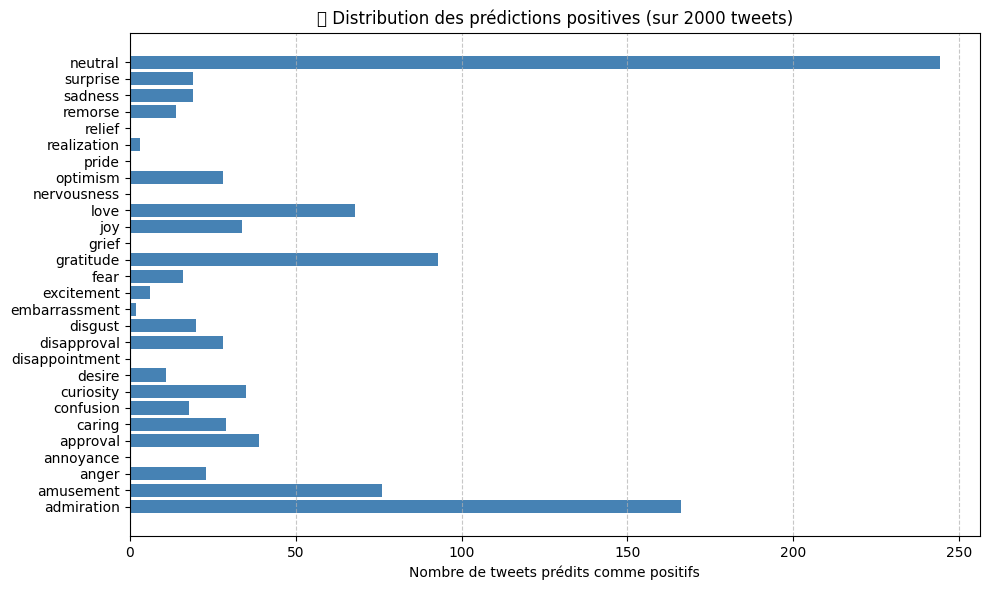

In [12]:
# Rechargement du modèle entraîné (chemin relatif depuis notebooks/)
model = AutoModelForSequenceClassification.from_pretrained("models/emotions/model")
tokenizer = AutoTokenizer.from_pretrained("models/emotions/tokenizer")
model.eval()

# Échantillon de test
df_test = df.sample(n = 2000, random_state = 70).reset_index(drop = True)
texts = df_test["text"].tolist()

# Tokenisation
encodings = tokenizer(texts, truncation = True, padding = True, return_tensors = "pt")

# Prédiction
with torch.no_grad():
    outputs = model(**encodings)

# Conversion logits → prédictions binaires
logits = outputs.logits.detach().numpy()
preds = (logits > 0).astype(int)

# Calcul du total de prédictions positives par émotion
pred_counts = preds.sum(axis=0)

# Affichage
plt.figure(figsize = (10, 6))
plt.barh(range(len(emotion_cols)), pred_counts, color = 'steelblue')
plt.yticks(ticks = range(len(emotion_cols)), labels = emotion_cols)
plt.title("📊 Distribution des prédictions positives (sur 2000 tweets)")
plt.xlabel("Nombre de tweets prédits comme positifs")
plt.grid(axis = "x", linestyle = "--", alpha = 0.7)
plt.tight_layout()
plt.show()

In [13]:
print(f"✔️ Nombre d'émotions dans emotion_cols : {len(emotion_cols)}")
print(f"✔️ Nombre de colonnes dans les prédictions : {pred_counts.shape}")

✔️ Nombre d'émotions dans emotion_cols : 28
✔️ Nombre de colonnes dans les prédictions : (28,)


## 8.2 - Comparaison VRAI vs PRÉDIT (2000 tweets)

C:\Users\motar\AppData\Local\Temp\ipykernel_29568\4263936731.py:20: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout()
c:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P09\P9_V2\venv_P9_V2\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


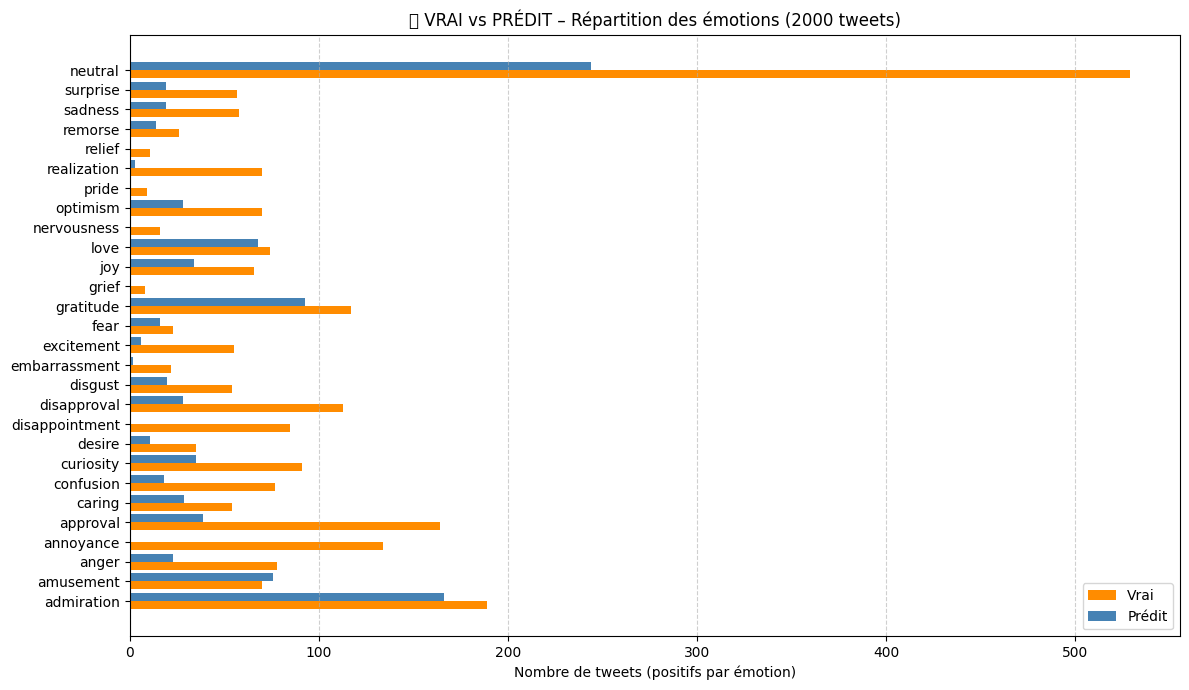

In [14]:
# Répartition réelle (ground truth)
true_counts = df_test[emotion_cols].sum().values

# Répartition des prédictions (déjà calculée précédemment)
pred_counts = preds.sum(axis=0)  # ← déjà défini

# Affichage comparatif
x = np.arange(len(emotion_cols))  # positions
width = 0.4

plt.figure(figsize=(12, 7))
plt.barh(x - width/2, true_counts, height=width, label='Vrai', color='darkorange')
plt.barh(x + width/2, pred_counts, height=width, label='Prédit', color='steelblue')

plt.yticks(ticks=x, labels=emotion_cols)
plt.xlabel("Nombre de tweets (positifs par émotion)")
plt.title("📊 VRAI vs PRÉDIT – Répartition des émotions (2000 tweets)")
plt.legend(loc="lower right")
plt.grid(axis="x", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

## 8.3 - Heatmap de co-occurrence des émotions prédites

C:\Users\motar\AppData\Local\Temp\ipykernel_29568\1794568889.py:11: UserWarning: Glyph 128293 (\N{FIRE}) missing from current font.
  plt.tight_layout()
c:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P09\P9_V2\venv_P9_V2\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128293 (\N{FIRE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


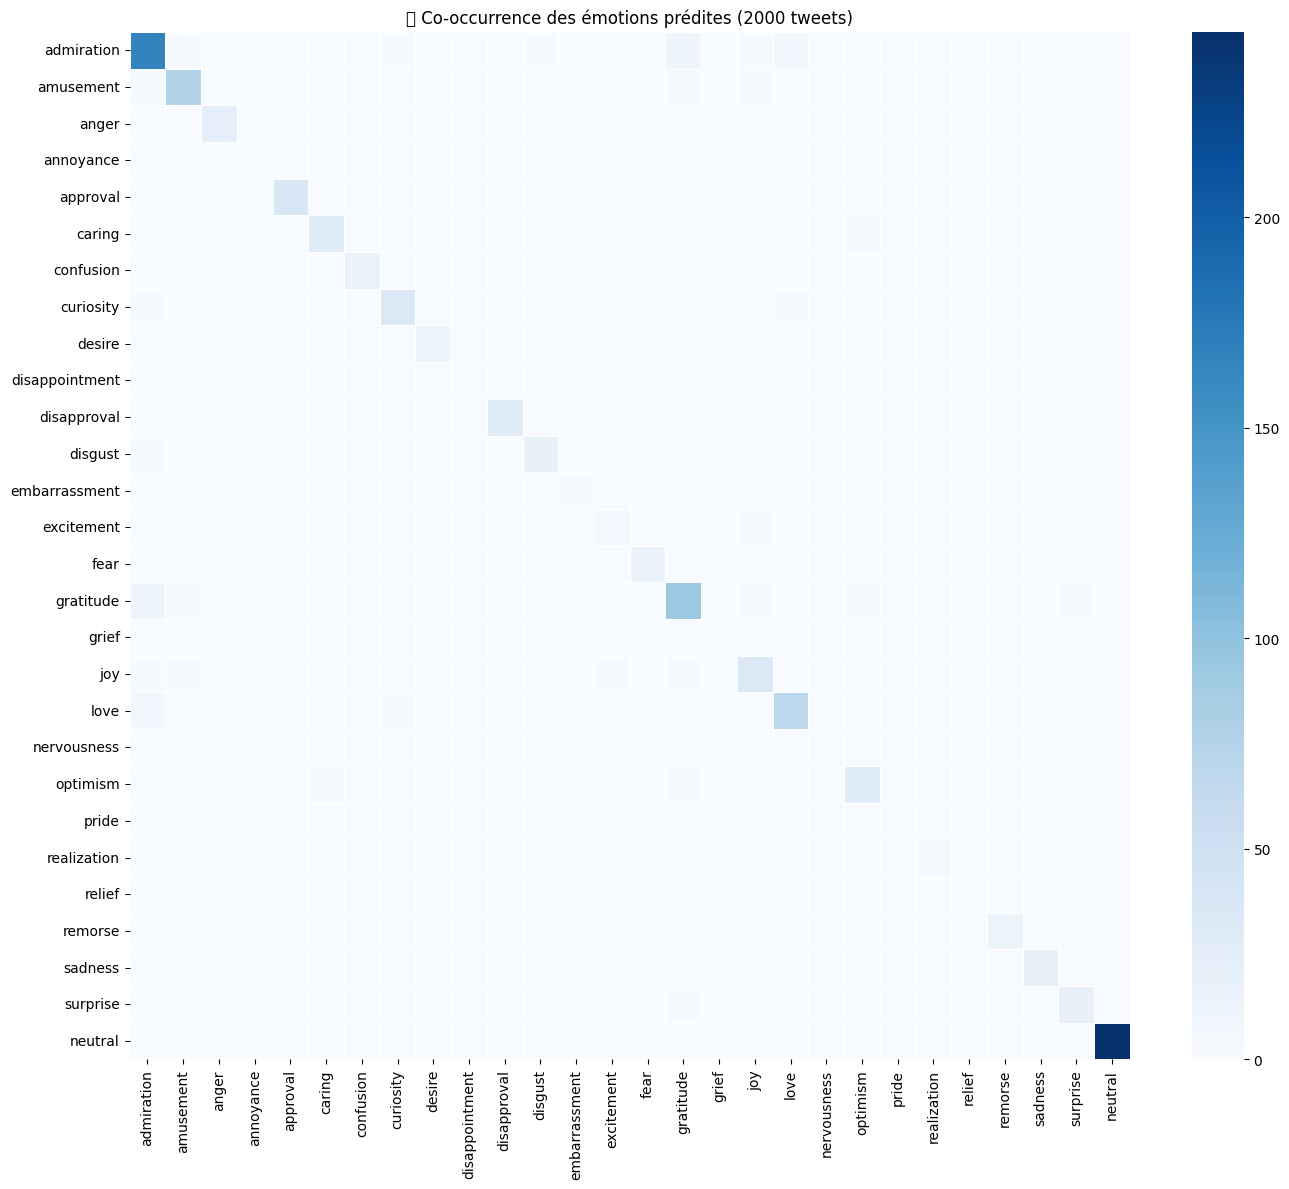

In [15]:
# Création d’une DataFrame des prédictions binaires (2000 tweets × 28 émotions)
pred_df = pd.DataFrame(preds, columns  =emotion_cols)

# Matrice de co-occurrence (corrélation binaire entre émotions)
co_matrix = pred_df.T.dot(pred_df)

# Heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(co_matrix, xticklabels=emotion_cols, yticklabels=emotion_cols, cmap="Blues", linewidths=0.5)
plt.title("🔥 Co-occurrence des émotions prédites (2000 tweets)")
plt.tight_layout()
plt.show()

## 8.4 - Export CSV des stats d’émotions par label

In [16]:
stats_df = pd.DataFrame({
    "emotion": emotion_cols,
    "true_count": true_counts,
    "pred_count": pred_counts,
    "difference": pred_counts - true_counts,
    "abs_error": np.abs(pred_counts - true_counts)
})

stats_df.sort_values(by="abs_error", ascending=False, inplace=True)
export_path = os.path.join("..", "outputs", "emotion_stats_2000.csv")
os.makedirs(os.path.dirname(export_path), exist_ok=True)
stats_df.to_csv(export_path, index=False, encoding="utf-8")

print(f"📁 Statistiques exportées avec succès dans : {export_path}")
display(stats_df.head(10))

📁 Statistiques exportées avec succès dans : ..\outputs\emotion_stats_2000.csv


,emotion,true_count,pred_count,difference,abs_error
27,neutral,529,244,-285,285
3,annoyance,134,0,-134,134
4,approval,164,39,-125,125
10,disapproval,113,28,-85,85
9,disappointment,85,0,-85,85
22,realization,70,3,-67,67
6,confusion,77,18,-59,59
7,curiosity,91,35,-56,56
2,anger,78,23,-55,55
13,excitement,55,6,-49,49


# 9 - Vérification des artefacts

In [17]:
print("\n🗂️ Modèles enregistrés :")
afficher_arborescence("models/emotions", niveau_max = 2)


🗂️ Modèles enregistrés :
├── checkpoint-65980
│   ├── config.json
│   ├── optimizer.pt
│   ├── pytorch_model.bin
│   ├── rng_state.pth
│   ├── scheduler.pt
│   ├── special_tokens_map.json
│   ├── tokenizer.json
│   ├── tokenizer_config.json
│   ├── trainer_state.json
│   ├── training_args.bin
│   ├── vocab.txt
├── checkpoint-92372
│   ├── config.json
│   ├── optimizer.pt
│   ├── pytorch_model.bin
│   ├── rng_state.pth
│   ├── scheduler.pt
│   ├── special_tokens_map.json
│   ├── tokenizer.json
│   ├── tokenizer_config.json
│   ├── trainer_state.json
│   ├── training_args.bin
│   ├── vocab.txt
├── logs
│   ├── events.out.tfevents.1746978163.PC-ARNAUD.13144.0
│   ├── events.out.tfevents.1746978485.PC-ARNAUD.26512.0
│   ├── events.out.tfevents.1746978666.PC-ARNAUD.4760.0
│   ├── events.out.tfevents.1746994927.PC-ARNAUD.4760.1
│   ├── events.out.tfevents.1746997802.PC-ARNAUD.30124.0
│   ├── events.out.tfevents.1747035152.PC-ARNAUD.30124.1
│   ├── events.out.tfevents.1747036724.PC-ARNAUD.30

## 9.1 - Interface de tracking MLflow (http://localhost:5000)

In [18]:
import subprocess

try:
    subprocess.Popen(["mlflow", "ui"])
    print("✅ MLflow UI lancé sur http://localhost:5000")
except Exception as e:
    print(f"❌ Impossible de lancer MLflow UI : {e}")

✅ MLflow UI lancé sur http://localhost:5000


In [19]:
import os
import mlflow

# 🔧 Spécifie l'URI local
mlruns_path = os.path.abspath("../mlruns").replace("\\", "/")
mlflow.set_tracking_uri(f"file:///{mlruns_path}")

# 🔍 Recherche du modèle enregistré
client = mlflow.MlflowClient()
model_name = "emotions_classifier"

try:
    model = client.get_registered_model(model_name)
    print(f"✅ Modèle {model.name} trouvé avec {len(model.latest_versions)} version(s)")

    for version in model.latest_versions:
        print("📦 Version:", version.version)
        print("🔁 Run ID :", version.run_id)
        print("📂 Source :", version.source)
        print("-" * 30)

except Exception as e:
    print(f"❌ Erreur : {e}")

✅ Modèle emotions_classifier trouvé avec 3 version(s)
📦 Version: 1
🔁 Run ID : d28ed191e37a4761971a3332f9ff0a29
📂 Source : file:///C:/Users/motar/Desktop/1-openclassrooms/AI_Engineer/1-projets/P09/P9_V2/mlruns/0/d28ed191e37a4761971a3332f9ff0a29/artifacts/emotions_model
------------------------------
📦 Version: 2
🔁 Run ID : 2a4098924208444baa1d3cffcc3abb70
📂 Source : file:///C:/Users/motar/Desktop/1-openclassrooms/AI_Engineer/1-projets/P09/P9_V2/mlruns/0/2a4098924208444baa1d3cffcc3abb70/artifacts/emotions_model
------------------------------
📦 Version: 3
🔁 Run ID : 4589d8f9e2514c11866d287cc1c506ce
📂 Source : file:///C:/Users/motar/Desktop/1-openclassrooms/AI_Engineer/1-projets/P09/P9_V2/mlruns/0/4589d8f9e2514c11866d287cc1c506ce/artifacts/emotions_model
------------------------------


# Lien vers l'application (ngrok) :
# https://f22e-2a01-cb1d-8598-1400-4ac7-ab2e-4237-81aa.ngrok-free.app